In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2023/ANATOMIA PATOLOGICA.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 4:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]),
                          len(answer_positions["C"]), len(answer_positions["D"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 10 questions
Page 1, Q1 - A: Detected box: x0=68.3, y0=102.0, x1=203.4, y1=114.7
Page 1, Q1, A: Yellow pixels: 1935
Page 1, Q1, A: Total non-white pixels: 2418
Page 1, Q1, A: Yellow percentage: 80.0%


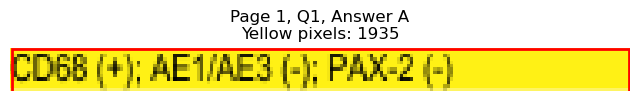

Page 1, Q1 - B: Detected box: x0=68.3, y0=114.6, x1=205.7, y1=127.3
Page 1, Q1, B: Yellow pixels: 185
Page 1, Q1, B: Total non-white pixels: 822
Page 1, Q1, B: Yellow percentage: 22.5%


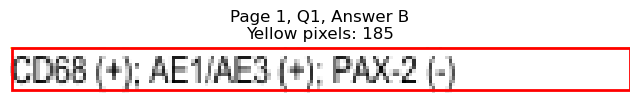

Page 1, Q1 - C: Detected box: x0=327.5, y0=102.0, x1=467.3, y1=114.7
Page 1, Q1, C: Yellow pixels: 0
Page 1, Q1, C: Total non-white pixels: 630
Page 1, Q1, C: Yellow percentage: 0.0%


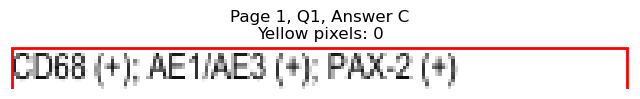

Page 1, Q1 - D: Detected box: x0=327.5, y0=114.6, x1=462.7, y1=127.3
Page 1, Q1, D: Yellow pixels: 0
Page 1, Q1, D: Total non-white pixels: 633
Page 1, Q1, D: Yellow percentage: 0.0%


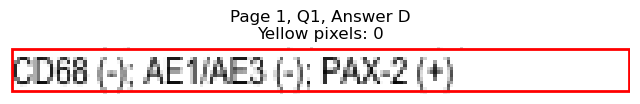


Page 1, Q1 - Selected Answer: A (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=68.3, y0=190.3, x1=144.0, y1=203.0
Page 1, Q2, A: Yellow pixels: 0
Page 1, Q2, A: Total non-white pixels: 416
Page 1, Q2, A: Yellow percentage: 0.0%


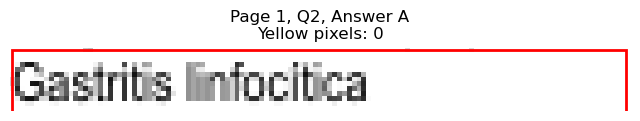

Page 1, Q2 - B: Detected box: x0=68.3, y0=202.9, x1=140.5, y1=215.6
Page 1, Q2, B: Yellow pixels: 0
Page 1, Q2, B: Total non-white pixels: 344
Page 1, Q2, B: Yellow percentage: 0.0%


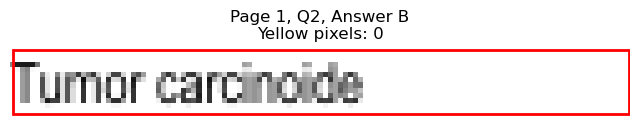

Page 1, Q2 - C: Detected box: x0=327.5, y0=190.3, x1=427.4, y1=203.0
Page 1, Q2, C: Yellow pixels: 1580
Page 1, Q2, C: Total non-white pixels: 1963
Page 1, Q2, C: Yellow percentage: 80.5%


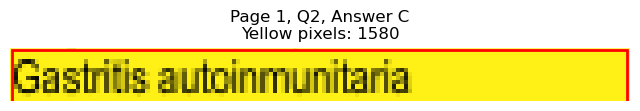

Page 1, Q2 - D: Detected box: x0=327.5, y0=202.9, x1=395.2, y1=215.6
Page 1, Q2, D: Yellow pixels: 119
Page 1, Q2, D: Total non-white pixels: 470
Page 1, Q2, D: Yellow percentage: 25.3%


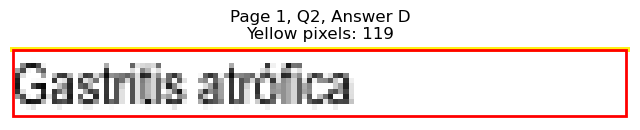


Page 1, Q2 - Selected Answer: C (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=68.3, y0=240.9, x1=123.5, y1=253.5
Page 1, Q3, A: Yellow pixels: 0
Page 1, Q3, A: Total non-white pixels: 285
Page 1, Q3, A: Yellow percentage: 0.0%


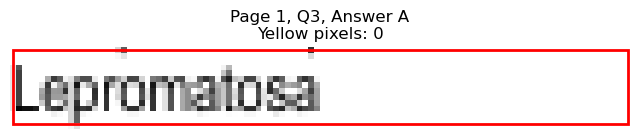

Page 1, Q3 - B: Detected box: x0=68.3, y0=253.5, x1=151.6, y1=266.1
Page 1, Q3, B: Yellow pixels: 0
Page 1, Q3, B: Total non-white pixels: 437
Page 1, Q3, B: Yellow percentage: 0.0%


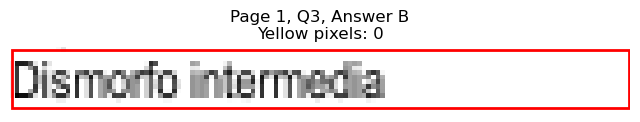

Page 1, Q3 - C: Detected box: x0=327.5, y0=240.9, x1=418.3, y1=253.5
Page 1, Q3, C: Yellow pixels: 142
Page 1, Q3, C: Total non-white pixels: 612
Page 1, Q3, C: Yellow percentage: 23.2%


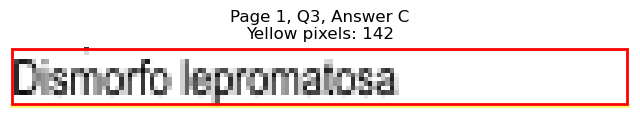

Page 1, Q3 - D: Detected box: x0=327.5, y0=253.5, x1=382.3, y1=266.1
Page 1, Q3, D: Yellow pixels: 1169
Page 1, Q3, D: Total non-white pixels: 1484
Page 1, Q3, D: Yellow percentage: 78.8%


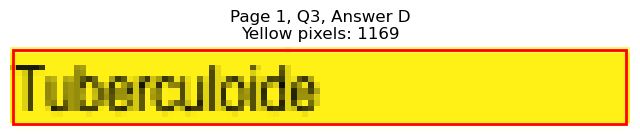


Page 1, Q3 - Selected Answer: D (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=68.3, y0=329.2, x1=118.9, y1=341.9
Page 1, Q4, A: Yellow pixels: 0
Page 1, Q4, A: Total non-white pixels: 255
Page 1, Q4, A: Yellow percentage: 0.0%


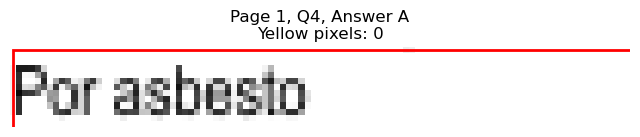

Page 1, Q4 - B: Detected box: x0=68.3, y0=341.9, x1=103.5, y1=354.6
Page 1, Q4, B: Yellow pixels: 975
Page 1, Q4, B: Total non-white pixels: 1204
Page 1, Q4, B: Yellow percentage: 81.0%


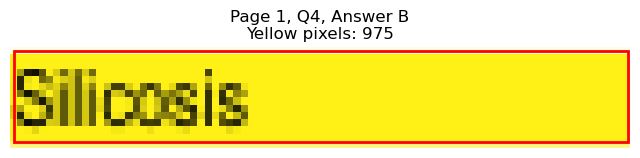

Page 1, Q4 - C: Detected box: x0=327.5, y0=329.2, x1=450.9, y1=341.9
Page 1, Q4, C: Yellow pixels: 0
Page 1, Q4, C: Total non-white pixels: 597
Page 1, Q4, C: Yellow percentage: 0.0%


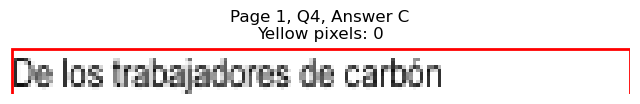

Page 1, Q4 - D: Detected box: x0=327.5, y0=341.9, x1=366.2, y1=354.6
Page 1, Q4, D: Yellow pixels: 0
Page 1, Q4, D: Total non-white pixels: 203
Page 1, Q4, D: Yellow percentage: 0.0%


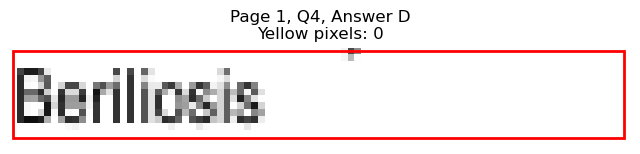


Page 1, Q4 - Selected Answer: B (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=68.3, y0=404.9, x1=155.1, y1=417.6
Page 1, Q5, A: Yellow pixels: 0
Page 1, Q5, A: Total non-white pixels: 403
Page 1, Q5, A: Yellow percentage: 0.0%


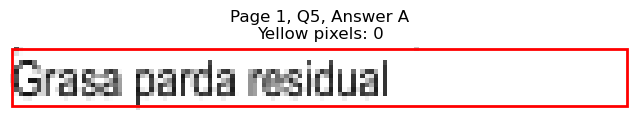

Page 1, Q5 - B: Detected box: x0=68.3, y0=417.6, x1=120.0, y1=430.3
Page 1, Q5, B: Yellow pixels: 1041
Page 1, Q5, B: Total non-white pixels: 1442
Page 1, Q5, B: Yellow percentage: 72.2%


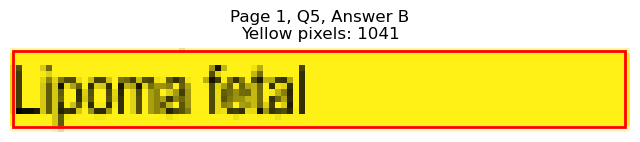

Page 1, Q5 - C: Detected box: x0=327.5, y0=404.9, x1=413.8, y1=417.6
Page 1, Q5, C: Yellow pixels: 0
Page 1, Q5, C: Total non-white pixels: 424
Page 1, Q5, C: Yellow percentage: 0.0%


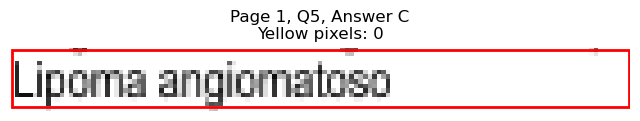

Page 1, Q5 - D: Detected box: x0=327.5, y0=417.6, x1=431.3, y1=430.3
Page 1, Q5, D: Yellow pixels: 0
Page 1, Q5, D: Total non-white pixels: 524
Page 1, Q5, D: Yellow percentage: 0.0%


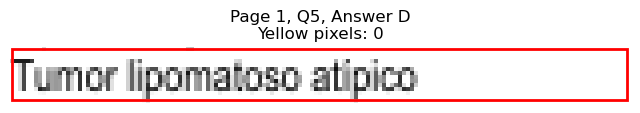


Page 1, Q5 - Selected Answer: B (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=68.3, y0=455.5, x1=232.4, y1=468.1
Page 1, Q6, A: Yellow pixels: 0
Page 1, Q6, A: Total non-white pixels: 795
Page 1, Q6, A: Yellow percentage: 0.0%


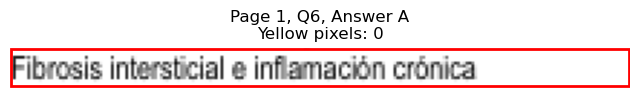

Page 1, Q6 - B: Detected box: x0=68.3, y0=468.1, x1=127.0, y1=480.7
Page 1, Q6, B: Yellow pixels: 0
Page 1, Q6, B: Total non-white pixels: 256
Page 1, Q6, B: Yellow percentage: 0.0%


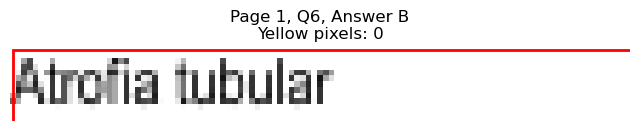

Page 1, Q6 - C: Detected box: x0=327.5, y0=455.5, x1=446.3, y1=468.1
Page 1, Q6, C: Yellow pixels: 170
Page 1, Q6, C: Total non-white pixels: 782
Page 1, Q6, C: Yellow percentage: 21.7%


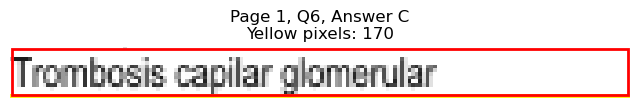

Page 1, Q6 - D: Detected box: x0=327.5, y0=468.1, x1=411.8, y1=480.7
Page 1, Q6, D: Yellow pixels: 1412
Page 1, Q6, D: Total non-white pixels: 1755
Page 1, Q6, D: Yellow percentage: 80.5%


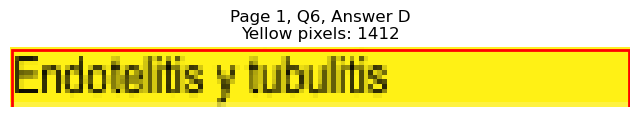


Page 1, Q6 - Selected Answer: D (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=68.3, y0=531.2, x1=124.0, y1=543.8
Page 1, Q7, A: Yellow pixels: 0
Page 1, Q7, A: Total non-white pixels: 297
Page 1, Q7, A: Yellow percentage: 0.0%


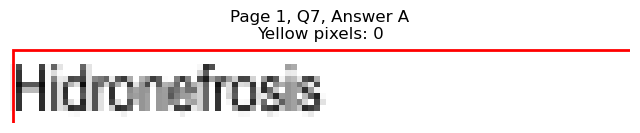

Page 1, Q7 - B: Detected box: x0=68.3, y0=543.8, x1=97.3, y1=556.4
Page 1, Q7, B: Yellow pixels: 0
Page 1, Q7, B: Total non-white pixels: 159
Page 1, Q7, B: Yellow percentage: 0.0%


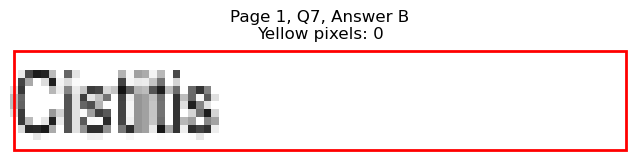

Page 1, Q7 - C: Detected box: x0=327.5, y0=531.2, x1=415.3, y1=543.8
Page 1, Q7, C: Yellow pixels: 0
Page 1, Q7, C: Total non-white pixels: 601
Page 1, Q7, C: Yellow percentage: 0.0%


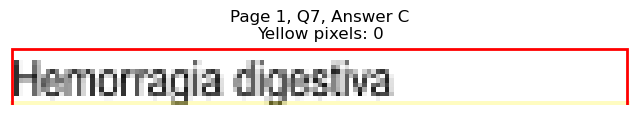

Page 1, Q7 - D: Detected box: x0=327.5, y0=543.8, x1=380.7, y1=556.4
Page 1, Q7, D: Yellow pixels: 1116
Page 1, Q7, D: Total non-white pixels: 1456
Page 1, Q7, D: Yellow percentage: 76.6%


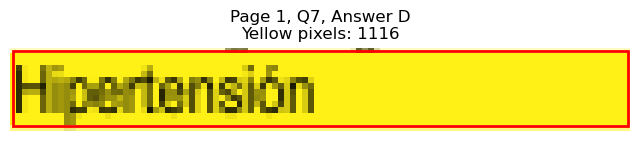


Page 1, Q7 - Selected Answer: D (based on yellow pixel count)




Page 1, Q8 - A: Detected box: x0=68.3, y0=581.7, x1=182.7, y1=594.4
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 555
Page 1, Q8, A: Yellow percentage: 0.0%


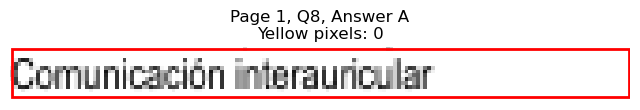

Page 1, Q8 - B: Detected box: x0=68.3, y0=594.3, x1=193.7, y1=607.0
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 645
Page 1, Q8, B: Yellow percentage: 0.0%


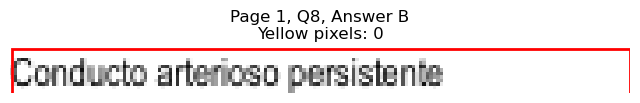

Page 1, Q8 - C: Detected box: x0=327.5, y0=581.7, x1=409.3, y1=594.4
Page 1, Q8, C: Yellow pixels: 133
Page 1, Q8, C: Total non-white pixels: 546
Page 1, Q8, C: Yellow percentage: 24.4%


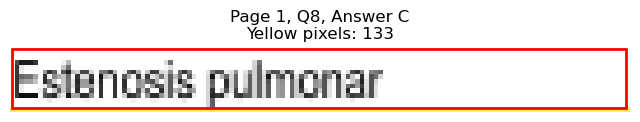

Page 1, Q8 - D: Detected box: x0=327.5, y0=594.3, x1=448.9, y1=607.0
Page 1, Q8, D: Yellow pixels: 1789
Page 1, Q8, D: Total non-white pixels: 2236
Page 1, Q8, D: Yellow percentage: 80.0%


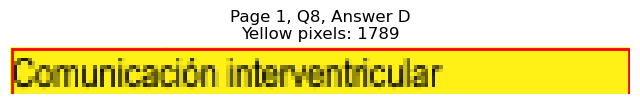


Page 1, Q8 - Selected Answer: D (based on yellow pixel count)




Page 1, Q9 - A: Detected box: x0=68.3, y0=657.5, x1=109.0, y1=670.1
Page 1, Q9, A: Yellow pixels: 91
Page 1, Q9, A: Total non-white pixels: 304
Page 1, Q9, A: Yellow percentage: 29.9%


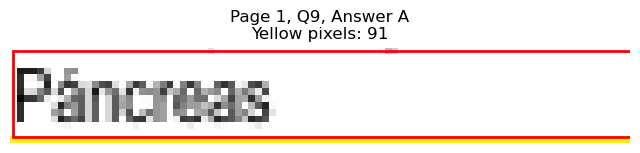

Page 1, Q9 - B: Detected box: x0=68.3, y0=670.1, x1=108.4, y1=682.7
Page 1, Q9, B: Yellow pixels: 1023
Page 1, Q9, B: Total non-white pixels: 1183
Page 1, Q9, B: Yellow percentage: 86.5%


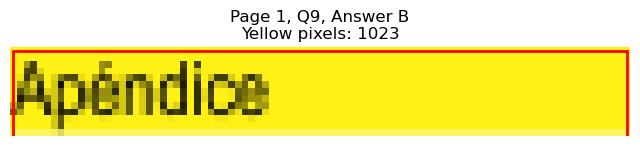

Page 1, Q9 - C: Detected box: x0=327.5, y0=657.5, x1=359.1, y1=670.1
Page 1, Q9, C: Yellow pixels: 0
Page 1, Q9, C: Total non-white pixels: 160
Page 1, Q9, C: Yellow percentage: 0.0%


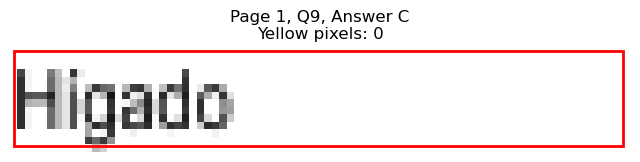

Page 1, Q9 - D: Detected box: x0=327.5, y0=670.1, x1=370.6, y1=682.7
Page 1, Q9, D: Yellow pixels: 0
Page 1, Q9, D: Total non-white pixels: 234
Page 1, Q9, D: Yellow percentage: 0.0%


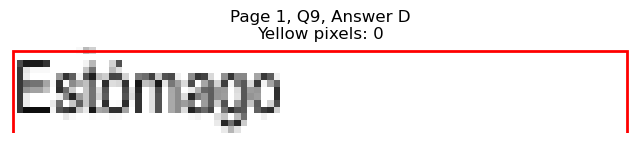


Page 1, Q9 - Selected Answer: B (based on yellow pixel count)




Page 1, Q10 - A: Detected box: x0=68.3, y0=708.0, x1=112.0, y1=720.6
Page 1, Q10, A: Yellow pixels: 1056
Page 1, Q10, A: Total non-white pixels: 1316
Page 1, Q10, A: Yellow percentage: 80.2%


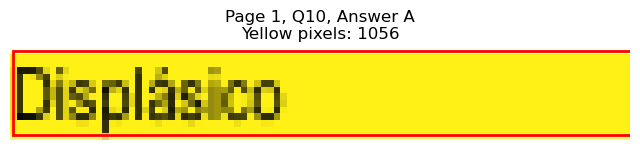

Page 1, Q10 - B: Detected box: x0=68.3, y0=720.6, x1=106.9, y1=733.2
Page 1, Q10, B: Yellow pixels: 89
Page 1, Q10, B: Total non-white pixels: 262
Page 1, Q10, B: Yellow percentage: 34.0%


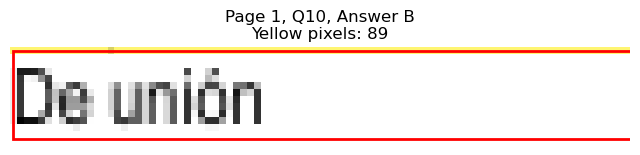

Page 1, Q10 - C: Detected box: x0=327.5, y0=708.0, x1=380.2, y1=720.6
Page 1, Q10, C: Yellow pixels: 0
Page 1, Q10, C: Total non-white pixels: 275
Page 1, Q10, C: Yellow percentage: 0.0%


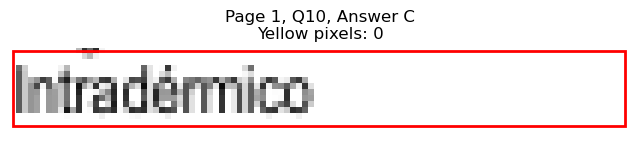

Page 1, Q10 - D: Detected box: x0=327.5, y0=720.6, x1=376.1, y1=733.2
Page 1, Q10, D: Yellow pixels: 0
Page 1, Q10, D: Total non-white pixels: 224
Page 1, Q10, D: Yellow percentage: 0.0%


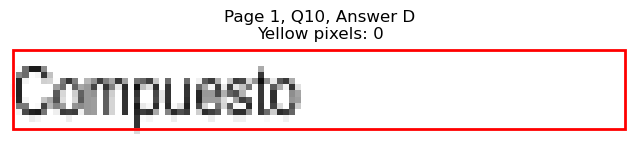


Page 1, Q10 - Selected Answer: A (based on yellow pixel count)





Page 2: Found 11 questions
Page 2, Q1 - A: Detected box: x0=68.3, y0=102.0, x1=173.7, y1=114.7
Page 2, Q1, A: Yellow pixels: 0
Page 2, Q1, A: Total non-white pixels: 563
Page 2, Q1, A: Yellow percentage: 0.0%


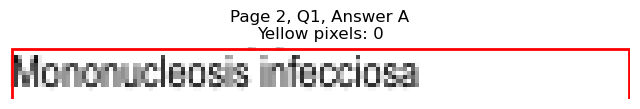

Page 2, Q1 - B: Detected box: x0=68.3, y0=114.6, x1=103.5, y1=127.3
Page 2, Q1, B: Yellow pixels: 0
Page 2, Q1, B: Total non-white pixels: 179
Page 2, Q1, B: Yellow percentage: 0.0%


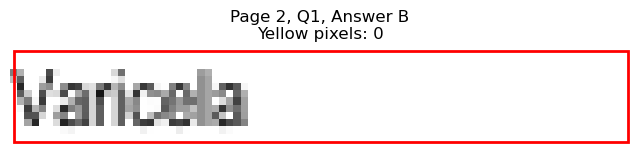

Page 2, Q1 - C: Detected box: x0=327.5, y0=102.0, x1=363.7, y1=114.7
Page 2, Q1, C: Yellow pixels: 0
Page 2, Q1, C: Total non-white pixels: 283
Page 2, Q1, C: Yellow percentage: 0.0%


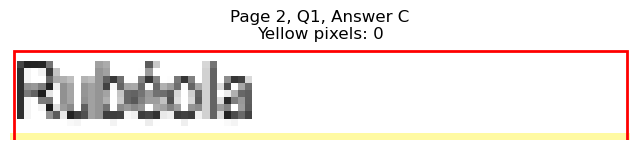

Page 2, Q1 - D: Detected box: x0=327.5, y0=114.6, x1=373.7, y1=127.3
Page 2, Q1, D: Yellow pixels: 983
Page 2, Q1, D: Total non-white pixels: 1358
Page 2, Q1, D: Yellow percentage: 72.4%


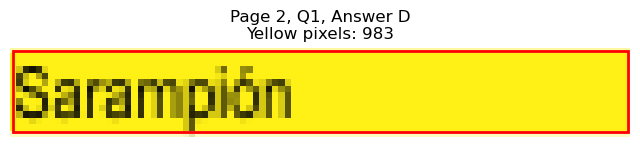


Page 2, Q1 - Selected Answer: D (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=68.3, y0=165.1, x1=132.0, y1=177.8
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 458
Page 2, Q2, A: Yellow percentage: 0.0%


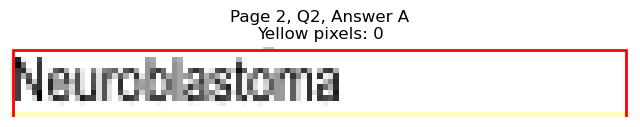

Page 2, Q2 - B: Detected box: x0=68.3, y0=177.7, x1=137.1, y1=190.4
Page 2, Q2, B: Yellow pixels: 1130
Page 2, Q2, B: Total non-white pixels: 1680
Page 2, Q2, B: Yellow percentage: 67.3%


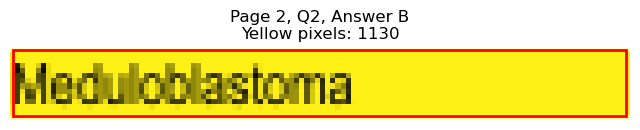

Page 2, Q2 - C: Detected box: x0=327.5, y0=165.1, x1=377.7, y1=177.8
Page 2, Q2, C: Yellow pixels: 0
Page 2, Q2, C: Total non-white pixels: 251
Page 2, Q2, C: Yellow percentage: 0.0%


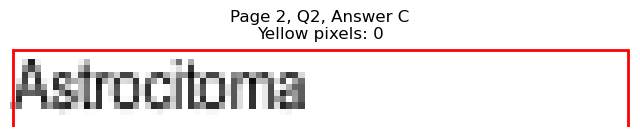

Page 2, Q2 - D: Detected box: x0=327.5, y0=177.7, x1=405.8, y1=190.4
Page 2, Q2, D: Yellow pixels: 0
Page 2, Q2, D: Total non-white pixels: 413
Page 2, Q2, D: Yellow percentage: 0.0%


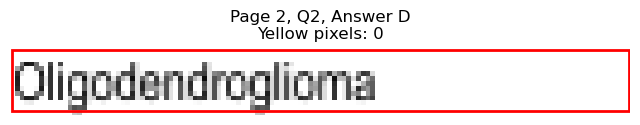


Page 2, Q2 - Selected Answer: B (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=68.3, y0=215.7, x1=133.5, y1=228.3
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 312
Page 2, Q3, A: Yellow percentage: 0.0%


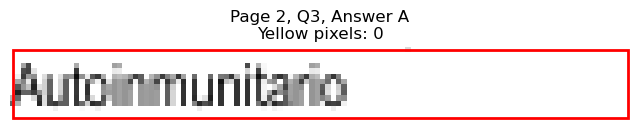

Page 2, Q3 - B: Detected box: x0=68.3, y0=228.3, x1=147.5, y1=240.9
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 432
Page 2, Q3, B: Yellow percentage: 0.0%


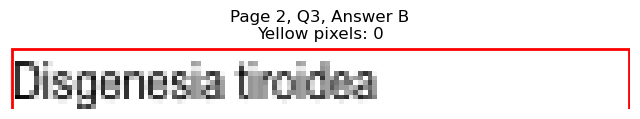

Page 2, Q3 - C: Detected box: x0=327.5, y0=215.7, x1=382.7, y1=228.3
Page 2, Q3, C: Yellow pixels: 1054
Page 2, Q3, C: Total non-white pixels: 1484
Page 2, Q3, C: Yellow percentage: 71.0%


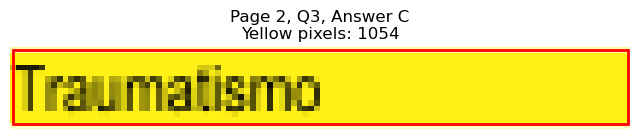

Page 2, Q3 - D: Detected box: x0=327.5, y0=228.3, x1=422.3, y1=240.9
Page 2, Q3, D: Yellow pixels: 0
Page 2, Q3, D: Total non-white pixels: 636
Page 2, Q3, D: Yellow percentage: 0.0%


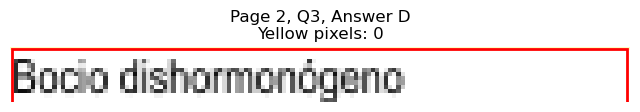


Page 2, Q3 - Selected Answer: C (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=68.3, y0=266.1, x1=176.7, y1=278.7
Page 2, Q4, A: Yellow pixels: 0
Page 2, Q4, A: Total non-white pixels: 521
Page 2, Q4, A: Yellow percentage: 0.0%


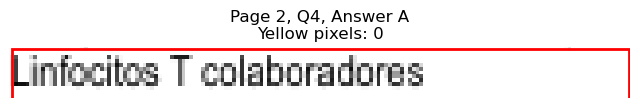

Page 2, Q4 - B: Detected box: x0=68.3, y0=278.8, x1=148.6, y1=291.5
Page 2, Q4, B: Yellow pixels: 0
Page 2, Q4, B: Total non-white pixels: 419
Page 2, Q4, B: Yellow percentage: 0.0%


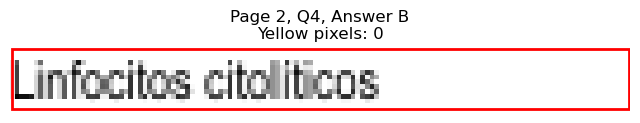

Page 2, Q4 - C: Detected box: x0=327.5, y0=266.1, x1=371.2, y1=278.7
Page 2, Q4, C: Yellow pixels: 0
Page 2, Q4, C: Total non-white pixels: 227
Page 2, Q4, C: Yellow percentage: 0.0%


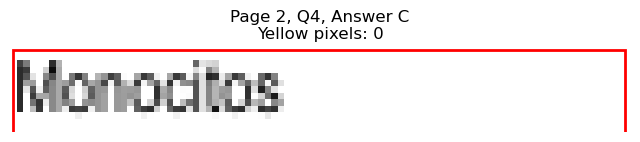

Page 2, Q4 - D: Detected box: x0=327.5, y0=278.8, x1=469.1, y1=291.5
Page 2, Q4, D: Yellow pixels: 1951
Page 2, Q4, D: Total non-white pixels: 2702
Page 2, Q4, D: Yellow percentage: 72.2%


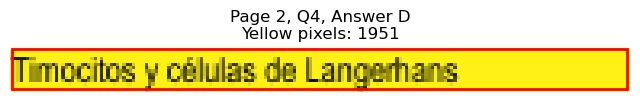


Page 2, Q4 - Selected Answer: D (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=68.3, y0=316.6, x1=142.0, y1=329.3
Page 2, Q5, A: Yellow pixels: 124
Page 2, Q5, A: Total non-white pixels: 468
Page 2, Q5, A: Yellow percentage: 26.5%


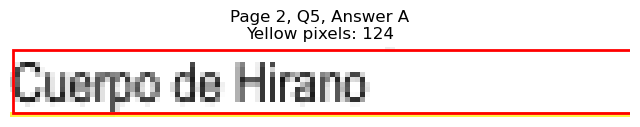

Page 2, Q5 - B: Detected box: x0=68.3, y0=329.2, x1=143.1, y1=341.9
Page 2, Q5, B: Yellow pixels: 1363
Page 2, Q5, B: Total non-white pixels: 1638
Page 2, Q5, B: Yellow percentage: 83.2%


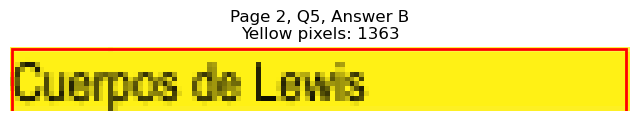

Page 2, Q5 - C: Detected box: x0=327.5, y0=316.6, x1=394.7, y1=329.3
Page 2, Q5, C: Yellow pixels: 0
Page 2, Q5, C: Total non-white pixels: 337
Page 2, Q5, C: Yellow percentage: 0.0%


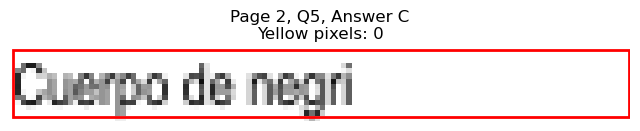

Page 2, Q5 - D: Detected box: x0=327.5, y0=329.2, x1=416.8, y1=341.9
Page 2, Q5, D: Yellow pixels: 0
Page 2, Q5, D: Total non-white pixels: 473
Page 2, Q5, D: Yellow percentage: 0.0%


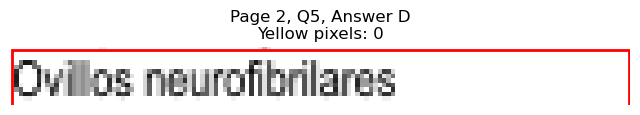


Page 2, Q5 - Selected Answer: B (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=68.3, y0=405.0, x1=103.3, y1=417.7
Page 2, Q6, A: Yellow pixels: 0
Page 2, Q6, A: Total non-white pixels: 174
Page 2, Q6, A: Yellow percentage: 0.0%


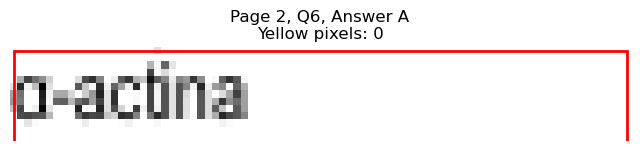

Page 2, Q6 - B: Detected box: x0=68.3, y0=417.6, x1=93.9, y1=430.3
Page 2, Q6, B: Yellow pixels: 0
Page 2, Q6, B: Total non-white pixels: 125
Page 2, Q6, B: Yellow percentage: 0.0%


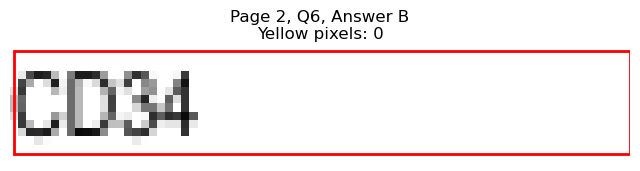

Page 2, Q6 - C: Detected box: x0=327.5, y0=405.0, x1=372.7, y1=417.7
Page 2, Q6, C: Yellow pixels: 1066
Page 2, Q6, C: Total non-white pixels: 1248
Page 2, Q6, C: Yellow percentage: 85.4%


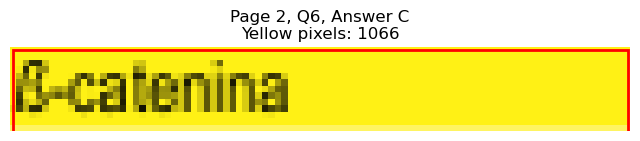

Page 2, Q6 - D: Detected box: x0=327.5, y0=417.6, x1=351.2, y1=430.3
Page 2, Q6, D: Yellow pixels: 75
Page 2, Q6, D: Total non-white pixels: 183
Page 2, Q6, D: Yellow percentage: 41.0%


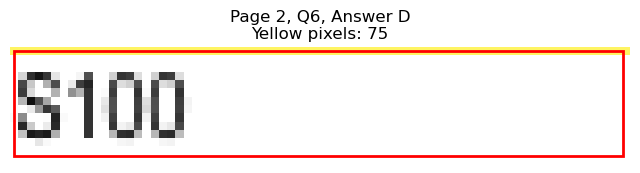


Page 2, Q6 - Selected Answer: C (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=68.3, y0=468.2, x1=118.0, y1=480.8
Page 2, Q7, A: Yellow pixels: 0
Page 2, Q7, A: Total non-white pixels: 333
Page 2, Q7, A: Yellow percentage: 0.0%


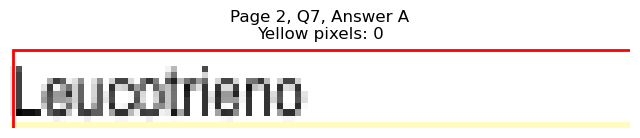

Page 2, Q7 - B: Detected box: x0=68.3, y0=480.8, x1=104.4, y1=493.4
Page 2, Q7, B: Yellow pixels: 902
Page 2, Q7, B: Total non-white pixels: 1218
Page 2, Q7, B: Yellow percentage: 74.1%


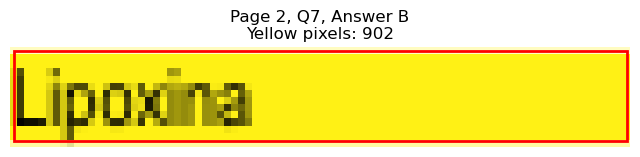

Page 2, Q7 - C: Detected box: x0=327.5, y0=468.2, x1=381.2, y1=480.8
Page 2, Q7, C: Yellow pixels: 0
Page 2, Q7, C: Total non-white pixels: 281
Page 2, Q7, C: Yellow percentage: 0.0%


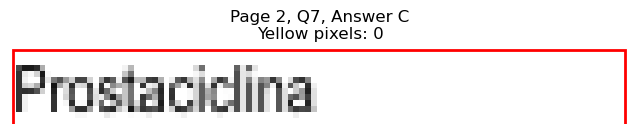

Page 2, Q7 - D: Detected box: x0=327.5, y0=480.8, x1=380.7, y1=493.4
Page 2, Q7, D: Yellow pixels: 0
Page 2, Q7, D: Total non-white pixels: 251
Page 2, Q7, D: Yellow percentage: 0.0%


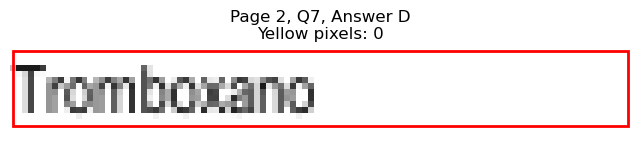


Page 2, Q7 - Selected Answer: B (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=68.3, y0=531.2, x1=164.5, y1=543.8
Page 2, Q8, A: Yellow pixels: 0
Page 2, Q8, A: Total non-white pixels: 522
Page 2, Q8, A: Yellow percentage: 0.0%


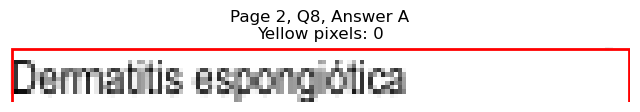

Page 2, Q8 - B: Detected box: x0=68.3, y0=543.9, x1=99.9, y1=556.6
Page 2, Q8, B: Yellow pixels: 0
Page 2, Q8, B: Total non-white pixels: 177
Page 2, Q8, B: Yellow percentage: 0.0%


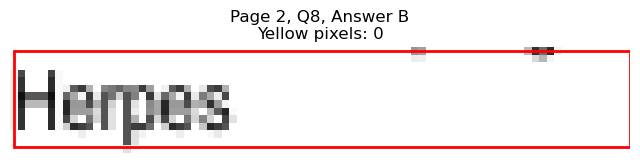

Page 2, Q8 - C: Detected box: x0=327.5, y0=531.2, x1=377.7, y1=543.8
Page 2, Q8, C: Yellow pixels: 0
Page 2, Q8, C: Total non-white pixels: 252
Page 2, Q8, C: Yellow percentage: 0.0%


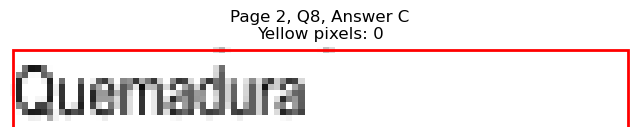

Page 2, Q8 - D: Detected box: x0=327.5, y0=543.9, x1=387.8, y1=556.6
Page 2, Q8, D: Yellow pixels: 1192
Page 2, Q8, D: Total non-white pixels: 1554
Page 2, Q8, D: Yellow percentage: 76.7%


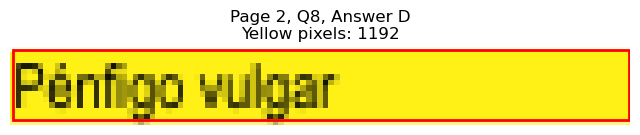


Page 2, Q8 - Selected Answer: D (based on yellow pixel count)




Page 2, Q9 - A: Detected box: x0=68.3, y0=581.7, x1=103.5, y1=594.4
Page 2, Q9, A: Yellow pixels: 893
Page 2, Q9, A: Total non-white pixels: 1204
Page 2, Q9, A: Yellow percentage: 74.2%


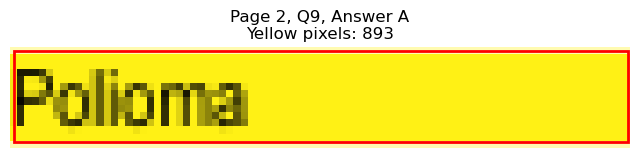

Page 2, Q9 - B: Detected box: x0=68.3, y0=594.3, x1=85.8, y1=607.0
Page 2, Q9, B: Yellow pixels: 0
Page 2, Q9, B: Total non-white pixels: 150
Page 2, Q9, B: Yellow percentage: 0.0%


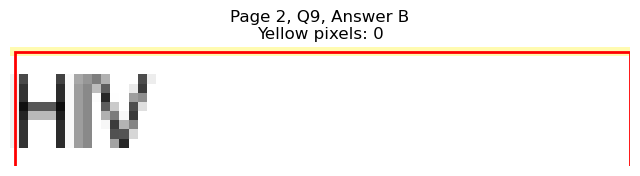

Page 2, Q9 - C: Detected box: x0=327.5, y0=581.7, x1=350.1, y1=594.4
Page 2, Q9, C: Yellow pixels: 0
Page 2, Q9, C: Total non-white pixels: 108
Page 2, Q9, C: Yellow percentage: 0.0%


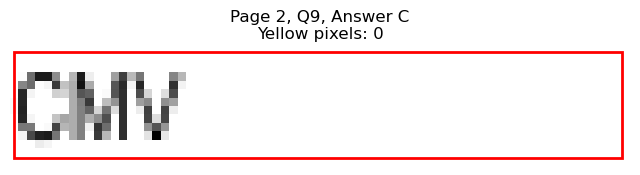

Page 2, Q9 - D: Detected box: x0=327.5, y0=594.3, x1=379.7, y1=607.0
Page 2, Q9, D: Yellow pixels: 0
Page 2, Q9, D: Total non-white pixels: 284
Page 2, Q9, D: Yellow percentage: 0.0%


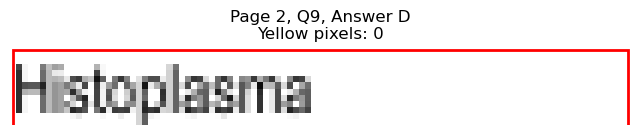


Page 2, Q9 - Selected Answer: A (based on yellow pixel count)




Page 2, Q10 - A: Detected box: x0=68.3, y0=632.2, x1=107.9, y1=644.9
Page 2, Q10, A: Yellow pixels: 0
Page 2, Q10, A: Total non-white pixels: 211
Page 2, Q10, A: Yellow percentage: 0.0%


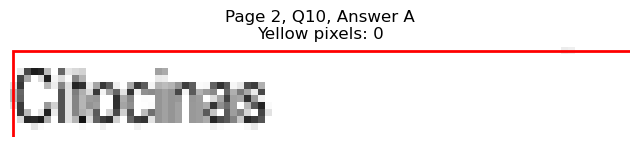

Page 2, Q10 - B: Detected box: x0=68.3, y0=644.9, x1=88.3, y1=657.5
Page 2, Q10, B: Yellow pixels: 0
Page 2, Q10, B: Total non-white pixels: 83
Page 2, Q10, B: Yellow percentage: 0.0%


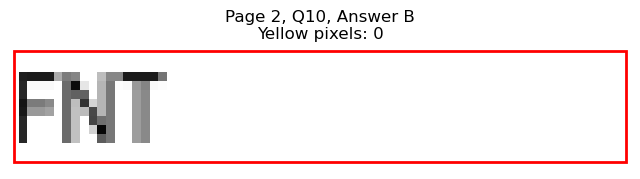

Page 2, Q10 - C: Detected box: x0=327.5, y0=632.2, x1=379.7, y1=644.9
Page 2, Q10, C: Yellow pixels: 0
Page 2, Q10, C: Total non-white pixels: 354
Page 2, Q10, C: Yellow percentage: 0.0%


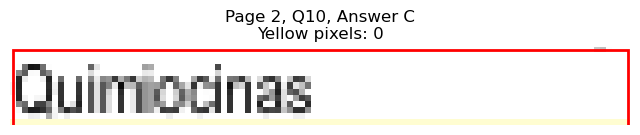

Page 2, Q10 - D: Detected box: x0=327.5, y0=644.9, x1=369.7, y1=657.5
Page 2, Q10, D: Yellow pixels: 1039
Page 2, Q10, D: Total non-white pixels: 1302
Page 2, Q10, D: Yellow percentage: 79.8%


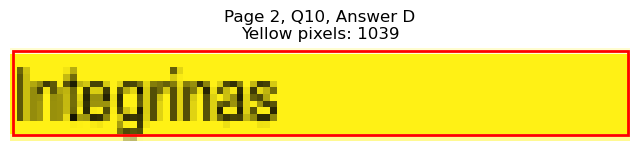


Page 2, Q10 - Selected Answer: D (based on yellow pixel count)




Page 2, Q11 - A: Detected box: x0=68.3, y0=720.6, x1=156.0, y1=733.2
Page 2, Q11, A: Yellow pixels: 1453
Page 2, Q11, A: Total non-white pixels: 1946
Page 2, Q11, A: Yellow percentage: 74.7%


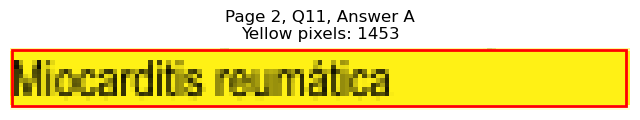

Page 2, Q11 - B: Detected box: x0=68.3, y0=733.2, x1=138.0, y1=745.8
Page 2, Q11, B: Yellow pixels: 0
Page 2, Q11, B: Total non-white pixels: 486
Page 2, Q11, B: Yellow percentage: 0.0%


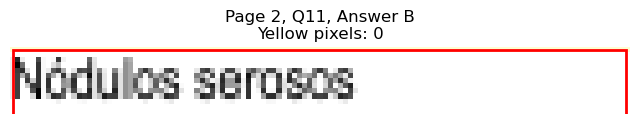

Page 2, Q11 - C: Detected box: x0=327.5, y0=720.6, x1=402.8, y1=733.2
Page 2, Q11, C: Yellow pixels: 0
Page 2, Q11, C: Total non-white pixels: 382
Page 2, Q11, C: Yellow percentage: 0.0%


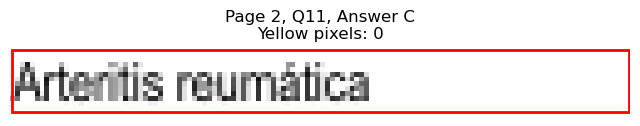

Page 2, Q11 - D: Detected box: x0=327.5, y0=733.2, x1=374.7, y1=745.8
Page 2, Q11, D: Yellow pixels: 0
Page 2, Q11, D: Total non-white pixels: 245
Page 2, Q11, D: Yellow percentage: 0.0%


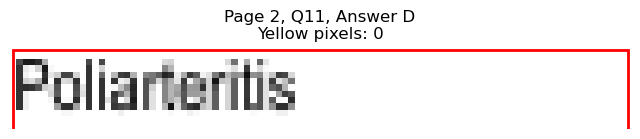


Page 2, Q11 - Selected Answer: A (based on yellow pixel count)





Page 3: Found 10 questions
Page 3, Q1 - A: Detected box: x0=68.3, y0=127.2, x1=152.5, y1=139.9
Page 3, Q1, A: Yellow pixels: 0
Page 3, Q1, A: Total non-white pixels: 438
Page 3, Q1, A: Yellow percentage: 0.0%


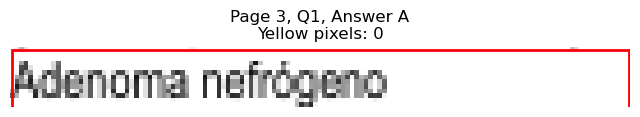

Page 3, Q1 - B: Detected box: x0=68.3, y0=139.9, x1=208.2, y1=152.6
Page 3, Q1, B: Yellow pixels: 1957
Page 3, Q1, B: Total non-white pixels: 2674
Page 3, Q1, B: Yellow percentage: 73.2%


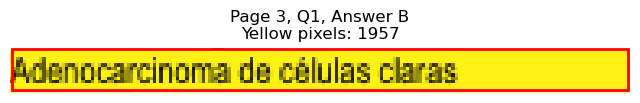

Page 3, Q1 - C: Detected box: x0=327.5, y0=127.2, x1=492.6, y1=139.9
Page 3, Q1, C: Yellow pixels: 0
Page 3, Q1, C: Total non-white pixels: 824
Page 3, Q1, C: Yellow percentage: 0.0%


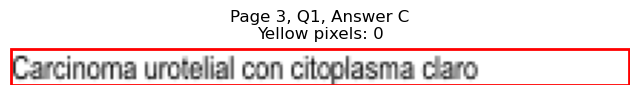

Page 3, Q1 - D: Detected box: x0=327.5, y0=139.9, x1=448.9, y1=152.6
Page 3, Q1, D: Yellow pixels: 0
Page 3, Q1, D: Total non-white pixels: 603
Page 3, Q1, D: Yellow percentage: 0.0%


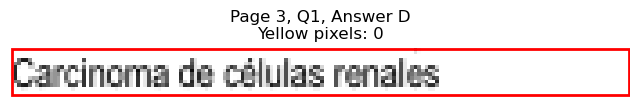


Page 3, Q1 - Selected Answer: B (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=68.3, y0=215.7, x1=129.5, y1=228.3
Page 3, Q2, A: Yellow pixels: 112
Page 3, Q2, A: Total non-white pixels: 391
Page 3, Q2, A: Yellow percentage: 28.6%


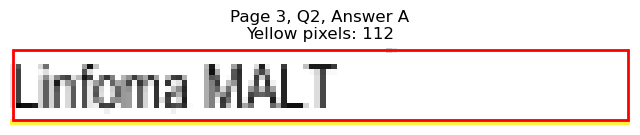

Page 3, Q2 - B: Detected box: x0=68.3, y0=228.3, x1=188.2, y1=240.9
Page 3, Q2, B: Yellow pixels: 1735
Page 3, Q2, B: Total non-white pixels: 2223
Page 3, Q2, B: Yellow percentage: 78.0%


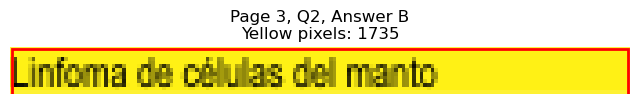

Page 3, Q2 - C: Detected box: x0=327.5, y0=215.7, x1=440.9, y1=228.3
Page 3, Q2, C: Yellow pixels: 0
Page 3, Q2, C: Total non-white pixels: 557
Page 3, Q2, C: Yellow percentage: 0.0%


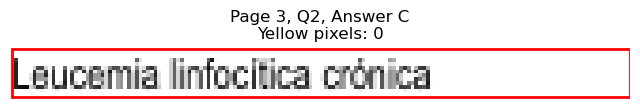

Page 3, Q2 - D: Detected box: x0=327.5, y0=228.3, x1=475.5, y1=240.9
Page 3, Q2, D: Yellow pixels: 0
Page 3, Q2, D: Total non-white pixels: 722
Page 3, Q2, D: Yellow percentage: 0.0%


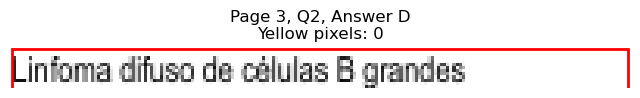


Page 3, Q2 - Selected Answer: B (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=68.3, y0=266.1, x1=166.6, y1=278.7
Page 3, Q3, A: Yellow pixels: 0
Page 3, Q3, A: Total non-white pixels: 484
Page 3, Q3, A: Yellow percentage: 0.0%


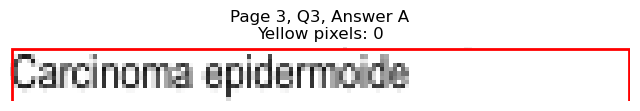

Page 3, Q3 - B: Detected box: x0=68.3, y0=278.8, x1=171.1, y1=291.5
Page 3, Q3, B: Yellow pixels: 0
Page 3, Q3, B: Total non-white pixels: 504
Page 3, Q3, B: Yellow percentage: 0.0%


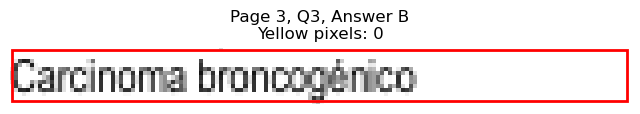

Page 3, Q3 - C: Detected box: x0=327.5, y0=266.1, x1=381.2, y1=278.7
Page 3, Q3, C: Yellow pixels: 0
Page 3, Q3, C: Total non-white pixels: 294
Page 3, Q3, C: Yellow percentage: 0.0%


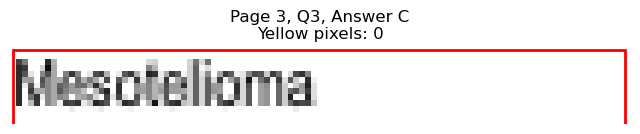

Page 3, Q3 - D: Detected box: x0=327.5, y0=278.8, x1=381.7, y1=291.5
Page 3, Q3, D: Yellow pixels: 1171
Page 3, Q3, D: Total non-white pixels: 1470
Page 3, Q3, D: Yellow percentage: 79.7%


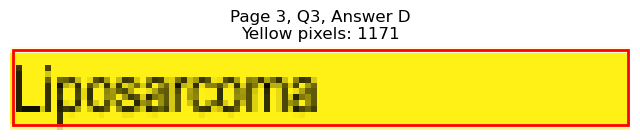


Page 3, Q3 - Selected Answer: D (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=56.6, y0=329.2, x1=65.2, y1=341.9
Page 3, Q4, A: Yellow pixels: 0
Page 3, Q4, A: Total non-white pixels: 47
Page 3, Q4, A: Yellow percentage: 0.0%


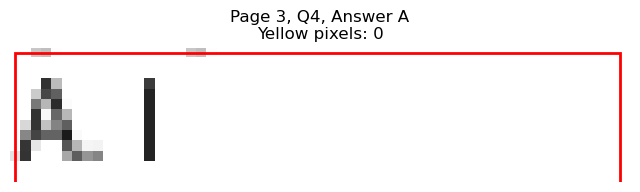

Page 3, Q4 - B: Detected box: x0=56.6, y0=341.9, x1=65.2, y1=354.6
Page 3, Q4, B: Yellow pixels: 719
Page 3, Q4, B: Total non-white pixels: 840
Page 3, Q4, B: Yellow percentage: 85.6%


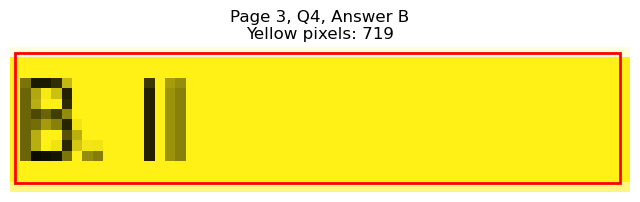

Page 3, Q4 - C: Detected box: x0=327.5, y0=329.2, x1=337.6, y1=341.9
Page 3, Q4, C: Yellow pixels: 0
Page 3, Q4, C: Total non-white pixels: 51
Page 3, Q4, C: Yellow percentage: 0.0%


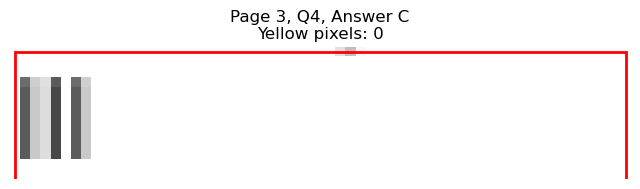

Page 3, Q4 - D: Detected box: x0=327.5, y0=341.9, x1=338.6, y1=354.6
Page 3, Q4, D: Yellow pixels: 0
Page 3, Q4, D: Total non-white pixels: 42
Page 3, Q4, D: Yellow percentage: 0.0%


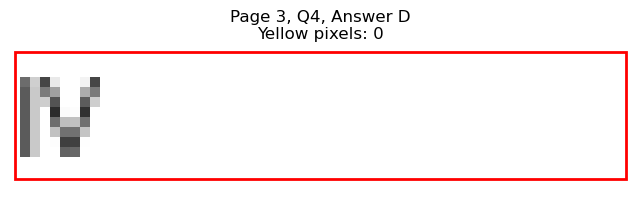


Page 3, Q4 - Selected Answer: B (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=68.3, y0=379.7, x1=144.5, y1=392.4
Page 3, Q5, A: Yellow pixels: 127
Page 3, Q5, A: Total non-white pixels: 505
Page 3, Q5, A: Yellow percentage: 25.1%


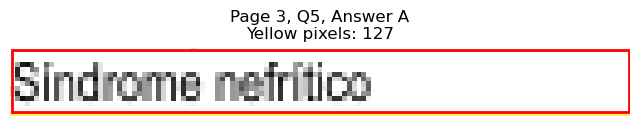

Page 3, Q5 - B: Detected box: x0=68.3, y0=392.3, x1=156.0, y1=405.0
Page 3, Q5, B: Yellow pixels: 1456
Page 3, Q5, B: Total non-white pixels: 1807
Page 3, Q5, B: Yellow percentage: 80.6%


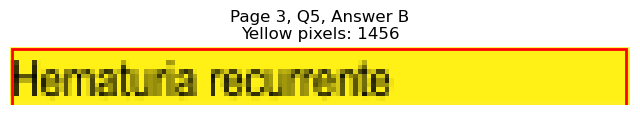

Page 3, Q5 - C: Detected box: x0=327.5, y0=379.7, x1=406.3, y1=392.4
Page 3, Q5, C: Yellow pixels: 0
Page 3, Q5, C: Total non-white pixels: 406
Page 3, Q5, C: Yellow percentage: 0.0%


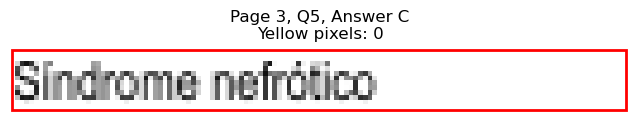

Page 3, Q5 - D: Detected box: x0=327.5, y0=392.3, x1=384.2, y1=405.0
Page 3, Q5, D: Yellow pixels: 0
Page 3, Q5, D: Total non-white pixels: 301
Page 3, Q5, D: Yellow percentage: 0.0%


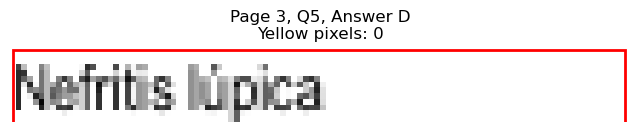


Page 3, Q5 - Selected Answer: B (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=68.3, y0=430.2, x1=137.4, y1=442.9
Page 3, Q6, A: Yellow pixels: 0
Page 3, Q6, A: Total non-white pixels: 444
Page 3, Q6, A: Yellow percentage: 0.0%


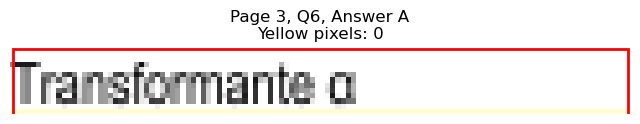

Page 3, Q6 - B: Detected box: x0=68.3, y0=442.8, x1=130.9, y1=455.5
Page 3, Q6, B: Yellow pixels: 1207
Page 3, Q6, B: Total non-white pixels: 1582
Page 3, Q6, B: Yellow percentage: 76.3%


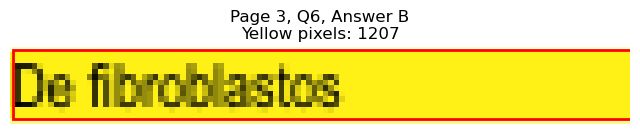

Page 3, Q6 - C: Detected box: x0=327.5, y0=430.2, x1=375.2, y1=442.9
Page 3, Q6, C: Yellow pixels: 0
Page 3, Q6, C: Total non-white pixels: 234
Page 3, Q6, C: Yellow percentage: 0.0%


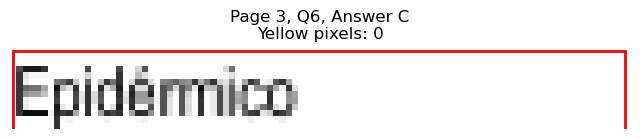

Page 3, Q6 - D: Detected box: x0=327.5, y0=442.8, x1=420.3, y1=455.5
Page 3, Q6, D: Yellow pixels: 0
Page 3, Q6, D: Total non-white pixels: 490
Page 3, Q6, D: Yellow percentage: 0.0%


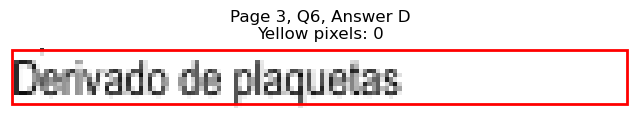


Page 3, Q6 - Selected Answer: B (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=68.3, y0=506.0, x1=121.9, y1=518.6
Page 3, Q7, A: Yellow pixels: 1122
Page 3, Q7, A: Total non-white pixels: 1456
Page 3, Q7, A: Yellow percentage: 77.1%


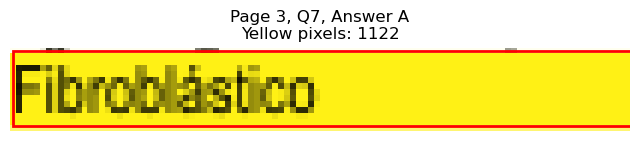

Page 3, Q7 - B: Detected box: x0=68.3, y0=518.6, x1=124.0, y1=531.2
Page 3, Q7, B: Yellow pixels: 106
Page 3, Q7, B: Total non-white pixels: 417
Page 3, Q7, B: Yellow percentage: 25.4%


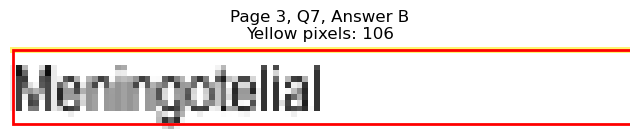

Page 3, Q7 - C: Detected box: x0=327.5, y0=506.0, x1=387.8, y1=518.6
Page 3, Q7, C: Yellow pixels: 0
Page 3, Q7, C: Total non-white pixels: 289
Page 3, Q7, C: Yellow percentage: 0.0%


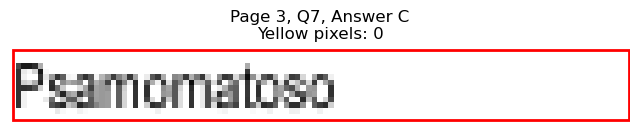

Page 3, Q7 - D: Detected box: x0=327.5, y0=518.6, x1=357.7, y1=531.2
Page 3, Q7, D: Yellow pixels: 0
Page 3, Q7, D: Total non-white pixels: 143
Page 3, Q7, D: Yellow percentage: 0.0%


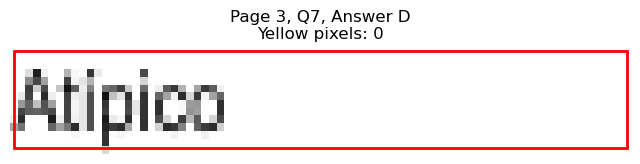


Page 3, Q7 - Selected Answer: A (based on yellow pixel count)




Page 3, Q8 - A: Detected box: x0=68.3, y0=569.1, x1=94.8, y1=581.8
Page 3, Q8, A: Yellow pixels: 0
Page 3, Q8, A: Total non-white pixels: 135
Page 3, Q8, A: Yellow percentage: 0.0%


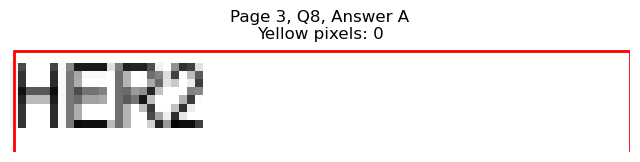

Page 3, Q8 - B: Detected box: x0=68.3, y0=581.7, x1=141.0, y1=594.4
Page 3, Q8, B: Yellow pixels: 0
Page 3, Q8, B: Total non-white pixels: 397
Page 3, Q8, B: Yellow percentage: 0.0%


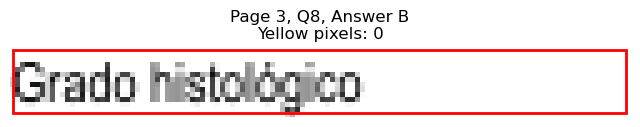

Page 3, Q8 - C: Detected box: x0=327.5, y0=569.1, x1=459.4, y1=581.8
Page 3, Q8, C: Yellow pixels: 1860
Page 3, Q8, C: Total non-white pixels: 2379
Page 3, Q8, C: Yellow percentage: 78.2%


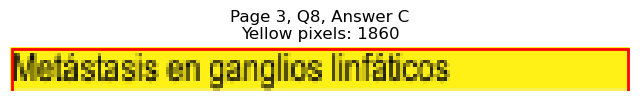

Page 3, Q8 - D: Detected box: x0=327.5, y0=581.7, x1=392.7, y1=594.4
Page 3, Q8, D: Yellow pixels: 112
Page 3, Q8, D: Total non-white pixels: 457
Page 3, Q8, D: Yellow percentage: 24.5%


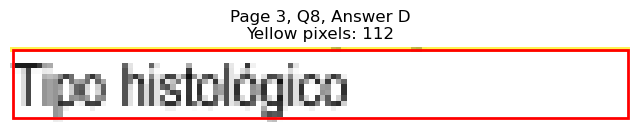


Page 3, Q8 - Selected Answer: C (based on yellow pixel count)




Page 3, Q9 - A: Detected box: x0=68.3, y0=657.5, x1=128.5, y1=670.1
Page 3, Q9, A: Yellow pixels: 0
Page 3, Q9, A: Total non-white pixels: 320
Page 3, Q9, A: Yellow percentage: 0.0%


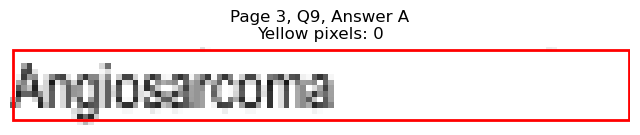

Page 3, Q9 - B: Detected box: x0=68.3, y0=670.1, x1=139.5, y1=682.7
Page 3, Q9, B: Yellow pixels: 0
Page 3, Q9, B: Total non-white pixels: 381
Page 3, Q9, B: Yellow percentage: 0.0%


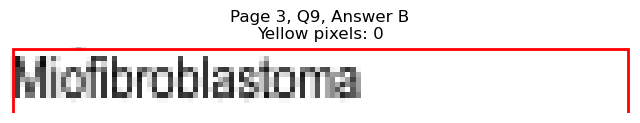

Page 3, Q9 - C: Detected box: x0=327.5, y0=657.5, x1=491.1, y1=670.1
Page 3, Q9, C: Yellow pixels: 2085
Page 3, Q9, C: Total non-white pixels: 2995
Page 3, Q9, C: Yellow percentage: 69.6%


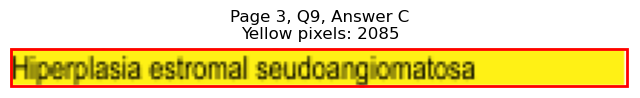

Page 3, Q9 - D: Detected box: x0=327.5, y0=670.1, x1=399.8, y1=682.7
Page 3, Q9, D: Yellow pixels: 0
Page 3, Q9, D: Total non-white pixels: 473
Page 3, Q9, D: Yellow percentage: 0.0%


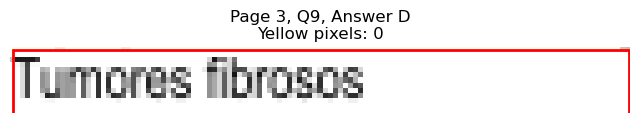


Page 3, Q9 - Selected Answer: C (based on yellow pixel count)




Page 3, Q10 - A: Detected box: x0=68.3, y0=733.2, x1=133.9, y1=745.8
Page 3, Q10, A: Yellow pixels: 1277
Page 3, Q10, A: Total non-white pixels: 1508
Page 3, Q10, A: Yellow percentage: 84.7%


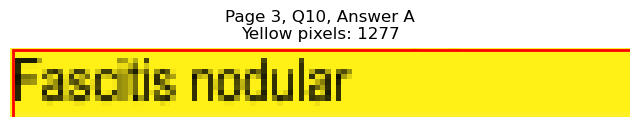

Page 3, Q10 - B: Detected box: x0=68.3, y0=745.9, x1=139.0, y1=758.6
Page 3, Q10, B: Yellow pixels: 121
Page 3, Q10, B: Total non-white pixels: 494
Page 3, Q10, B: Yellow percentage: 24.5%


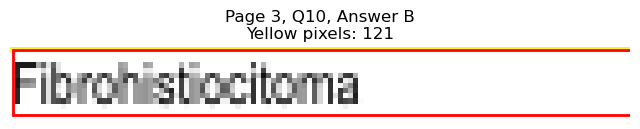

Page 3, Q10 - C: Detected box: x0=327.5, y0=733.2, x1=384.7, y1=745.8
Page 3, Q10, C: Yellow pixels: 0
Page 3, Q10, C: Total non-white pixels: 294
Page 3, Q10, C: Yellow percentage: 0.0%


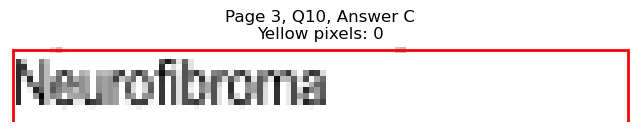

Page 3, Q10 - D: Detected box: x0=327.5, y0=745.9, x1=381.7, y1=758.6
Page 3, Q10, D: Yellow pixels: 0
Page 3, Q10, D: Total non-white pixels: 292
Page 3, Q10, D: Yellow percentage: 0.0%


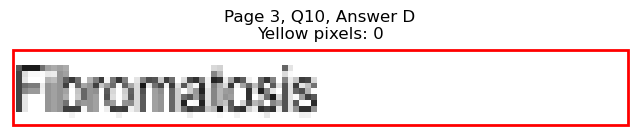


Page 3, Q10 - Selected Answer: A (based on yellow pixel count)





Page 4: Found 11 questions
Page 4, Q1 - A: Detected box: x0=68.3, y0=127.3, x1=171.1, y1=140.0
Page 4, Q1, A: Yellow pixels: 0
Page 4, Q1, A: Total non-white pixels: 515
Page 4, Q1, A: Yellow percentage: 0.0%


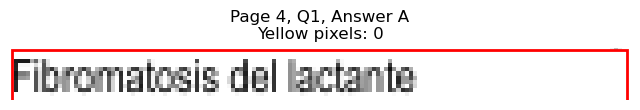

Page 4, Q1 - B: Detected box: x0=68.3, y0=139.9, x1=189.6, y1=152.6
Page 4, Q1, B: Yellow pixels: 0
Page 4, Q1, B: Total non-white pixels: 583
Page 4, Q1, B: Yellow percentage: 0.0%


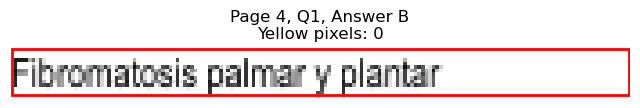

Page 4, Q1 - C: Detected box: x0=327.5, y0=127.3, x1=465.1, y1=140.0
Page 4, Q1, C: Yellow pixels: 1885
Page 4, Q1, C: Total non-white pixels: 2457
Page 4, Q1, C: Yellow percentage: 76.7%


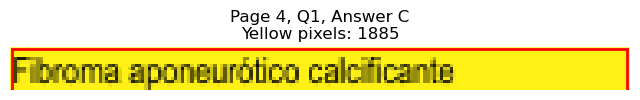

Page 4, Q1 - D: Detected box: x0=327.5, y0=139.9, x1=372.2, y1=152.6
Page 4, Q1, D: Yellow pixels: 94
Page 4, Q1, D: Total non-white pixels: 320
Page 4, Q1, D: Yellow percentage: 29.4%


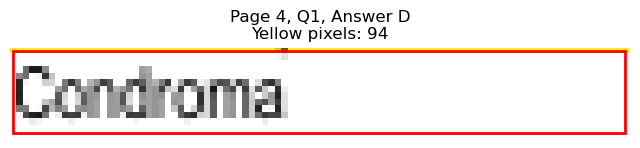


Page 4, Q1 - Selected Answer: C (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=68.3, y0=177.7, x1=118.0, y1=190.4
Page 4, Q2, A: Yellow pixels: 0
Page 4, Q2, A: Total non-white pixels: 244
Page 4, Q2, A: Yellow percentage: 0.0%


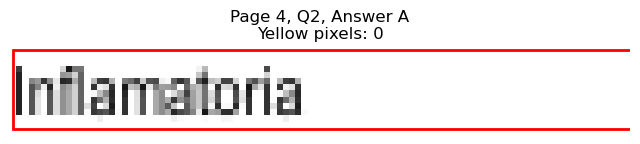

Page 4, Q2 - B: Detected box: x0=68.3, y0=190.5, x1=145.6, y1=203.1
Page 4, Q2, B: Yellow pixels: 1321
Page 4, Q2, B: Total non-white pixels: 1792
Page 4, Q2, B: Yellow percentage: 73.7%


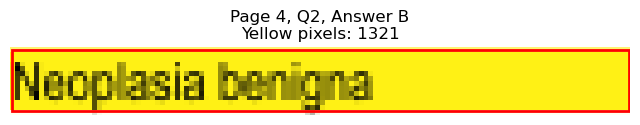

Page 4, Q2 - C: Detected box: x0=327.5, y0=177.7, x1=375.2, y1=190.4
Page 4, Q2, C: Yellow pixels: 0
Page 4, Q2, C: Total non-white pixels: 247
Page 4, Q2, C: Yellow percentage: 0.0%


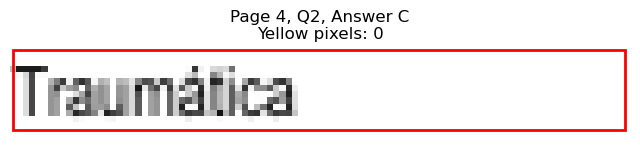

Page 4, Q2 - D: Detected box: x0=327.5, y0=190.5, x1=392.7, y1=203.1
Page 4, Q2, D: Yellow pixels: 0
Page 4, Q2, D: Total non-white pixels: 344
Page 4, Q2, D: Yellow percentage: 0.0%


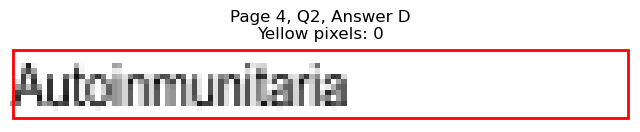


Page 4, Q2 - Selected Answer: B (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=68.3, y0=228.3, x1=88.3, y1=240.9
Page 4, Q3, A: Yellow pixels: 860
Page 4, Q3, A: Total non-white pixels: 923
Page 4, Q3, A: Yellow percentage: 93.2%


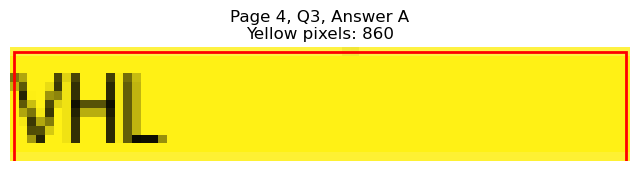

Page 4, Q3 - B: Detected box: x0=68.3, y0=240.9, x1=88.8, y1=253.5
Page 4, Q3, B: Yellow pixels: 71
Page 4, Q3, B: Total non-white pixels: 160
Page 4, Q3, B: Yellow percentage: 44.4%


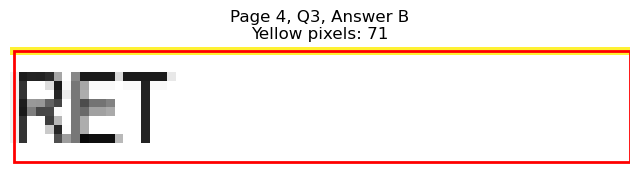

Page 4, Q3 - C: Detected box: x0=327.5, y0=228.3, x1=347.1, y1=240.9
Page 4, Q3, C: Yellow pixels: 0
Page 4, Q3, C: Total non-white pixels: 78
Page 4, Q3, C: Yellow percentage: 0.0%


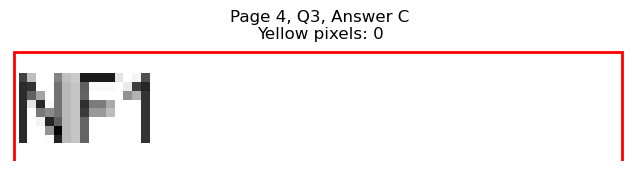

Page 4, Q3 - D: Detected box: x0=327.5, y0=240.9, x1=355.6, y1=253.5
Page 4, Q3, D: Yellow pixels: 0
Page 4, Q3, D: Total non-white pixels: 145
Page 4, Q3, D: Yellow percentage: 0.0%


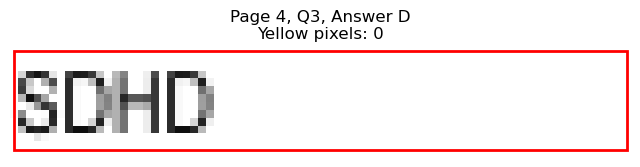


Page 4, Q3 - Selected Answer: A (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=68.3, y0=278.8, x1=152.1, y1=291.5
Page 4, Q4, A: Yellow pixels: 0
Page 4, Q4, A: Total non-white pixels: 444
Page 4, Q4, A: Yellow percentage: 0.0%


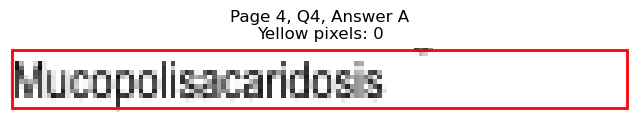

Page 4, Q4 - B: Detected box: x0=68.3, y0=291.4, x1=170.7, y1=304.1
Page 4, Q4, B: Yellow pixels: 0
Page 4, Q4, B: Total non-white pixels: 549
Page 4, Q4, B: Yellow percentage: 0.0%


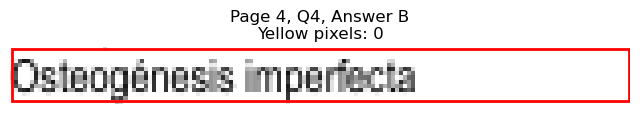

Page 4, Q4 - C: Detected box: x0=327.5, y0=278.8, x1=385.3, y1=291.5
Page 4, Q4, C: Yellow pixels: 109
Page 4, Q4, C: Total non-white pixels: 409
Page 4, Q4, C: Yellow percentage: 26.7%


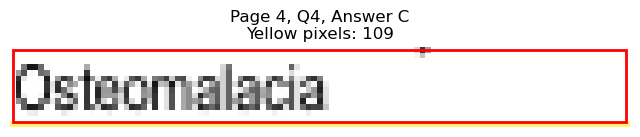

Page 4, Q4 - D: Detected box: x0=327.5, y0=291.4, x1=385.7, y1=304.1
Page 4, Q4, D: Yellow pixels: 1184
Page 4, Q4, D: Total non-white pixels: 1526
Page 4, Q4, D: Yellow percentage: 77.6%


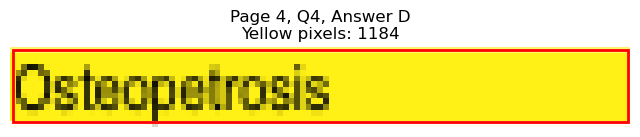


Page 4, Q4 - Selected Answer: D (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=68.3, y0=329.3, x1=113.4, y1=342.0
Page 4, Q5, A: Yellow pixels: 1078
Page 4, Q5, A: Total non-white pixels: 1248
Page 4, Q5, A: Yellow percentage: 86.4%


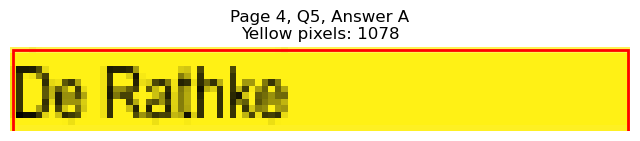

Page 4, Q5 - B: Detected box: x0=68.3, y0=341.9, x1=113.9, y1=354.6
Page 4, Q5, B: Yellow pixels: 96
Page 4, Q5, B: Total non-white pixels: 331
Page 4, Q5, B: Yellow percentage: 29.0%


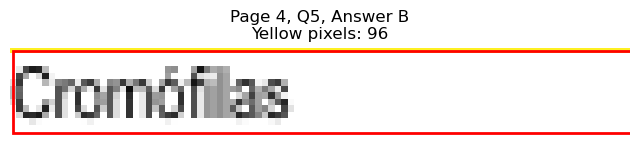

Page 4, Q5 - C: Detected box: x0=327.5, y0=329.3, x1=380.2, y1=342.0
Page 4, Q5, C: Yellow pixels: 0
Page 4, Q5, C: Total non-white pixels: 269
Page 4, Q5, C: Yellow percentage: 0.0%


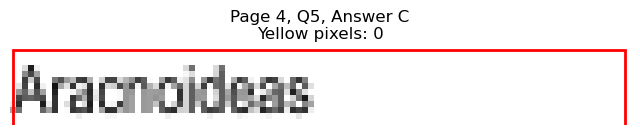

Page 4, Q5 - D: Detected box: x0=327.5, y0=341.9, x1=382.3, y1=354.6
Page 4, Q5, D: Yellow pixels: 0
Page 4, Q5, D: Total non-white pixels: 281
Page 4, Q5, D: Yellow percentage: 0.0%


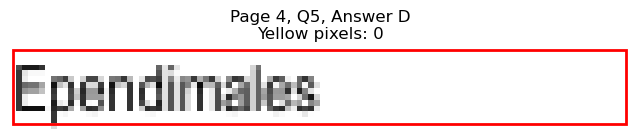


Page 4, Q5 - Selected Answer: A (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=68.3, y0=392.3, x1=88.8, y1=405.0
Page 4, Q6, A: Yellow pixels: 0
Page 4, Q6, A: Total non-white pixels: 101
Page 4, Q6, A: Yellow percentage: 0.0%


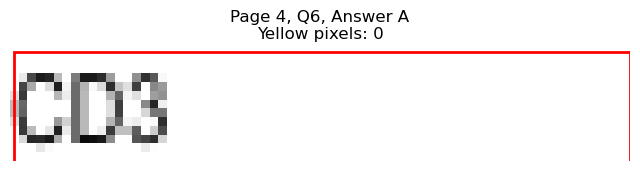

Page 4, Q6 - B: Detected box: x0=68.3, y0=405.0, x1=93.4, y1=417.7
Page 4, Q6, B: Yellow pixels: 897
Page 4, Q6, B: Total non-white pixels: 988
Page 4, Q6, B: Yellow percentage: 90.8%


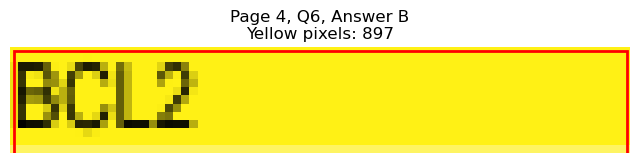

Page 4, Q6 - C: Detected box: x0=327.5, y0=392.3, x1=348.1, y1=405.0
Page 4, Q6, C: Yellow pixels: 0
Page 4, Q6, C: Total non-white pixels: 102
Page 4, Q6, C: Yellow percentage: 0.0%


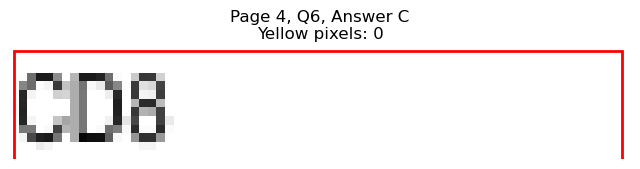

Page 4, Q6 - D: Detected box: x0=327.5, y0=405.0, x1=348.1, y1=417.7
Page 4, Q6, D: Yellow pixels: 0
Page 4, Q6, D: Total non-white pixels: 100
Page 4, Q6, D: Yellow percentage: 0.0%


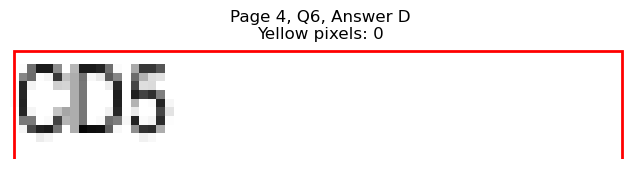


Page 4, Q6 - Selected Answer: B (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=68.3, y0=442.8, x1=118.5, y1=455.5
Page 4, Q7, A: Yellow pixels: 101
Page 4, Q7, A: Total non-white pixels: 357
Page 4, Q7, A: Yellow percentage: 28.3%


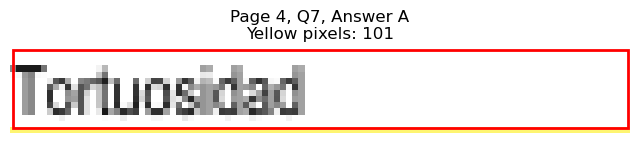

Page 4, Q7 - B: Detected box: x0=68.3, y0=455.5, x1=244.4, y1=468.1
Page 4, Q7, B: Yellow pixels: 2125
Page 4, Q7, B: Total non-white pixels: 2996
Page 4, Q7, B: Yellow percentage: 70.9%


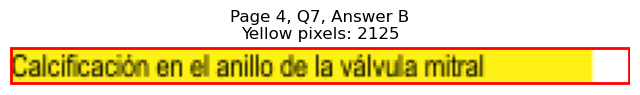

Page 4, Q7 - C: Detected box: x0=327.5, y0=442.8, x1=535.2, y1=455.5
Page 4, Q7, C: Yellow pixels: 0
Page 4, Q7, C: Total non-white pixels: 1060
Page 4, Q7, C: Yellow percentage: 0.0%


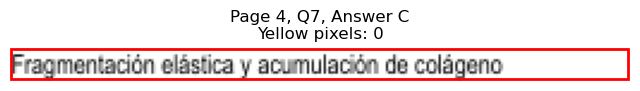

Page 4, Q7 - D: Detected box: x0=327.5, y0=455.5, x1=381.7, y1=468.1
Page 4, Q7, D: Yellow pixels: 0
Page 4, Q7, D: Total non-white pixels: 280
Page 4, Q7, D: Yellow percentage: 0.0%


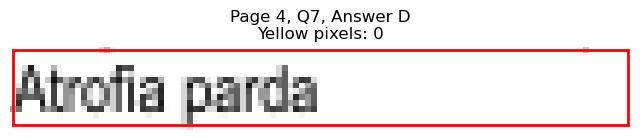


Page 4, Q7 - Selected Answer: B (based on yellow pixel count)




Page 4, Q8 - A: Detected box: x0=68.3, y0=543.9, x1=163.6, y1=556.6
Page 4, Q8, A: Yellow pixels: 0
Page 4, Q8, A: Total non-white pixels: 504
Page 4, Q8, A: Yellow percentage: 0.0%


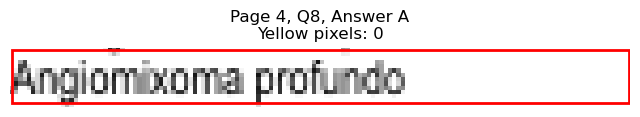

Page 4, Q8 - B: Detected box: x0=68.3, y0=556.5, x1=153.0, y1=569.2
Page 4, Q8, B: Yellow pixels: 0
Page 4, Q8, B: Total non-white pixels: 427
Page 4, Q8, B: Yellow percentage: 0.0%


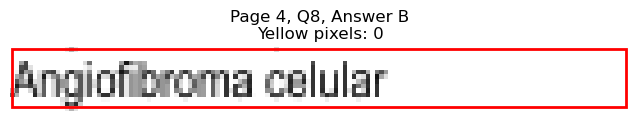

Page 4, Q8 - C: Detected box: x0=327.5, y0=543.9, x1=455.5, y1=556.6
Page 4, Q8, C: Yellow pixels: 179
Page 4, Q8, C: Total non-white pixels: 847
Page 4, Q8, C: Yellow percentage: 21.1%


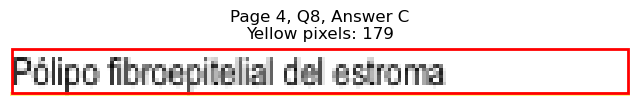

Page 4, Q8 - D: Detected box: x0=327.5, y0=556.5, x1=421.9, y1=569.2
Page 4, Q8, D: Yellow pixels: 1519
Page 4, Q8, D: Total non-white pixels: 2030
Page 4, Q8, D: Yellow percentage: 74.8%


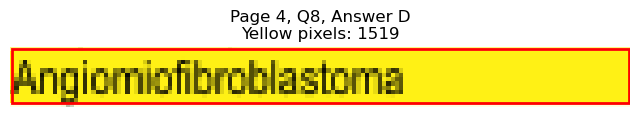


Page 4, Q8 - Selected Answer: D (based on yellow pixel count)




Page 4, Q9 - A: Detected box: x0=68.3, y0=607.0, x1=207.3, y1=619.7
Page 4, Q9, A: Yellow pixels: 0
Page 4, Q9, A: Total non-white pixels: 702
Page 4, Q9, A: Yellow percentage: 0.0%


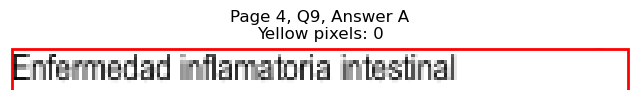

Page 4, Q9 - B: Detected box: x0=68.3, y0=619.6, x1=150.5, y1=632.3
Page 4, Q9, B: Yellow pixels: 0
Page 4, Q9, B: Total non-white pixels: 415
Page 4, Q9, B: Yellow percentage: 0.0%


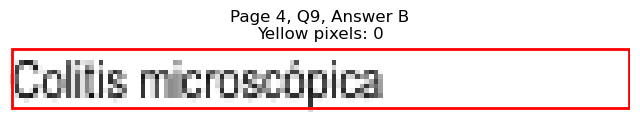

Page 4, Q9 - C: Detected box: x0=327.5, y0=607.0, x1=414.3, y1=619.7
Page 4, Q9, C: Yellow pixels: 0
Page 4, Q9, C: Total non-white pixels: 590
Page 4, Q9, C: Yellow percentage: 0.0%


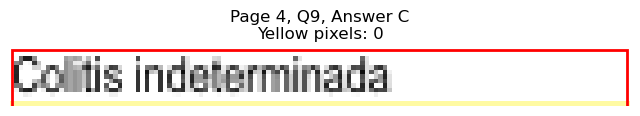

Page 4, Q9 - D: Detected box: x0=327.5, y0=619.6, x1=451.9, y1=632.3
Page 4, Q9, D: Yellow pixels: 1578
Page 4, Q9, D: Total non-white pixels: 2450
Page 4, Q9, D: Yellow percentage: 64.4%


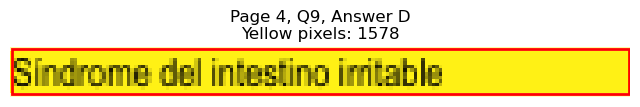


Page 4, Q9 - Selected Answer: D (based on yellow pixel count)




Page 4, Q10 - A: Detected box: x0=68.3, y0=682.8, x1=187.2, y1=695.4
Page 4, Q10, A: Yellow pixels: 0
Page 4, Q10, A: Total non-white pixels: 619
Page 4, Q10, A: Yellow percentage: 0.0%


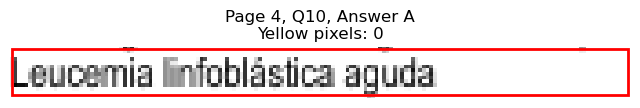

Page 4, Q10 - B: Detected box: x0=68.3, y0=695.4, x1=182.2, y1=708.0
Page 4, Q10, B: Yellow pixels: 0
Page 4, Q10, B: Total non-white pixels: 566
Page 4, Q10, B: Yellow percentage: 0.0%


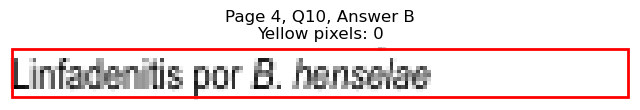

Page 4, Q10 - C: Detected box: x0=327.5, y0=682.8, x1=395.7, y1=695.4
Page 4, Q10, C: Yellow pixels: 119
Page 4, Q10, C: Total non-white pixels: 439
Page 4, Q10, C: Yellow percentage: 27.1%


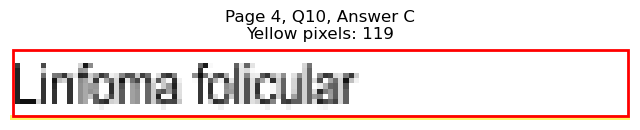

Page 4, Q10 - D: Detected box: x0=327.5, y0=695.4, x1=403.3, y1=708.0
Page 4, Q10, D: Yellow pixels: 1366
Page 4, Q10, D: Total non-white pixels: 1653
Page 4, Q10, D: Yellow percentage: 82.6%


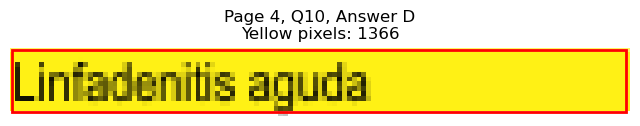


Page 4, Q10 - Selected Answer: D (based on yellow pixel count)




Page 4, Q11 - A: Detected box: x0=68.3, y0=733.2, x1=96.4, y1=745.8
Page 4, Q11, A: Yellow pixels: 0
Page 4, Q11, A: Total non-white pixels: 151
Page 4, Q11, A: Yellow percentage: 0.0%


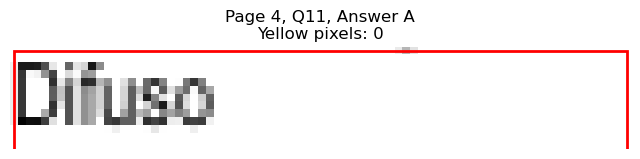

Page 4, Q11 - B: Detected box: x0=68.3, y0=745.9, x1=115.0, y1=758.6
Page 4, Q11, B: Yellow pixels: 0
Page 4, Q11, B: Total non-white pixels: 246
Page 4, Q11, B: Yellow percentage: 0.0%


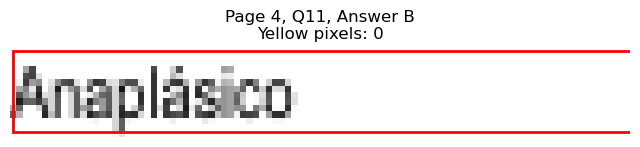

Page 4, Q11 - C: Detected box: x0=327.5, y0=733.2, x1=382.7, y1=745.8
Page 4, Q11, C: Yellow pixels: 0
Page 4, Q11, C: Total non-white pixels: 279
Page 4, Q11, C: Yellow percentage: 0.0%


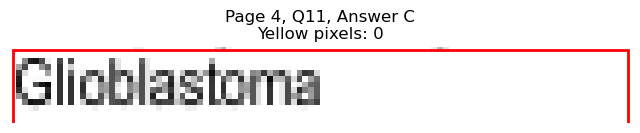

Page 4, Q11 - D: Detected box: x0=327.5, y0=745.9, x1=440.4, y1=758.6
Page 4, Q11, D: Yellow pixels: 1657
Page 4, Q11, D: Total non-white pixels: 2296
Page 4, Q11, D: Yellow percentage: 72.2%


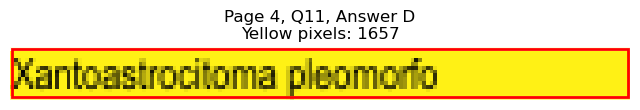


Page 4, Q11 - Selected Answer: D (based on yellow pixel count)





Page 5: Found 10 questions
Page 5, Q1 - A: Detected box: x0=68.3, y0=89.4, x1=277.0, y1=102.1
Page 5, Q1, A: Yellow pixels: 156
Page 5, Q1, A: Total non-white pixels: 1227
Page 5, Q1, A: Yellow percentage: 12.7%


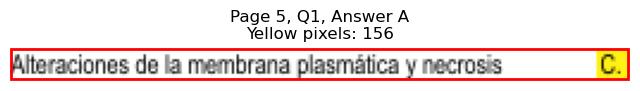

Page 5, Q1 - B: Detected box: x0=68.3, y0=102.0, x1=201.2, y1=114.7
Page 5, Q1, B: Yellow pixels: 0
Page 5, Q1, B: Total non-white pixels: 661
Page 5, Q1, B: Yellow percentage: 0.0%


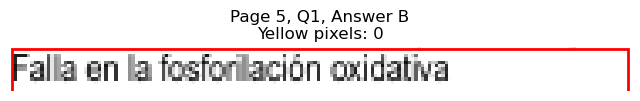

Page 5, Q1 - C: Detected box: x0=327.5, y0=89.4, x1=431.3, y1=102.1
Page 5, Q1, C: Yellow pixels: 1642
Page 5, Q1, C: Total non-white pixels: 2170
Page 5, Q1, C: Yellow percentage: 75.7%


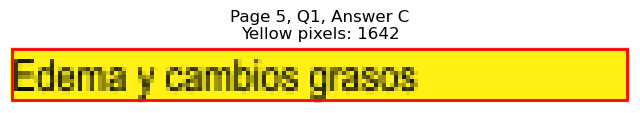

Page 5, Q1 - D: Detected box: x0=327.5, y0=102.0, x1=499.1, y1=114.7
Page 5, Q1, D: Yellow pixels: 0
Page 5, Q1, D: Total non-white pixels: 1047
Page 5, Q1, D: Yellow percentage: 0.0%


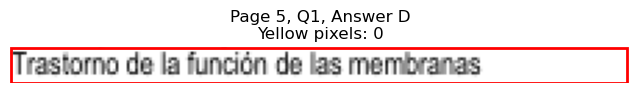


Page 5, Q1 - Selected Answer: C (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=68.3, y0=177.7, x1=173.1, y1=190.4
Page 5, Q2, A: Yellow pixels: 1449
Page 5, Q2, A: Total non-white pixels: 2184
Page 5, Q2, A: Yellow percentage: 66.3%


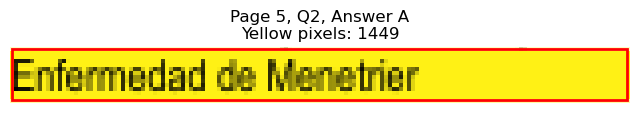

Page 5, Q2 - B: Detected box: x0=68.3, y0=190.3, x1=188.7, y1=203.0
Page 5, Q2, B: Yellow pixels: 0
Page 5, Q2, B: Total non-white pixels: 782
Page 5, Q2, B: Yellow percentage: 0.0%


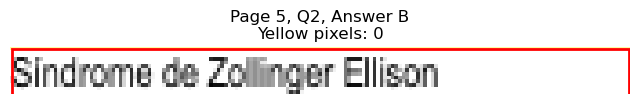

Page 5, Q2 - C: Detected box: x0=327.5, y0=177.7, x1=416.8, y1=190.4
Page 5, Q2, C: Yellow pixels: 0
Page 5, Q2, C: Total non-white pixels: 481
Page 5, Q2, C: Yellow percentage: 0.0%


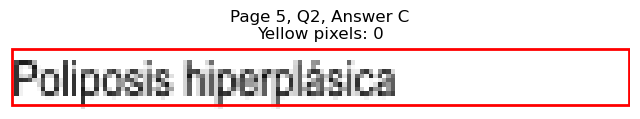

Page 5, Q2 - D: Detected box: x0=327.5, y0=190.3, x1=457.5, y1=203.0
Page 5, Q2, D: Yellow pixels: 0
Page 5, Q2, D: Total non-white pixels: 681
Page 5, Q2, D: Yellow percentage: 0.0%


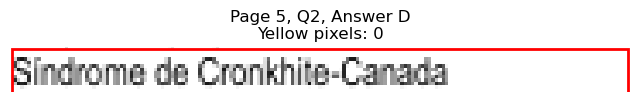


Page 5, Q2 - Selected Answer: A (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=68.3, y0=228.3, x1=184.1, y1=240.9
Page 5, Q3, A: Yellow pixels: 0
Page 5, Q3, A: Total non-white pixels: 566
Page 5, Q3, A: Yellow percentage: 0.0%


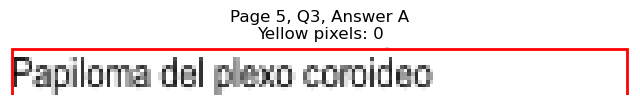

Page 5, Q3 - B: Detected box: x0=68.3, y0=240.9, x1=124.0, y1=253.5
Page 5, Q3, B: Yellow pixels: 0
Page 5, Q3, B: Total non-white pixels: 283
Page 5, Q3, B: Yellow percentage: 0.0%


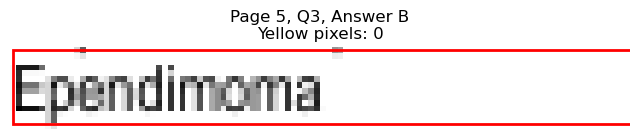

Page 5, Q3 - C: Detected box: x0=327.5, y0=695.4, x1=377.7, y1=708.0
Page 5, Q3, C: Yellow pixels: 0
Page 5, Q3, C: Total non-white pixels: 453
Page 5, Q3, C: Yellow percentage: 0.0%


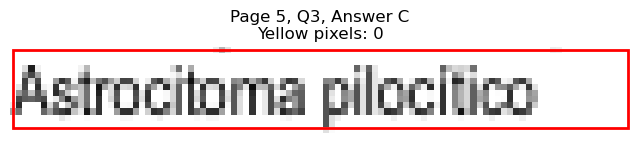

Page 5, Q3 - D: Detected box: x0=327.5, y0=240.9, x1=405.8, y1=253.5
Page 5, Q3, D: Yellow pixels: 1385
Page 5, Q3, D: Total non-white pixels: 1806
Page 5, Q3, D: Yellow percentage: 76.7%


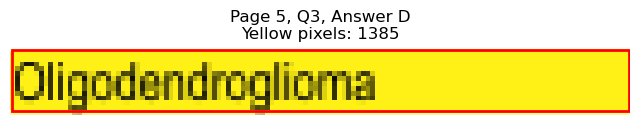


Page 5, Q3 - Selected Answer: D (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=68.3, y0=304.0, x1=193.2, y1=316.7
Page 5, Q4, A: Yellow pixels: 3
Page 5, Q4, A: Total non-white pixels: 802
Page 5, Q4, A: Yellow percentage: 0.4%


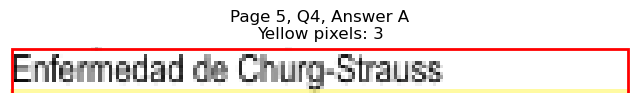

Page 5, Q4 - B: Detected box: x0=68.3, y0=316.6, x1=185.7, y1=329.3
Page 5, Q4, B: Yellow pixels: 1542
Page 5, Q4, B: Total non-white pixels: 2352
Page 5, Q4, B: Yellow percentage: 65.6%


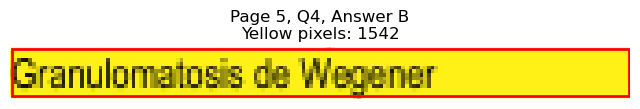

Page 5, Q4 - C: Detected box: x0=327.5, y0=304.0, x1=482.6, y1=316.7
Page 5, Q4, C: Yellow pixels: 0
Page 5, Q4, C: Total non-white pixels: 756
Page 5, Q4, C: Yellow percentage: 0.0%


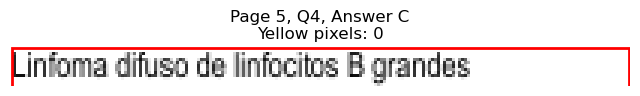

Page 5, Q4 - D: Detected box: x0=327.5, y0=316.6, x1=415.3, y1=329.3
Page 5, Q4, D: Yellow pixels: 0
Page 5, Q4, D: Total non-white pixels: 411
Page 5, Q4, D: Yellow percentage: 0.0%


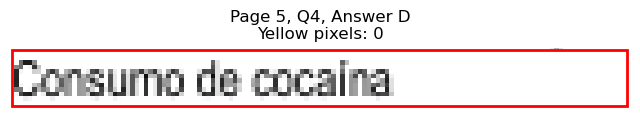


Page 5, Q4 - Selected Answer: B (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=68.3, y0=354.5, x1=122.5, y1=367.2
Page 5, Q5, A: Yellow pixels: 0
Page 5, Q5, A: Total non-white pixels: 260
Page 5, Q5, A: Yellow percentage: 0.0%


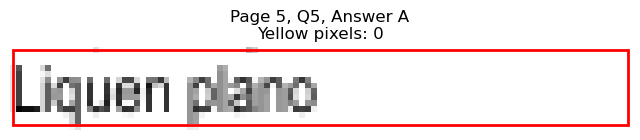

Page 5, Q5 - B: Detected box: x0=68.3, y0=367.1, x1=158.1, y1=379.8
Page 5, Q5, B: Yellow pixels: 0
Page 5, Q5, B: Total non-white pixels: 434
Page 5, Q5, B: Yellow percentage: 0.0%


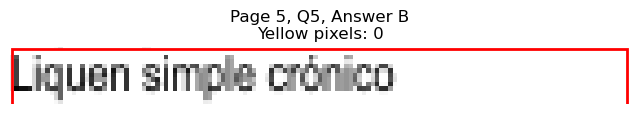

Page 5, Q5 - C: Detected box: x0=327.5, y0=354.5, x1=348.7, y1=367.2
Page 5, Q5, C: Yellow pixels: 72
Page 5, Q5, C: Total non-white pixels: 173
Page 5, Q5, C: Yellow percentage: 41.6%


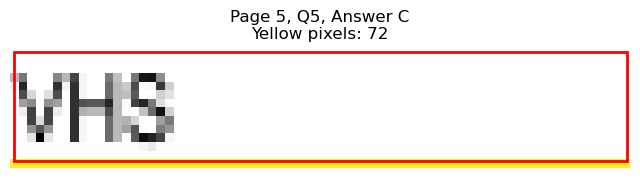

Page 5, Q5 - D: Detected box: x0=327.5, y0=367.1, x1=398.2, y1=379.8
Page 5, Q5, D: Yellow pixels: 1326
Page 5, Q5, D: Total non-white pixels: 1586
Page 5, Q5, D: Yellow percentage: 83.6%


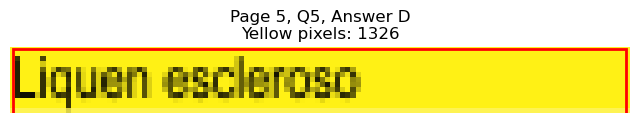


Page 5, Q5 - Selected Answer: D (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=68.3, y0=442.8, x1=207.8, y1=455.5
Page 5, Q6, A: Yellow pixels: 0
Page 5, Q6, A: Total non-white pixels: 695
Page 5, Q6, A: Yellow percentage: 0.0%


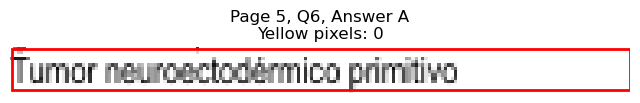

Page 5, Q6 - B: Detected box: x0=68.3, y0=455.5, x1=202.1, y1=468.1
Page 5, Q6, B: Yellow pixels: 0
Page 5, Q6, B: Total non-white pixels: 701
Page 5, Q6, B: Yellow percentage: 0.0%


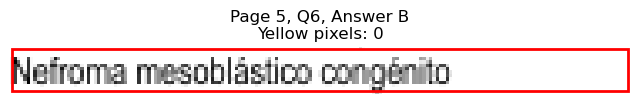

Page 5, Q6 - C: Detected box: x0=327.5, y0=442.8, x1=471.0, y1=455.5
Page 5, Q6, C: Yellow pixels: 1978
Page 5, Q6, C: Total non-white pixels: 2716
Page 5, Q6, C: Yellow percentage: 72.8%


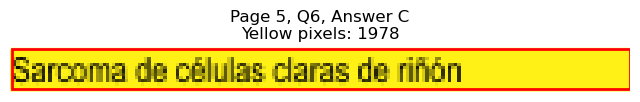

Page 5, Q6 - D: Detected box: x0=327.5, y0=455.5, x1=521.1, y1=468.1
Page 5, Q6, D: Yellow pixels: 0
Page 5, Q6, D: Total non-white pixels: 962
Page 5, Q6, D: Yellow percentage: 0.0%


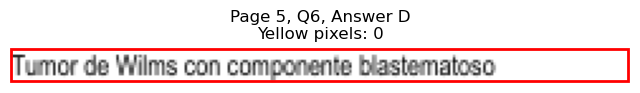


Page 5, Q6 - Selected Answer: C (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=68.3, y0=506.0, x1=135.5, y1=518.6
Page 5, Q7, A: Yellow pixels: 118
Page 5, Q7, A: Total non-white pixels: 444
Page 5, Q7, A: Yellow percentage: 26.6%


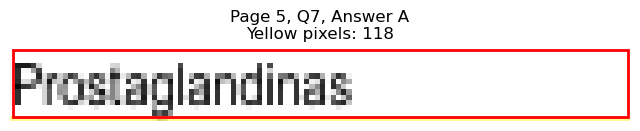

Page 5, Q7 - B: Detected box: x0=68.3, y0=518.6, x1=110.9, y1=531.2
Page 5, Q7, B: Yellow pixels: 1052
Page 5, Q7, B: Total non-white pixels: 1302
Page 5, Q7, B: Yellow percentage: 80.8%


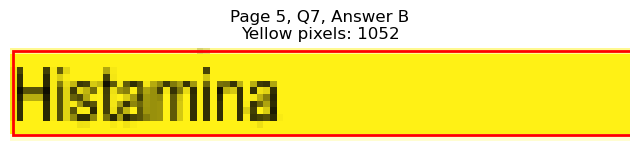

Page 5, Q7 - C: Detected box: x0=327.5, y0=506.0, x1=381.7, y1=518.6
Page 5, Q7, C: Yellow pixels: 0
Page 5, Q7, C: Total non-white pixels: 246
Page 5, Q7, C: Yellow percentage: 0.0%


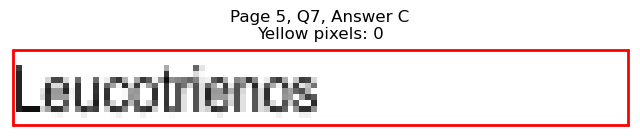

Page 5, Q7 - D: Detected box: x0=327.5, y0=518.6, x1=347.6, y1=531.2
Page 5, Q7, D: Yellow pixels: 0
Page 5, Q7, D: Total non-white pixels: 90
Page 5, Q7, D: Yellow percentage: 0.0%


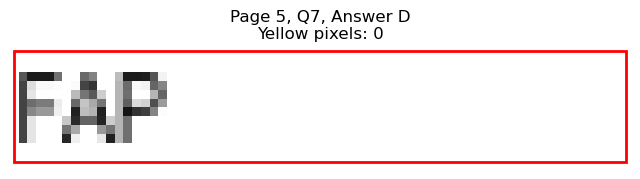


Page 5, Q7 - Selected Answer: B (based on yellow pixel count)




Page 5, Q8 - A: Detected box: x0=68.3, y0=581.7, x1=252.3, y1=594.4
Page 5, Q8, A: Yellow pixels: 0
Page 5, Q8, A: Total non-white pixels: 945
Page 5, Q8, A: Yellow percentage: 0.0%


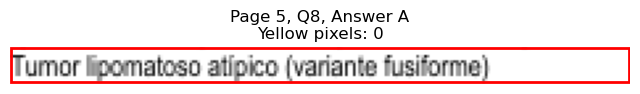

Page 5, Q8 - B: Detected box: x0=68.3, y0=594.3, x1=162.0, y1=607.0
Page 5, Q8, B: Yellow pixels: 0
Page 5, Q8, B: Total non-white pixels: 458
Page 5, Q8, B: Yellow percentage: 0.0%


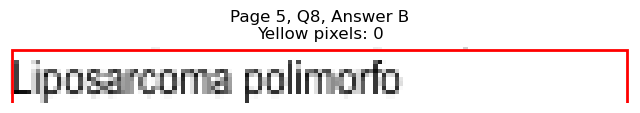

Page 5, Q8 - C: Detected box: x0=327.5, y0=581.7, x1=447.9, y1=594.4
Page 5, Q8, C: Yellow pixels: 1590
Page 5, Q8, C: Total non-white pixels: 2394
Page 5, Q8, C: Yellow percentage: 66.4%


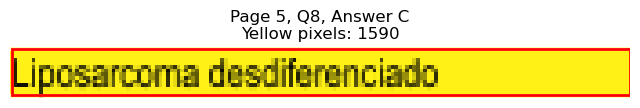

Page 5, Q8 - D: Detected box: x0=327.5, y0=594.3, x1=438.9, y1=607.0
Page 5, Q8, D: Yellow pixels: 0
Page 5, Q8, D: Total non-white pixels: 726
Page 5, Q8, D: Yellow percentage: 0.0%


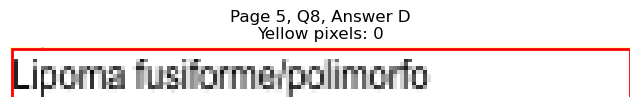


Page 5, Q8 - Selected Answer: C (based on yellow pixel count)




Page 5, Q9 - A: Detected box: x0=68.3, y0=632.2, x1=116.4, y1=644.9
Page 5, Q9, A: Yellow pixels: 1073
Page 5, Q9, A: Total non-white pixels: 1287
Page 5, Q9, A: Yellow percentage: 83.4%


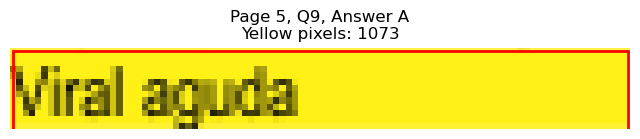

Page 5, Q9 - B: Detected box: x0=68.3, y0=644.9, x1=120.5, y1=657.5
Page 5, Q9, B: Yellow pixels: 0
Page 5, Q9, B: Total non-white pixels: 256
Page 5, Q9, B: Yellow percentage: 0.0%


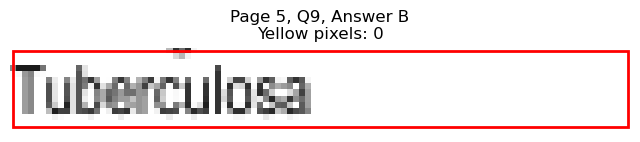

Page 5, Q9 - C: Detected box: x0=327.5, y0=632.2, x1=390.8, y1=644.9
Page 5, Q9, C: Yellow pixels: 0
Page 5, Q9, C: Total non-white pixels: 326
Page 5, Q9, C: Yellow percentage: 0.0%


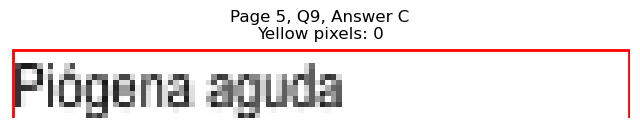

Page 5, Q9 - D: Detected box: x0=327.5, y0=644.9, x1=389.2, y1=657.5
Page 5, Q9, D: Yellow pixels: 0
Page 5, Q9, D: Total non-white pixels: 338
Page 5, Q9, D: Yellow percentage: 0.0%


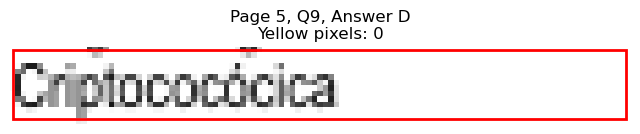


Page 5, Q9 - Selected Answer: A (based on yellow pixel count)




Page 5, Q10 - A: Detected box: x0=68.3, y0=695.4, x1=168.1, y1=708.0
Page 5, Q10, A: Yellow pixels: 1558
Page 5, Q10, A: Total non-white pixels: 1963
Page 5, Q10, A: Yellow percentage: 79.4%


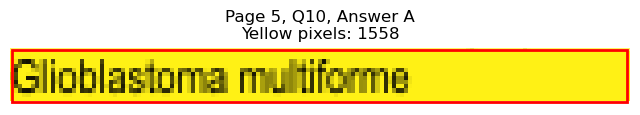

Page 5, Q10 - B: Detected box: x0=68.3, y0=708.0, x1=164.1, y1=720.6
Page 5, Q10, B: Yellow pixels: 147
Page 5, Q10, B: Total non-white pixels: 635
Page 5, Q10, B: Yellow percentage: 23.1%


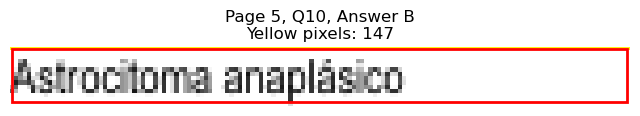

Page 5, Q10 - C: Detected box: x0=327.5, y0=695.4, x1=415.3, y1=708.0
Page 5, Q10, C: Yellow pixels: 0
Page 5, Q10, C: Total non-white pixels: 453
Page 5, Q10, C: Yellow percentage: 0.0%


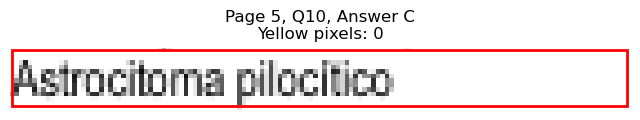

Page 5, Q10 - D: Detected box: x0=327.5, y0=240.9, x1=405.8, y1=253.5
Page 5, Q10, D: Yellow pixels: 1385
Page 5, Q10, D: Total non-white pixels: 1806
Page 5, Q10, D: Yellow percentage: 76.7%


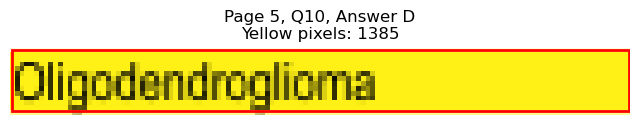


Page 5, Q10 - Selected Answer: A (based on yellow pixel count)





Page 6: Found 10 questions
Page 6, Q1 - A: Detected box: x0=68.3, y0=139.9, x1=135.5, y1=152.6
Page 6, Q1, A: Yellow pixels: 1277
Page 6, Q1, A: Total non-white pixels: 1652
Page 6, Q1, A: Yellow percentage: 77.3%


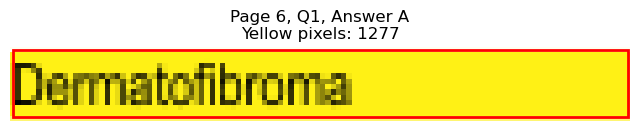

Page 6, Q1 - B: Detected box: x0=68.3, y0=152.5, x1=208.2, y1=165.2
Page 6, Q1, B: Yellow pixels: 191
Page 6, Q1, B: Total non-white pixels: 906
Page 6, Q1, B: Yellow percentage: 21.1%


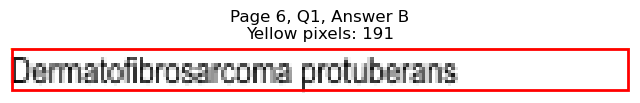

Page 6, Q1 - C: Detected box: x0=327.5, y0=139.9, x1=387.8, y1=152.6
Page 6, Q1, C: Yellow pixels: 0
Page 6, Q1, C: Total non-white pixels: 287
Page 6, Q1, C: Yellow percentage: 0.0%


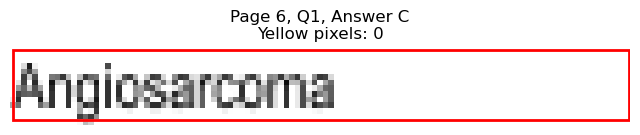

Page 6, Q1 - D: Detected box: x0=327.5, y0=152.5, x1=414.3, y1=165.2
Page 6, Q1, D: Yellow pixels: 0
Page 6, Q1, D: Total non-white pixels: 452
Page 6, Q1, D: Yellow percentage: 0.0%


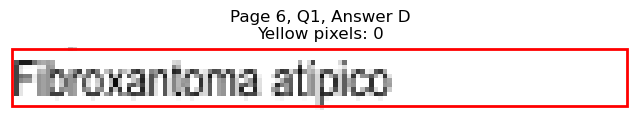


Page 6, Q1 - Selected Answer: A (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=68.3, y0=190.3, x1=121.9, y1=203.0
Page 6, Q2, A: Yellow pixels: 0
Page 6, Q2, A: Total non-white pixels: 238
Page 6, Q2, A: Yellow percentage: 0.0%


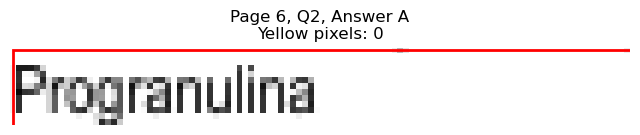

Page 6, Q2 - B: Detected box: x0=68.3, y0=202.9, x1=129.5, y1=215.6
Page 6, Q2, B: Yellow pixels: 0
Page 6, Q2, B: Total non-white pixels: 319
Page 6, Q2, B: Yellow percentage: 0.0%


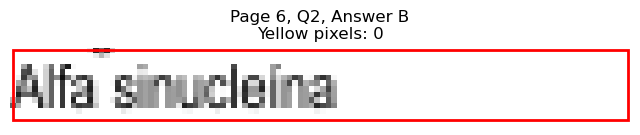

Page 6, Q2 - C: Detected box: x0=327.5, y0=190.3, x1=424.9, y1=203.0
Page 6, Q2, C: Yellow pixels: 1535
Page 6, Q2, C: Total non-white pixels: 1924
Page 6, Q2, C: Yellow percentage: 79.8%


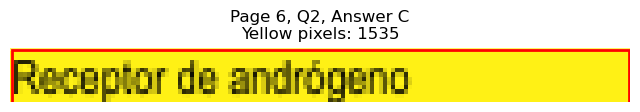

Page 6, Q2 - D: Detected box: x0=327.5, y0=202.9, x1=345.7, y1=215.6
Page 6, Q2, D: Yellow pixels: 68
Page 6, Q2, D: Total non-white pixels: 148
Page 6, Q2, D: Yellow percentage: 45.9%


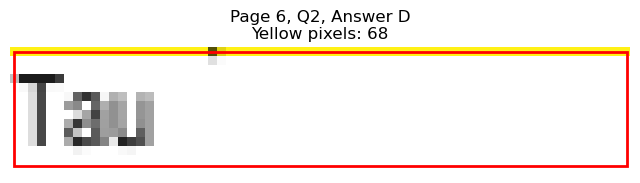


Page 6, Q2 - Selected Answer: C (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=68.3, y0=253.5, x1=132.5, y1=266.1
Page 6, Q3, A: Yellow pixels: 0
Page 6, Q3, A: Total non-white pixels: 309
Page 6, Q3, A: Yellow percentage: 0.0%


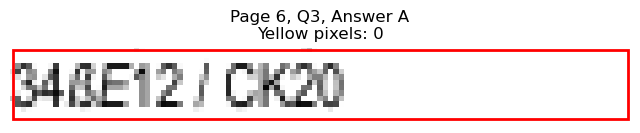

Page 6, Q3 - B: Detected box: x0=68.3, y0=266.1, x1=123.5, y1=278.7
Page 6, Q3, B: Yellow pixels: 0
Page 6, Q3, B: Total non-white pixels: 229
Page 6, Q3, B: Yellow percentage: 0.0%


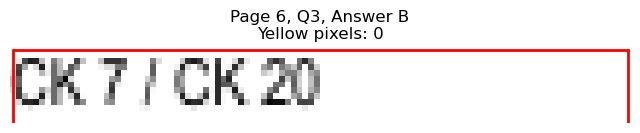

Page 6, Q3 - C: Detected box: x0=327.5, y0=253.5, x1=379.7, y1=266.1
Page 6, Q3, C: Yellow pixels: 103
Page 6, Q3, C: Total non-white pixels: 363
Page 6, Q3, C: Yellow percentage: 28.4%


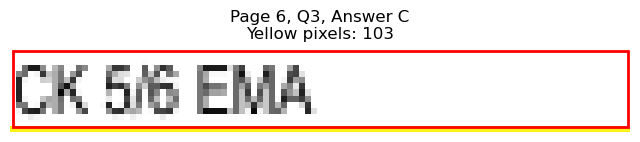

Page 6, Q3 - D: Detected box: x0=327.5, y0=266.1, x1=410.8, y1=278.7
Page 6, Q3, D: Yellow pixels: 1466
Page 6, Q3, D: Total non-white pixels: 1742
Page 6, Q3, D: Yellow percentage: 84.2%


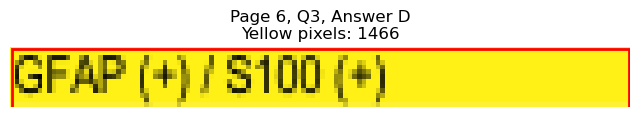


Page 6, Q3 - Selected Answer: D (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=68.3, y0=341.9, x1=203.8, y1=354.6
Page 6, Q4, A: Yellow pixels: 1869
Page 6, Q4, A: Total non-white pixels: 2604
Page 6, Q4, A: Yellow percentage: 71.8%


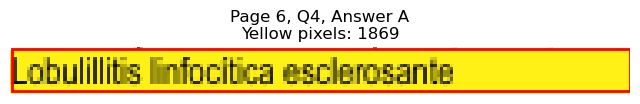

Page 6, Q4 - B: Detected box: x0=68.3, y0=354.5, x1=129.0, y1=367.2
Page 6, Q4, B: Yellow pixels: 112
Page 6, Q4, B: Total non-white pixels: 439
Page 6, Q4, B: Yellow percentage: 25.5%


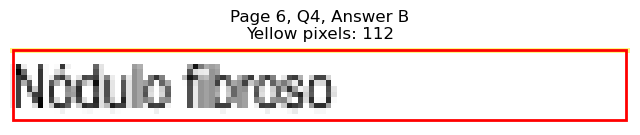

Page 6, Q4 - C: Detected box: x0=327.5, y0=455.5, x1=362.2, y1=468.1
Page 6, Q4, C: Yellow pixels: 862
Page 6, Q4, C: Total non-white pixels: 1204
Page 6, Q4, C: Yellow percentage: 71.6%


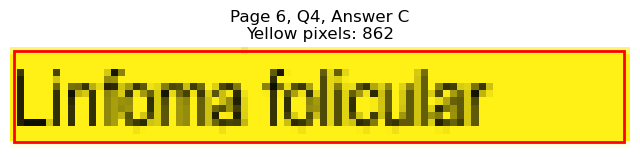

Page 6, Q4 - D: Detected box: x0=327.5, y0=354.5, x1=432.9, y1=367.2
Page 6, Q4, D: Yellow pixels: 0
Page 6, Q4, D: Total non-white pixels: 548
Page 6, Q4, D: Yellow percentage: 0.0%


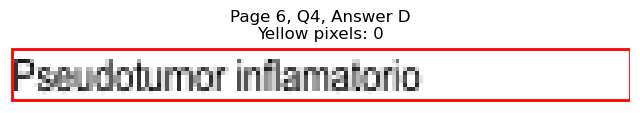


Page 6, Q4 - Selected Answer: A (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=68.3, y0=404.9, x1=118.0, y1=417.6
Page 6, Q5, A: Yellow pixels: 1113
Page 6, Q5, A: Total non-white pixels: 1400
Page 6, Q5, A: Yellow percentage: 79.5%


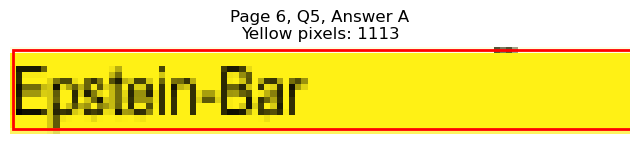

Page 6, Q5 - B: Detected box: x0=68.3, y0=417.6, x1=143.5, y1=430.3
Page 6, Q5, B: Yellow pixels: 126
Page 6, Q5, B: Total non-white pixels: 482
Page 6, Q5, B: Yellow percentage: 26.1%


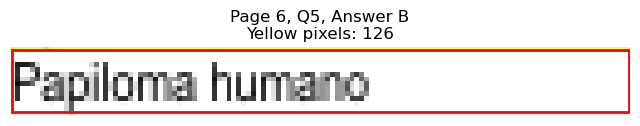

Page 6, Q5 - C: Detected box: x0=327.5, y0=404.9, x1=419.8, y1=417.6
Page 6, Q5, C: Yellow pixels: 0
Page 6, Q5, C: Total non-white pixels: 412
Page 6, Q5, C: Yellow percentage: 0.0%


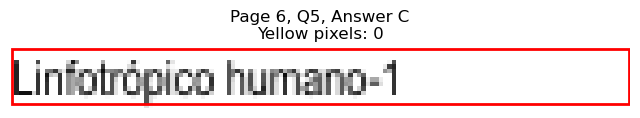

Page 6, Q5 - D: Detected box: x0=327.5, y0=417.6, x1=386.2, y1=430.3
Page 6, Q5, D: Yellow pixels: 0
Page 6, Q5, D: Total non-white pixels: 296
Page 6, Q5, D: Yellow percentage: 0.0%


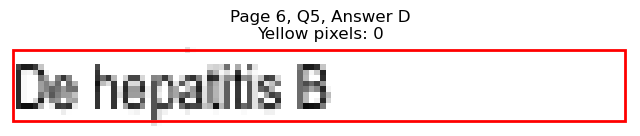


Page 6, Q5 - Selected Answer: A (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=68.3, y0=455.5, x1=226.8, y1=468.1
Page 6, Q6, A: Yellow pixels: 0
Page 6, Q6, A: Total non-white pixels: 817
Page 6, Q6, A: Yellow percentage: 0.0%


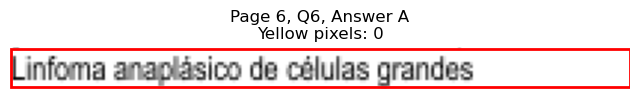

Page 6, Q6 - B: Detected box: x0=68.3, y0=468.1, x1=234.9, y1=480.7
Page 6, Q6, B: Yellow pixels: 0
Page 6, Q6, B: Total non-white pixels: 862
Page 6, Q6, B: Yellow percentage: 0.0%


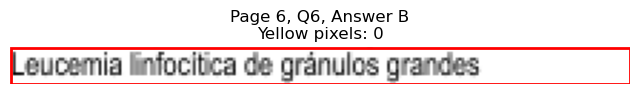

Page 6, Q6 - C: Detected box: x0=327.5, y0=455.5, x1=395.7, y1=468.1
Page 6, Q6, C: Yellow pixels: 1291
Page 6, Q6, C: Total non-white pixels: 1666
Page 6, Q6, C: Yellow percentage: 77.5%


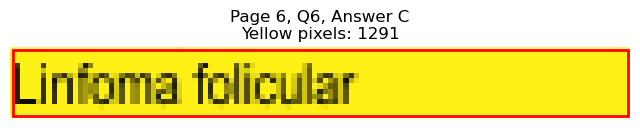

Page 6, Q6 - D: Detected box: x0=327.5, y0=468.1, x1=451.4, y1=480.7
Page 6, Q6, D: Yellow pixels: 0
Page 6, Q6, D: Total non-white pixels: 817
Page 6, Q6, D: Yellow percentage: 0.0%


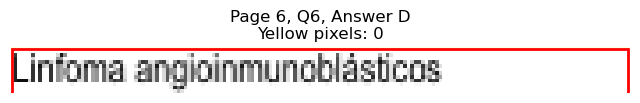


Page 6, Q6 - Selected Answer: C (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=68.3, y0=506.0, x1=241.8, y1=518.6
Page 6, Q7, A: Yellow pixels: 2131
Page 6, Q7, A: Total non-white pixels: 2996
Page 6, Q7, A: Yellow percentage: 71.1%


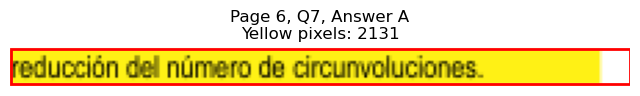

Page 6, Q7 - B: Detected box: x0=68.3, y0=518.6, x1=207.3, y1=531.2
Page 6, Q7, B: Yellow pixels: 190
Page 6, Q7, B: Total non-white pixels: 862
Page 6, Q7, B: Yellow percentage: 22.0%


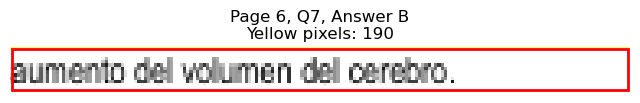

Page 6, Q7 - C: Detected box: x0=327.5, y0=506.0, x1=479.0, y1=518.6
Page 6, Q7, C: Yellow pixels: 0
Page 6, Q7, C: Total non-white pixels: 726
Page 6, Q7, C: Yellow percentage: 0.0%


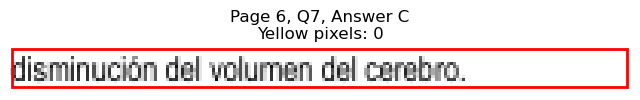

Page 6, Q7 - D: Detected box: x0=327.5, y0=518.6, x1=541.2, y1=531.2
Page 6, Q7, D: Yellow pixels: 0
Page 6, Q7, D: Total non-white pixels: 1021
Page 6, Q7, D: Yellow percentage: 0.0%


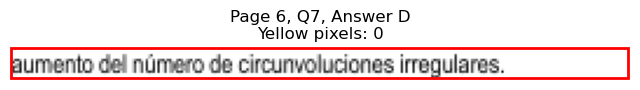


Page 6, Q7 - Selected Answer: A (based on yellow pixel count)




Page 6, Q8 - A: Detected box: x0=68.3, y0=556.5, x1=88.8, y1=569.2
Page 6, Q8, A: Yellow pixels: 0
Page 6, Q8, A: Total non-white pixels: 95
Page 6, Q8, A: Yellow percentage: 0.0%


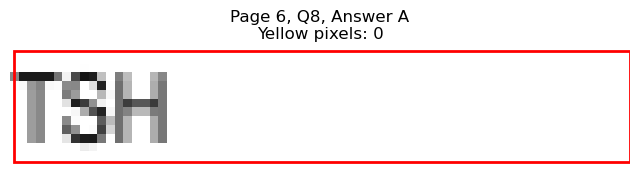

Page 6, Q8 - B: Detected box: x0=68.3, y0=569.1, x1=103.3, y1=581.8
Page 6, Q8, B: Yellow pixels: 0
Page 6, Q8, B: Total non-white pixels: 157
Page 6, Q8, B: Yellow percentage: 0.0%


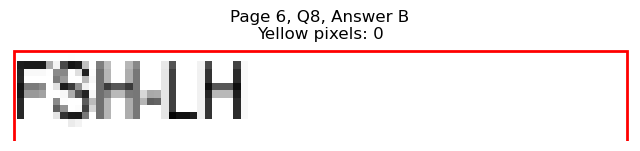

Page 6, Q8 - C: Detected box: x0=327.5, y0=556.5, x1=343.6, y1=569.2
Page 6, Q8, C: Yellow pixels: 815
Page 6, Q8, C: Total non-white pixels: 938
Page 6, Q8, C: Yellow percentage: 86.9%


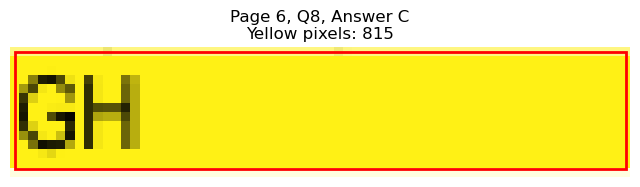

Page 6, Q8 - D: Detected box: x0=327.5, y0=569.1, x1=354.7, y1=581.8
Page 6, Q8, D: Yellow pixels: 0
Page 6, Q8, D: Total non-white pixels: 201
Page 6, Q8, D: Yellow percentage: 0.0%


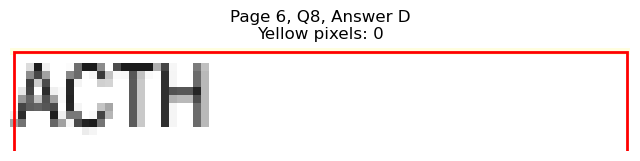


Page 6, Q8 - Selected Answer: C (based on yellow pixel count)




Page 6, Q9 - A: Detected box: x0=68.3, y0=657.5, x1=207.2, y1=670.1
Page 6, Q9, A: Yellow pixels: 1889
Page 6, Q9, A: Total non-white pixels: 2660
Page 6, Q9, A: Yellow percentage: 71.0%


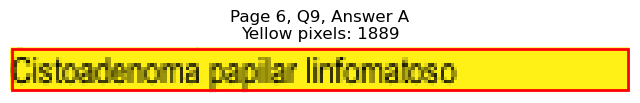

Page 6, Q9 - B: Detected box: x0=68.3, y0=670.1, x1=188.7, y1=682.7
Page 6, Q9, B: Yellow pixels: 0
Page 6, Q9, B: Total non-white pixels: 759
Page 6, Q9, B: Yellow percentage: 0.0%


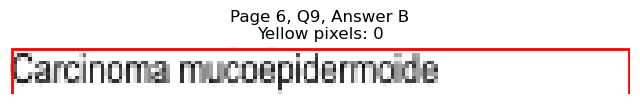

Page 6, Q9 - C: Detected box: x0=327.5, y0=657.5, x1=380.2, y1=670.1
Page 6, Q9, C: Yellow pixels: 0
Page 6, Q9, C: Total non-white pixels: 234
Page 6, Q9, C: Yellow percentage: 0.0%


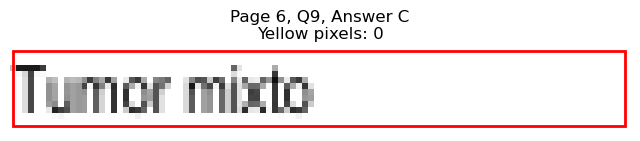

Page 6, Q9 - D: Detected box: x0=327.5, y0=670.1, x1=394.3, y1=682.7
Page 6, Q9, D: Yellow pixels: 0
Page 6, Q9, D: Total non-white pixels: 327
Page 6, Q9, D: Yellow percentage: 0.0%


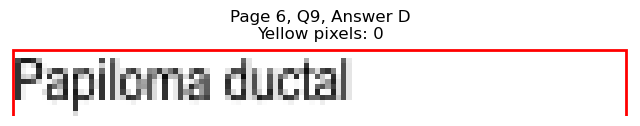


Page 6, Q9 - Selected Answer: A (based on yellow pixel count)




Page 6, Q10 - A: Detected box: x0=68.3, y0=733.2, x1=128.5, y1=745.8
Page 6, Q10, A: Yellow pixels: 2
Page 6, Q10, A: Total non-white pixels: 404
Page 6, Q10, A: Yellow percentage: 0.5%


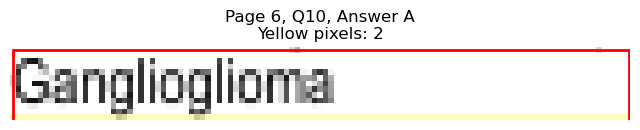

Page 6, Q10 - B: Detected box: x0=68.3, y0=745.8, x1=124.0, y1=758.4
Page 6, Q10, B: Yellow pixels: 1165
Page 6, Q10, B: Total non-white pixels: 1484
Page 6, Q10, B: Yellow percentage: 78.5%


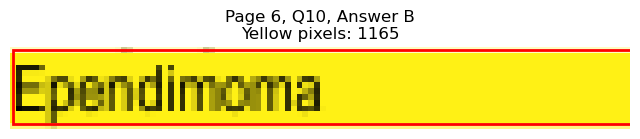

Page 6, Q10 - C: Detected box: x0=327.5, y0=733.2, x1=405.8, y1=745.8
Page 6, Q10, C: Yellow pixels: 0
Page 6, Q10, C: Total non-white pixels: 413
Page 6, Q10, C: Yellow percentage: 0.0%


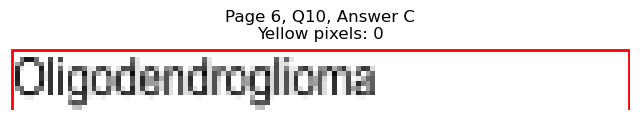

Page 6, Q10 - D: Detected box: x0=327.5, y0=745.8, x1=375.2, y1=758.4
Page 6, Q10, D: Yellow pixels: 0
Page 6, Q10, D: Total non-white pixels: 255
Page 6, Q10, D: Yellow percentage: 0.0%


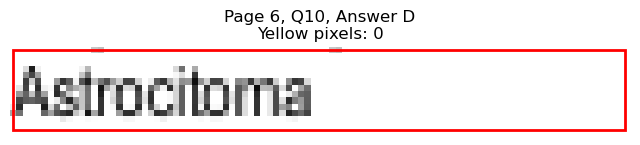


Page 6, Q10 - Selected Answer: B (based on yellow pixel count)





Page 7: Found 11 questions
Page 7, Q1 - A: Detected box: x0=68.3, y0=89.4, x1=143.1, y1=102.1
Page 7, Q1, A: Yellow pixels: 1346
Page 7, Q1, A: Total non-white pixels: 1764
Page 7, Q1, A: Yellow percentage: 76.3%


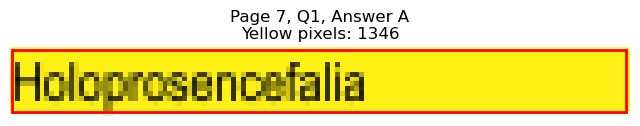

Page 7, Q1 - B: Detected box: x0=68.3, y0=102.0, x1=118.5, y1=114.7
Page 7, Q1, B: Yellow pixels: 0
Page 7, Q1, B: Total non-white pixels: 371
Page 7, Q1, B: Yellow percentage: 0.0%


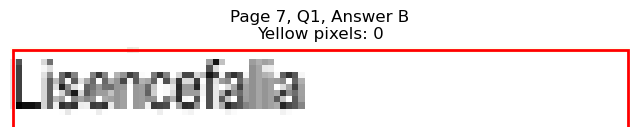

Page 7, Q1 - C: Detected box: x0=327.5, y0=89.4, x1=384.2, y1=102.1
Page 7, Q1, C: Yellow pixels: 0
Page 7, Q1, C: Total non-white pixels: 294
Page 7, Q1, C: Yellow percentage: 0.0%


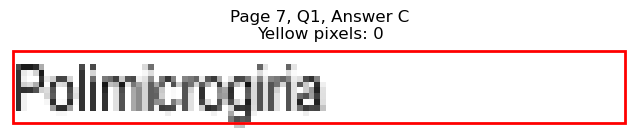

Page 7, Q1 - D: Detected box: x0=327.5, y0=102.0, x1=442.9, y1=114.7
Page 7, Q1, D: Yellow pixels: 0
Page 7, Q1, D: Total non-white pixels: 580
Page 7, Q1, D: Yellow percentage: 0.0%


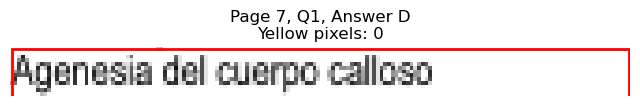


Page 7, Q1 - Selected Answer: A (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=68.3, y0=152.5, x1=91.3, y1=165.2
Page 7, Q2, A: Yellow pixels: 0
Page 7, Q2, A: Total non-white pixels: 101
Page 7, Q2, A: Yellow percentage: 0.0%


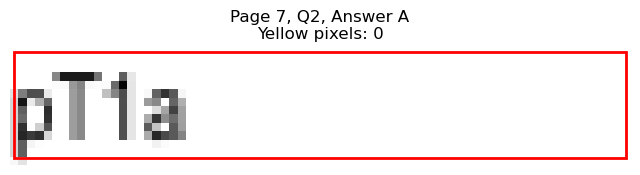

Page 7, Q2 - B: Detected box: x0=68.3, y0=165.1, x1=86.4, y1=177.8
Page 7, Q2, B: Yellow pixels: 0
Page 7, Q2, B: Total non-white pixels: 82
Page 7, Q2, B: Yellow percentage: 0.0%


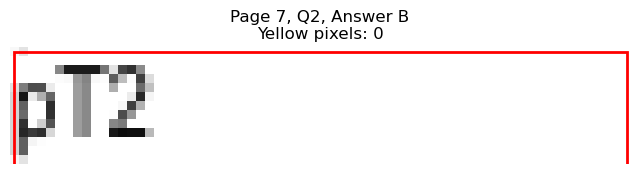

Page 7, Q2 - C: Detected box: x0=327.5, y0=152.5, x1=350.6, y1=165.2
Page 7, Q2, C: Yellow pixels: 74
Page 7, Q2, C: Total non-white pixels: 175
Page 7, Q2, C: Yellow percentage: 42.3%


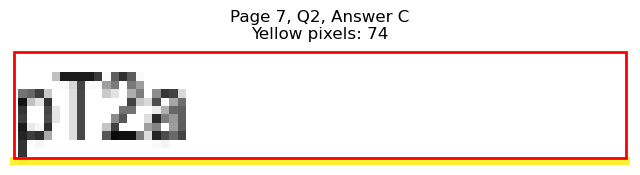

Page 7, Q2 - D: Detected box: x0=327.5, y0=165.1, x1=350.6, y1=177.8
Page 7, Q2, D: Yellow pixels: 887
Page 7, Q2, D: Total non-white pixels: 962
Page 7, Q2, D: Yellow percentage: 92.2%


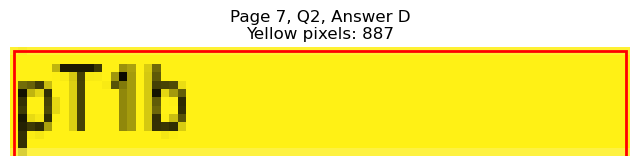


Page 7, Q2 - Selected Answer: D (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=68.3, y0=228.3, x1=140.1, y1=240.9
Page 7, Q3, A: Yellow pixels: 0
Page 7, Q3, A: Total non-white pixels: 370
Page 7, Q3, A: Yellow percentage: 0.0%


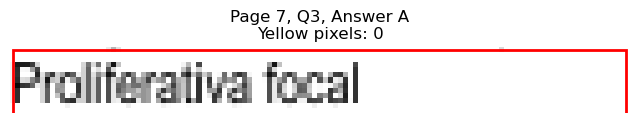

Page 7, Q3 - B: Detected box: x0=68.3, y0=240.9, x1=152.1, y1=253.5
Page 7, Q3, B: Yellow pixels: 0
Page 7, Q3, B: Total non-white pixels: 385
Page 7, Q3, B: Yellow percentage: 0.0%


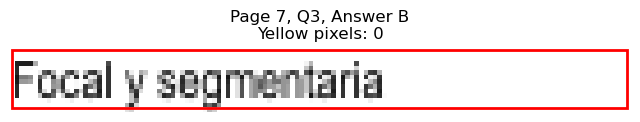

Page 7, Q3 - C: Detected box: x0=327.5, y0=228.3, x1=382.7, y1=240.9
Page 7, Q3, C: Yellow pixels: 0
Page 7, Q3, C: Total non-white pixels: 385
Page 7, Q3, C: Yellow percentage: 0.0%


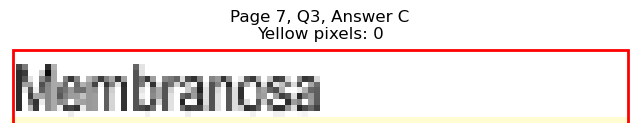

Page 7, Q3 - D: Detected box: x0=327.5, y0=240.9, x1=419.8, y1=253.5
Page 7, Q3, D: Yellow pixels: 1476
Page 7, Q3, D: Total non-white pixels: 2002
Page 7, Q3, D: Yellow percentage: 73.7%


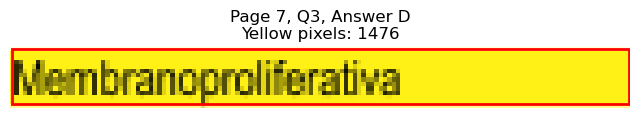


Page 7, Q3 - Selected Answer: D (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=68.3, y0=304.0, x1=125.4, y1=316.7
Page 7, Q4, A: Yellow pixels: 0
Page 7, Q4, A: Total non-white pixels: 263
Page 7, Q4, A: Yellow percentage: 0.0%


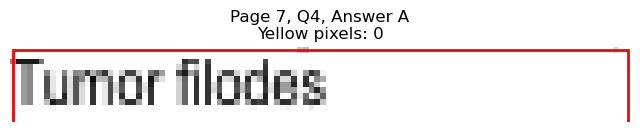

Page 7, Q4 - B: Detected box: x0=68.3, y0=316.6, x1=126.5, y1=329.3
Page 7, Q4, B: Yellow pixels: 0
Page 7, Q4, B: Total non-white pixels: 260
Page 7, Q4, B: Yellow percentage: 0.0%


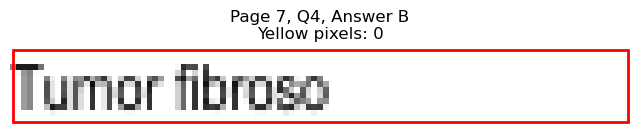

Page 7, Q4 - C: Detected box: x0=327.5, y0=304.0, x1=491.1, y1=316.7
Page 7, Q4, C: Yellow pixels: 2
Page 7, Q4, C: Total non-white pixels: 1098
Page 7, Q4, C: Yellow percentage: 0.2%


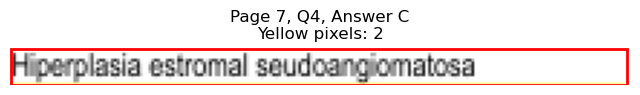

Page 7, Q4 - D: Detected box: x0=327.5, y0=316.6, x1=388.3, y1=329.3
Page 7, Q4, D: Yellow pixels: 1093
Page 7, Q4, D: Total non-white pixels: 1568
Page 7, Q4, D: Yellow percentage: 69.7%


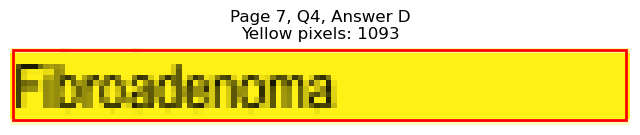


Page 7, Q4 - Selected Answer: D (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=68.3, y0=354.5, x1=90.9, y1=367.2
Page 7, Q5, A: Yellow pixels: 0
Page 7, Q5, A: Total non-white pixels: 128
Page 7, Q5, A: Yellow percentage: 0.0%


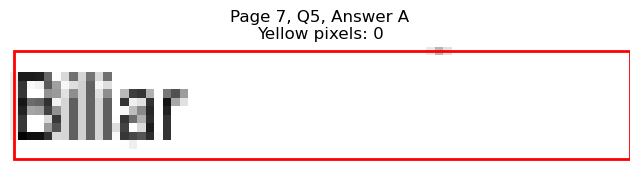

Page 7, Q5 - B: Detected box: x0=68.3, y0=367.1, x1=106.9, y1=379.8
Page 7, Q5, B: Yellow pixels: 0
Page 7, Q5, B: Total non-white pixels: 197
Page 7, Q5, B: Yellow percentage: 0.0%


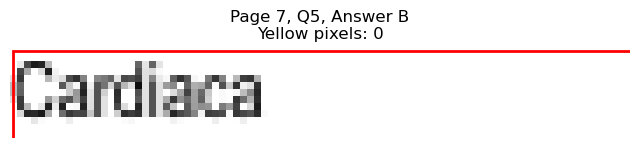

Page 7, Q5 - C: Detected box: x0=327.5, y0=354.5, x1=473.0, y1=367.2
Page 7, Q5, C: Yellow pixels: 197
Page 7, Q5, C: Total non-white pixels: 914
Page 7, Q5, C: Yellow percentage: 21.6%


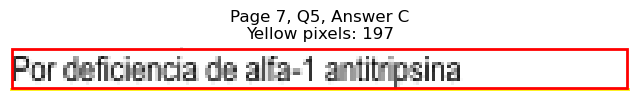

Page 7, Q5 - D: Detected box: x0=327.5, y0=367.1, x1=412.7, y1=379.8
Page 7, Q5, D: Yellow pixels: 1440
Page 7, Q5, D: Total non-white pixels: 1768
Page 7, Q5, D: Yellow percentage: 81.4%


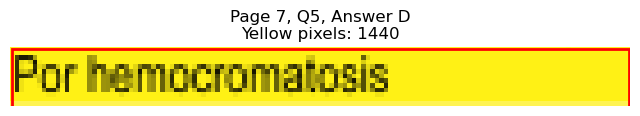


Page 7, Q5 - Selected Answer: D (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=68.3, y0=442.8, x1=195.3, y1=455.5
Page 7, Q6, A: Yellow pixels: 0
Page 7, Q6, A: Total non-white pixels: 670
Page 7, Q6, A: Yellow percentage: 0.0%


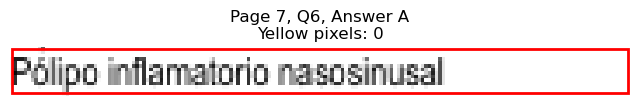

Page 7, Q6 - B: Detected box: x0=68.3, y0=455.5, x1=239.3, y1=468.1
Page 7, Q6, B: Yellow pixels: 0
Page 7, Q6, B: Total non-white pixels: 814
Page 7, Q6, B: Yellow percentage: 0.0%


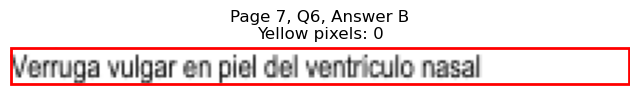

Page 7, Q6 - C: Detected box: x0=327.5, y0=442.8, x1=453.9, y1=455.5
Page 7, Q6, C: Yellow pixels: 1830
Page 7, Q6, C: Total non-white pixels: 2478
Page 7, Q6, C: Yellow percentage: 73.8%


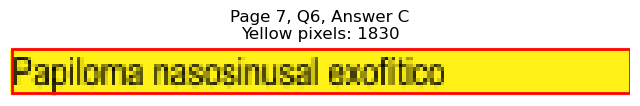

Page 7, Q6 - D: Detected box: x0=327.5, y0=455.5, x1=391.3, y1=468.1
Page 7, Q6, D: Yellow pixels: 0
Page 7, Q6, D: Total non-white pixels: 353
Page 7, Q6, D: Yellow percentage: 0.0%


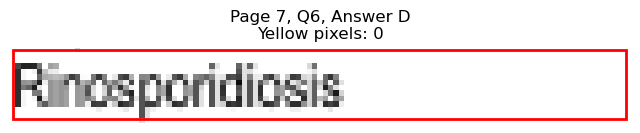


Page 7, Q6 - Selected Answer: C (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=68.3, y0=493.4, x1=146.5, y1=506.0
Page 7, Q7, A: Yellow pixels: 1380
Page 7, Q7, A: Total non-white pixels: 1677
Page 7, Q7, A: Yellow percentage: 82.3%


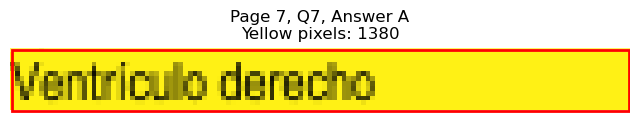

Page 7, Q7 - B: Detected box: x0=68.3, y0=506.0, x1=150.5, y1=518.6
Page 7, Q7, B: Yellow pixels: 133
Page 7, Q7, B: Total non-white pixels: 555
Page 7, Q7, B: Yellow percentage: 24.0%


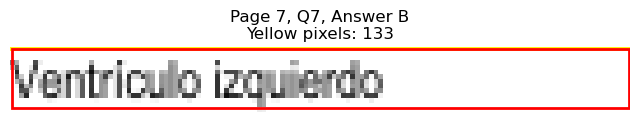

Page 7, Q7 - C: Detected box: x0=327.5, y0=493.4, x1=398.2, y1=506.0
Page 7, Q7, C: Yellow pixels: 0
Page 7, Q7, C: Total non-white pixels: 339
Page 7, Q7, C: Yellow percentage: 0.0%


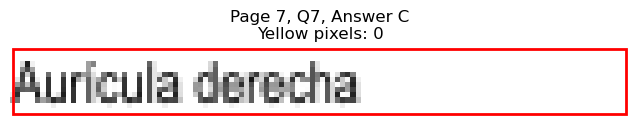

Page 7, Q7 - D: Detected box: x0=327.5, y0=506.0, x1=402.3, y1=518.6
Page 7, Q7, D: Yellow pixels: 0
Page 7, Q7, D: Total non-white pixels: 368
Page 7, Q7, D: Yellow percentage: 0.0%


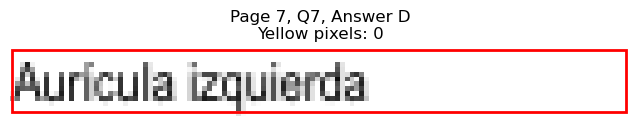


Page 7, Q7 - Selected Answer: A (based on yellow pixel count)




Page 7, Q8 - A: Detected box: x0=68.3, y0=569.1, x1=214.2, y1=581.8
Page 7, Q8, A: Yellow pixels: 0
Page 7, Q8, A: Total non-white pixels: 763
Page 7, Q8, A: Yellow percentage: 0.0%


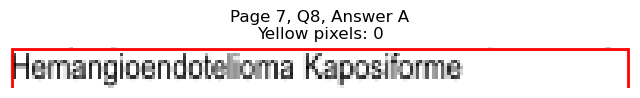

Page 7, Q8 - B: Detected box: x0=68.3, y0=581.7, x1=150.0, y1=594.4
Page 7, Q8, B: Yellow pixels: 0
Page 7, Q8, B: Total non-white pixels: 386
Page 7, Q8, B: Yellow percentage: 0.0%


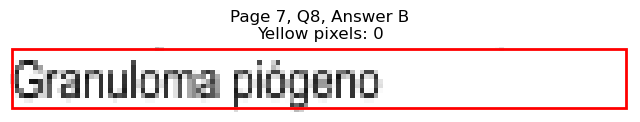

Page 7, Q8 - C: Detected box: x0=327.5, y0=569.1, x1=408.8, y1=581.8
Page 7, Q8, C: Yellow pixels: 1407
Page 7, Q8, C: Total non-white pixels: 1716
Page 7, Q8, C: Yellow percentage: 82.0%


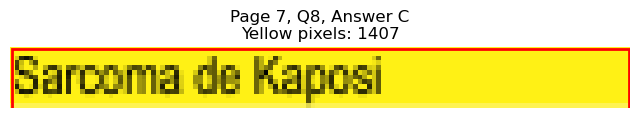

Page 7, Q8 - D: Detected box: x0=327.5, y0=581.7, x1=387.8, y1=594.4
Page 7, Q8, D: Yellow pixels: 111
Page 7, Q8, D: Total non-white pixels: 398
Page 7, Q8, D: Yellow percentage: 27.9%


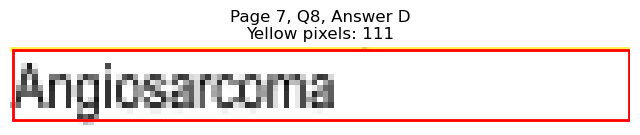


Page 7, Q8 - Selected Answer: C (based on yellow pixel count)




Page 7, Q9 - A: Detected box: x0=68.3, y0=619.6, x1=96.4, y1=632.3
Page 7, Q9, A: Yellow pixels: 855
Page 7, Q9, A: Total non-white pixels: 1106
Page 7, Q9, A: Yellow percentage: 77.3%


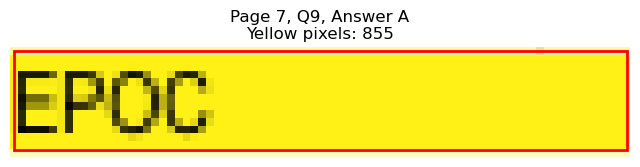

Page 7, Q9 - B: Detected box: x0=68.3, y0=632.2, x1=217.2, y1=644.9
Page 7, Q9, B: Yellow pixels: 0
Page 7, Q9, B: Total non-white pixels: 914
Page 7, Q9, B: Yellow percentage: 0.0%


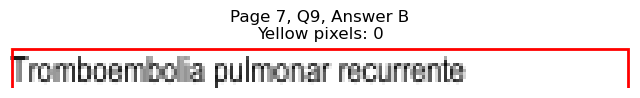

Page 7, Q9 - C: Detected box: x0=327.5, y0=619.6, x1=372.7, y1=632.3
Page 7, Q9, C: Yellow pixels: 0
Page 7, Q9, C: Total non-white pixels: 240
Page 7, Q9, C: Yellow percentage: 0.0%


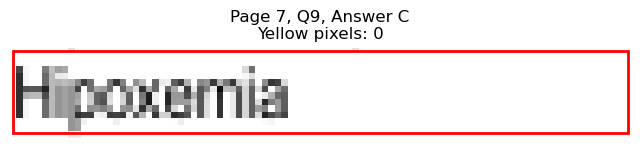

Page 7, Q9 - D: Detected box: x0=327.5, y0=632.2, x1=499.2, y1=644.9
Page 7, Q9, D: Yellow pixels: 0
Page 7, Q9, D: Total non-white pixels: 848
Page 7, Q9, D: Yellow percentage: 0.0%


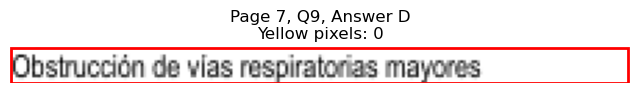


Page 7, Q9 - Selected Answer: A (based on yellow pixel count)




Page 7, Q10 - A: Detected box: x0=68.3, y0=695.4, x1=217.7, y1=708.0
Page 7, Q10, A: Yellow pixels: 200
Page 7, Q10, A: Total non-white pixels: 1216
Page 7, Q10, A: Yellow percentage: 16.4%


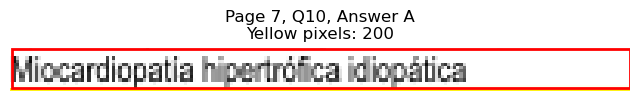

Page 7, Q10 - B: Detected box: x0=68.3, y0=708.0, x1=204.8, y1=720.6
Page 7, Q10, B: Yellow pixels: 1879
Page 7, Q10, B: Total non-white pixels: 2618
Page 7, Q10, B: Yellow percentage: 71.8%


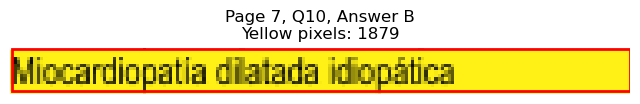

Page 7, Q10 - C: Detected box: x0=327.5, y0=695.4, x1=427.9, y1=708.0
Page 7, Q10, C: Yellow pixels: 0
Page 7, Q10, C: Total non-white pixels: 530
Page 7, Q10, C: Yellow percentage: 0.0%


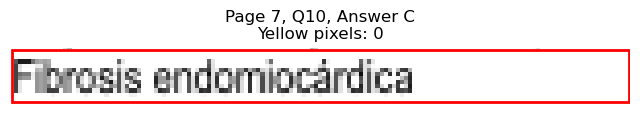

Page 7, Q10 - D: Detected box: x0=327.5, y0=708.0, x1=422.8, y1=720.6
Page 7, Q10, D: Yellow pixels: 0
Page 7, Q10, D: Total non-white pixels: 467
Page 7, Q10, D: Yellow percentage: 0.0%


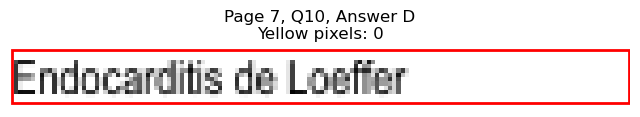


Page 7, Q10 - Selected Answer: B (based on yellow pixel count)




Page 7, Q11 - A: Detected box: x0=68.3, y0=745.8, x1=82.8, y1=758.4
Page 7, Q11, A: Yellow pixels: 0
Page 7, Q11, A: Total non-white pixels: 63
Page 7, Q11, A: Yellow percentage: 0.0%


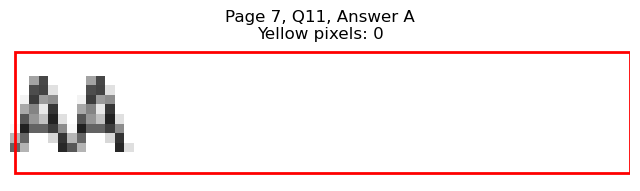

Page 7, Q11 - B: Detected box: x0=68.3, y0=758.5, x1=94.3, y1=771.2
Page 7, Q11, B: Yellow pixels: 917
Page 7, Q11, B: Total non-white pixels: 1078
Page 7, Q11, B: Yellow percentage: 85.1%


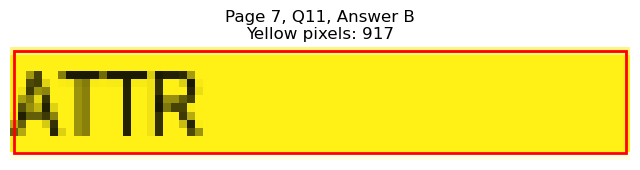

Page 7, Q11 - C: Detected box: x0=327.5, y0=745.8, x1=341.1, y1=758.4
Page 7, Q11, C: Yellow pixels: 0
Page 7, Q11, C: Total non-white pixels: 43
Page 7, Q11, C: Yellow percentage: 0.0%


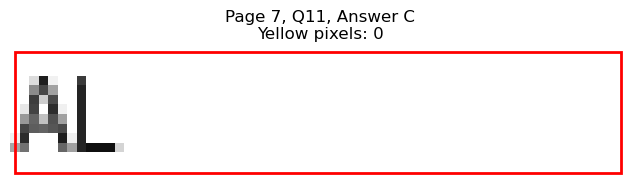

Page 7, Q11 - D: Detected box: x0=327.5, y0=758.5, x1=342.1, y1=771.2
Page 7, Q11, D: Yellow pixels: 0
Page 7, Q11, D: Total non-white pixels: 68
Page 7, Q11, D: Yellow percentage: 0.0%


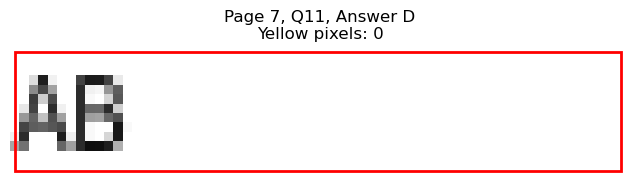


Page 7, Q11 - Selected Answer: B (based on yellow pixel count)





Page 8: Found 12 questions
Page 8, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=156.0, y1=127.3
Page 8, Q1, A: Yellow pixels: 0
Page 8, Q1, A: Total non-white pixels: 476
Page 8, Q1, A: Yellow percentage: 0.0%


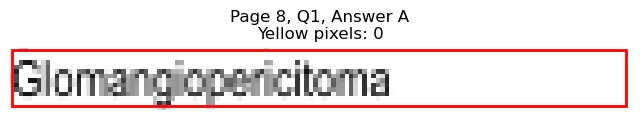

Page 8, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=119.9, y1=139.9
Page 8, Q1, B: Yellow pixels: 0
Page 8, Q1, B: Total non-white pixels: 291
Page 8, Q1, B: Yellow percentage: 0.0%


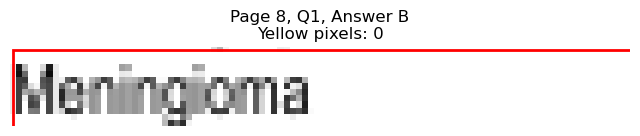

Page 8, Q1 - C: Detected box: x0=327.5, y0=114.6, x1=419.3, y1=127.3
Page 8, Q1, C: Yellow pixels: 1376
Page 8, Q1, C: Total non-white pixels: 2002
Page 8, Q1, C: Yellow percentage: 68.7%


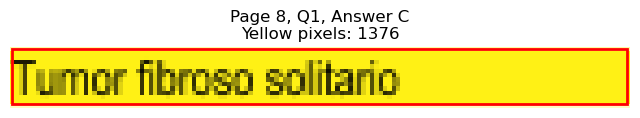

Page 8, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=385.3, y1=139.9
Page 8, Q1, D: Yellow pixels: 0
Page 8, Q1, D: Total non-white pixels: 403
Page 8, Q1, D: Yellow percentage: 0.0%


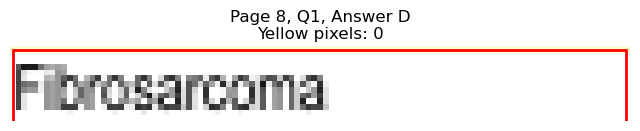


Page 8, Q1 - Selected Answer: C (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=68.3, y0=190.5, x1=102.4, y1=203.1
Page 8, Q2, A: Yellow pixels: 0
Page 8, Q2, A: Total non-white pixels: 146
Page 8, Q2, A: Yellow percentage: 0.0%


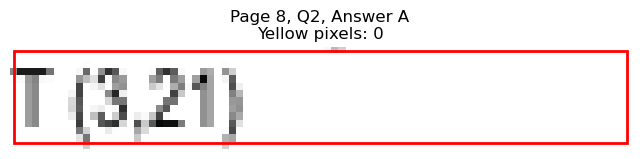

Page 8, Q2 - B: Detected box: x0=68.3, y0=203.1, x1=154.6, y1=215.7
Page 8, Q2, B: Yellow pixels: 0
Page 8, Q2, B: Total non-white pixels: 383
Page 8, Q2, B: Yellow percentage: 0.0%


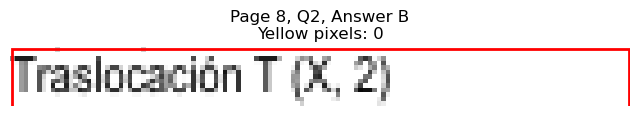

Page 8, Q2 - C: Detected box: x0=327.5, y0=190.5, x1=381.7, y1=203.1
Page 8, Q2, C: Yellow pixels: 105
Page 8, Q2, C: Total non-white pixels: 312
Page 8, Q2, C: Yellow percentage: 33.7%


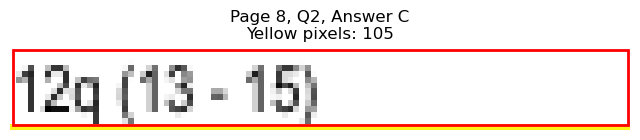

Page 8, Q2 - D: Detected box: x0=327.5, y0=203.1, x1=381.2, y1=215.7
Page 8, Q2, D: Yellow pixels: 1251
Page 8, Q2, D: Total non-white pixels: 1365
Page 8, Q2, D: Yellow percentage: 91.6%


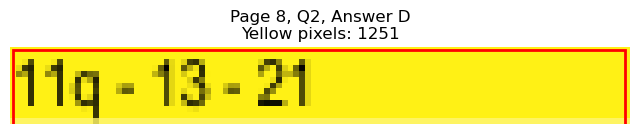


Page 8, Q2 - Selected Answer: D (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=68.3, y0=240.9, x1=153.0, y1=253.5
Page 8, Q3, A: Yellow pixels: 0
Page 8, Q3, A: Total non-white pixels: 430
Page 8, Q3, A: Yellow percentage: 0.0%


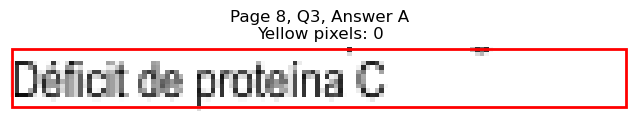

Page 8, Q3 - B: Detected box: x0=68.3, y0=253.5, x1=170.7, y1=266.1
Page 8, Q3, B: Yellow pixels: 0
Page 8, Q3, B: Total non-white pixels: 538
Page 8, Q3, B: Yellow percentage: 0.0%


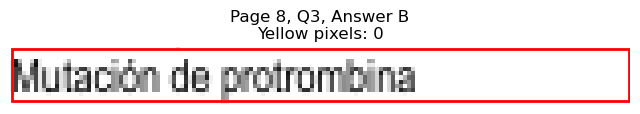

Page 8, Q3 - C: Detected box: x0=327.5, y0=240.9, x1=433.9, y1=253.5
Page 8, Q3, C: Yellow pixels: 1580
Page 8, Q3, C: Total non-white pixels: 2198
Page 8, Q3, C: Yellow percentage: 71.9%


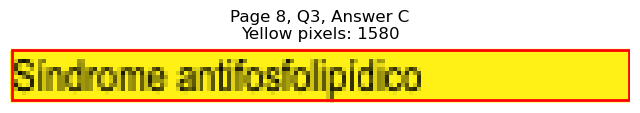

Page 8, Q3 - D: Detected box: x0=327.5, y0=253.5, x1=445.4, y1=266.1
Page 8, Q3, D: Yellow pixels: 169
Page 8, Q3, D: Total non-white pixels: 796
Page 8, Q3, D: Yellow percentage: 21.2%


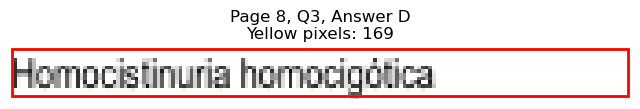


Page 8, Q3 - Selected Answer: C (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=68.3, y0=291.4, x1=168.6, y1=304.1
Page 8, Q4, A: Yellow pixels: 151
Page 8, Q4, A: Total non-white pixels: 656
Page 8, Q4, A: Yellow percentage: 23.0%


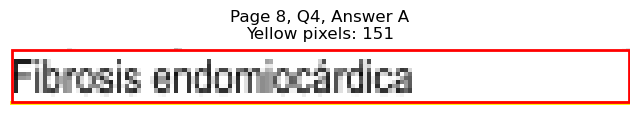

Page 8, Q4 - B: Detected box: x0=68.3, y0=304.0, x1=216.3, y1=316.7
Page 8, Q4, B: Yellow pixels: 2032
Page 8, Q4, B: Total non-white pixels: 2587
Page 8, Q4, B: Yellow percentage: 78.5%


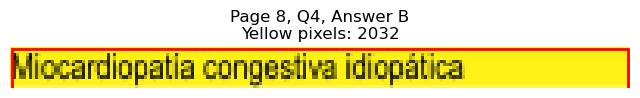

Page 8, Q4 - C: Detected box: x0=327.5, y0=291.4, x1=424.9, y1=304.1
Page 8, Q4, C: Yellow pixels: 0
Page 8, Q4, C: Total non-white pixels: 475
Page 8, Q4, C: Yellow percentage: 0.0%


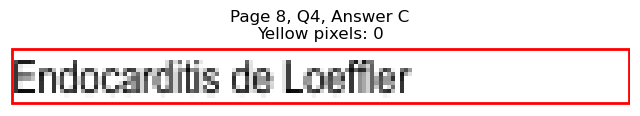

Page 8, Q4 - D: Detected box: x0=327.5, y0=304.0, x1=477.0, y1=316.7
Page 8, Q4, D: Yellow pixels: 0
Page 8, Q4, D: Total non-white pixels: 817
Page 8, Q4, D: Yellow percentage: 0.0%


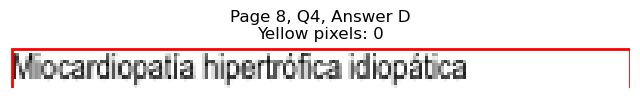


Page 8, Q4 - Selected Answer: B (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=68.3, y0=341.9, x1=159.0, y1=354.6
Page 8, Q5, A: Yellow pixels: 142
Page 8, Q5, A: Total non-white pixels: 622
Page 8, Q5, A: Yellow percentage: 22.8%


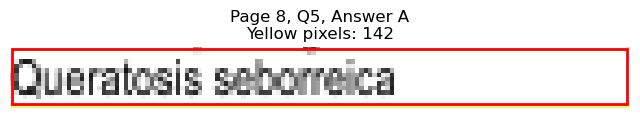

Page 8, Q5 - B: Detected box: x0=68.3, y0=354.5, x1=148.1, y1=367.2
Page 8, Q5, B: Yellow pixels: 1390
Page 8, Q5, B: Total non-white pixels: 1834
Page 8, Q5, B: Yellow percentage: 75.8%


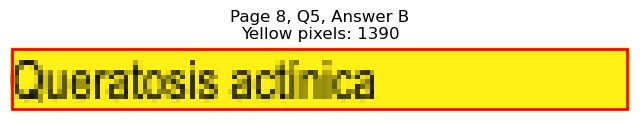

Page 8, Q5 - C: Detected box: x0=327.5, y0=341.9, x1=407.8, y1=354.6
Page 8, Q5, C: Yellow pixels: 0
Page 8, Q5, C: Total non-white pixels: 418
Page 8, Q5, C: Yellow percentage: 0.0%


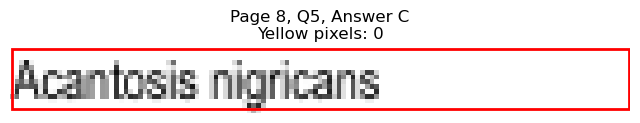

Page 8, Q5 - D: Detected box: x0=327.5, y0=354.5, x1=377.7, y1=367.2
Page 8, Q5, D: Yellow pixels: 0
Page 8, Q5, D: Total non-white pixels: 235
Page 8, Q5, D: Yellow percentage: 0.0%


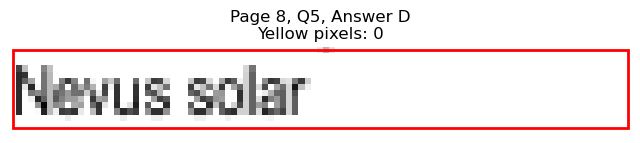


Page 8, Q5 - Selected Answer: B (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=68.3, y0=392.3, x1=104.9, y1=405.0
Page 8, Q6, A: Yellow pixels: 0
Page 8, Q6, A: Total non-white pixels: 166
Page 8, Q6, A: Yellow percentage: 0.0%


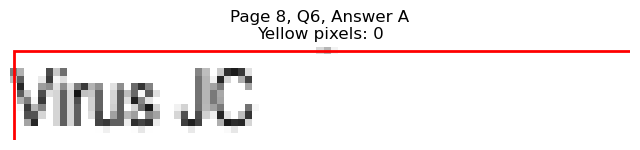

Page 8, Q6 - B: Detected box: x0=68.3, y0=405.0, x1=101.4, y1=417.7
Page 8, Q6, B: Yellow pixels: 969
Page 8, Q6, B: Total non-white pixels: 1092
Page 8, Q6, B: Yellow percentage: 88.7%


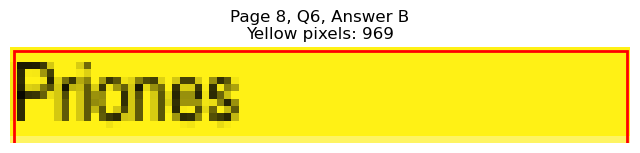

Page 8, Q6 - C: Detected box: x0=327.5, y0=392.3, x1=345.1, y1=405.0
Page 8, Q6, C: Yellow pixels: 0
Page 8, Q6, C: Total non-white pixels: 81
Page 8, Q6, C: Yellow percentage: 0.0%


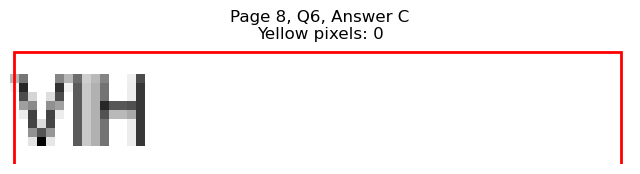

Page 8, Q6 - D: Detected box: x0=327.5, y0=405.0, x1=424.3, y1=417.7
Page 8, Q6, D: Yellow pixels: 0
Page 8, Q6, D: Total non-white pixels: 461
Page 8, Q6, D: Yellow percentage: 0.0%


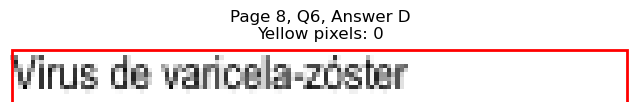


Page 8, Q6 - Selected Answer: B (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=68.3, y0=442.8, x1=106.9, y1=455.5
Page 8, Q7, A: Yellow pixels: 1008
Page 8, Q7, A: Total non-white pixels: 1246
Page 8, Q7, A: Yellow percentage: 80.9%


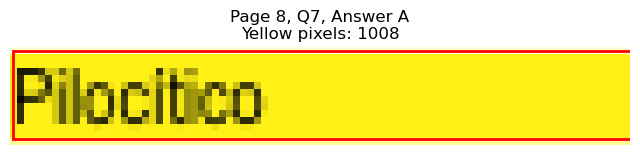

Page 8, Q7 - B: Detected box: x0=68.3, y0=455.5, x1=98.4, y1=468.1
Page 8, Q7, B: Yellow pixels: 0
Page 8, Q7, B: Total non-white pixels: 156
Page 8, Q7, B: Yellow percentage: 0.0%


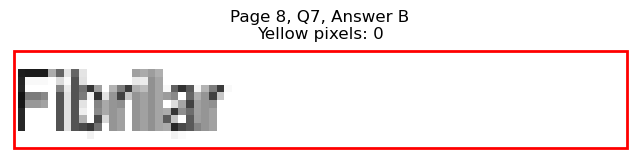

Page 8, Q7 - C: Detected box: x0=327.5, y0=442.8, x1=374.2, y1=455.5
Page 8, Q7, C: Yellow pixels: 0
Page 8, Q7, C: Total non-white pixels: 233
Page 8, Q7, C: Yellow percentage: 0.0%


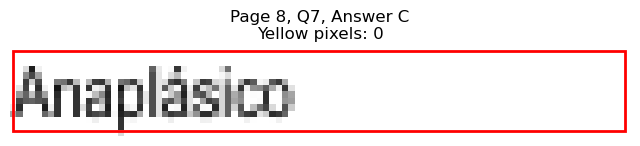

Page 8, Q7 - D: Detected box: x0=327.5, y0=455.5, x1=427.4, y1=468.1
Page 8, Q7, D: Yellow pixels: 0
Page 8, Q7, D: Total non-white pixels: 498
Page 8, Q7, D: Yellow percentage: 0.0%


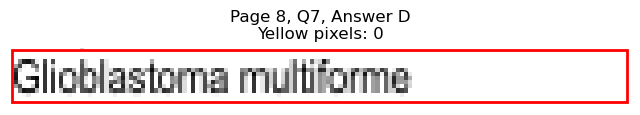


Page 8, Q7 - Selected Answer: A (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=68.3, y0=506.0, x1=262.2, y1=518.6
Page 8, Q8, A: Yellow pixels: 213
Page 8, Q8, A: Total non-white pixels: 1116
Page 8, Q8, A: Yellow percentage: 19.1%


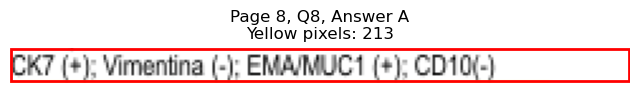

Page 8, Q8 - B: Detected box: x0=68.3, y0=518.6, x1=267.2, y1=531.2
Page 8, Q8, B: Yellow pixels: 2047
Page 8, Q8, B: Total non-white pixels: 3012
Page 8, Q8, B: Yellow percentage: 68.0%


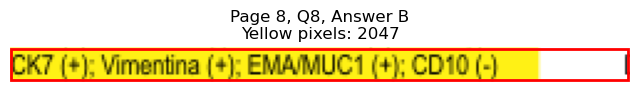

Page 8, Q8 - C: Detected box: x0=327.5, y0=506.0, x1=526.4, y1=518.6
Page 8, Q8, C: Yellow pixels: 0
Page 8, Q8, C: Total non-white pixels: 899
Page 8, Q8, C: Yellow percentage: 0.0%


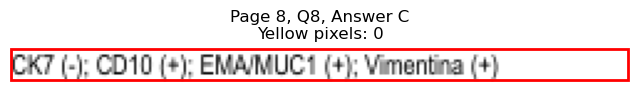

Page 8, Q8 - D: Detected box: x0=327.5, y0=518.6, x1=514.8, y1=531.2
Page 8, Q8, D: Yellow pixels: 0
Page 8, Q8, D: Total non-white pixels: 870
Page 8, Q8, D: Yellow percentage: 0.0%


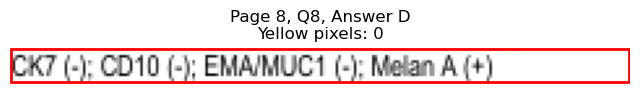


Page 8, Q8 - Selected Answer: B (based on yellow pixel count)




Page 8, Q9 - A: Detected box: x0=68.3, y0=581.7, x1=118.0, y1=594.4
Page 8, Q9, A: Yellow pixels: 0
Page 8, Q9, A: Total non-white pixels: 260
Page 8, Q9, A: Yellow percentage: 0.0%


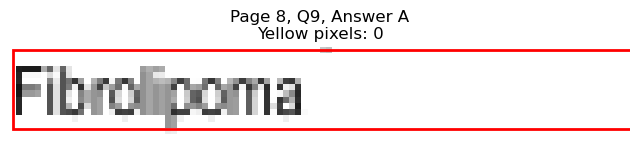

Page 8, Q9 - B: Detected box: x0=68.3, y0=594.3, x1=100.5, y1=607.0
Page 8, Q9, B: Yellow pixels: 0
Page 8, Q9, B: Total non-white pixels: 157
Page 8, Q9, B: Yellow percentage: 0.0%


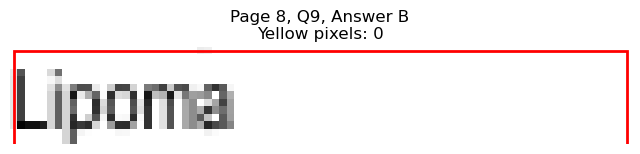

Page 8, Q9 - C: Detected box: x0=327.5, y0=581.7, x1=381.7, y1=594.4
Page 8, Q9, C: Yellow pixels: 105
Page 8, Q9, C: Total non-white pixels: 349
Page 8, Q9, C: Yellow percentage: 30.1%


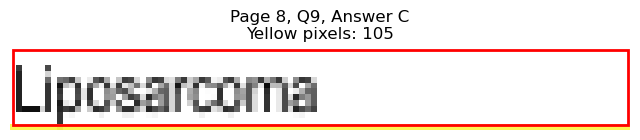

Page 8, Q9 - D: Detected box: x0=327.5, y0=594.3, x1=378.2, y1=607.0
Page 8, Q9, D: Yellow pixels: 1087
Page 8, Q9, D: Total non-white pixels: 1326
Page 8, Q9, D: Yellow percentage: 82.0%


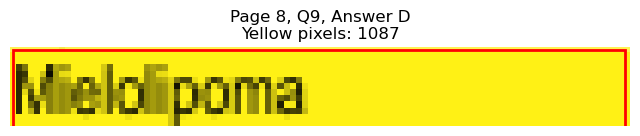


Page 8, Q9 - Selected Answer: D (based on yellow pixel count)




Page 8, Q10 - A: Detected box: x0=68.3, y0=644.9, x1=98.9, y1=657.5
Page 8, Q10, A: Yellow pixels: 0
Page 8, Q10, A: Total non-white pixels: 101
Page 8, Q10, A: Yellow percentage: 0.0%


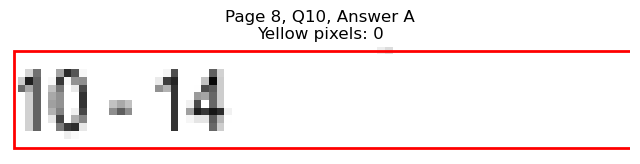

Page 8, Q10 - B: Detected box: x0=68.3, y0=657.5, x1=88.8, y1=670.1
Page 8, Q10, B: Yellow pixels: 0
Page 8, Q10, B: Total non-white pixels: 59
Page 8, Q10, B: Yellow percentage: 0.0%


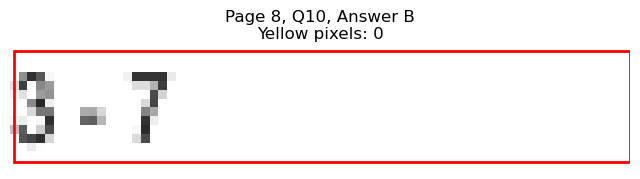

Page 8, Q10 - C: Detected box: x0=327.5, y0=644.9, x1=353.2, y1=657.5
Page 8, Q10, C: Yellow pixels: 946
Page 8, Q10, C: Total non-white pixels: 1078
Page 8, Q10, C: Yellow percentage: 87.8%


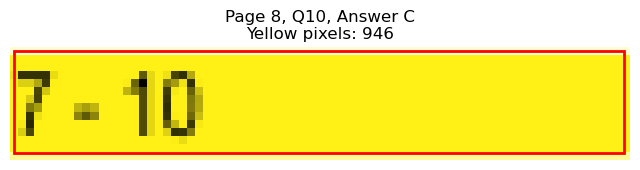

Page 8, Q10 - D: Detected box: x0=327.5, y0=657.5, x1=358.1, y1=670.1
Page 8, Q10, D: Yellow pixels: 82
Page 8, Q10, D: Total non-white pixels: 190
Page 8, Q10, D: Yellow percentage: 43.2%


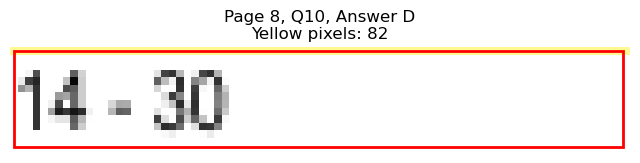


Page 8, Q10 - Selected Answer: C (based on yellow pixel count)




Page 8, Q11 - A: Detected box: x0=68.3, y0=695.4, x1=145.6, y1=708.0
Page 8, Q11, A: Yellow pixels: 128
Page 8, Q11, A: Total non-white pixels: 653
Page 8, Q11, A: Yellow percentage: 19.6%


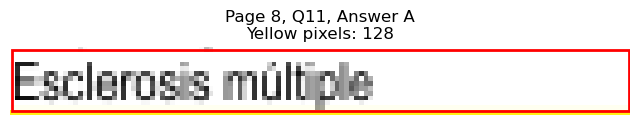

Page 8, Q11 - B: Detected box: x0=68.3, y0=708.0, x1=175.1, y1=720.6
Page 8, Q11, B: Yellow pixels: 1627
Page 8, Q11, B: Total non-white pixels: 2212
Page 8, Q11, B: Yellow percentage: 73.6%


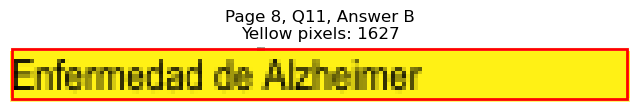

Page 8, Q11 - C: Detected box: x0=327.5, y0=695.4, x1=389.2, y1=708.0
Page 8, Q11, C: Yellow pixels: 0
Page 8, Q11, C: Total non-white pixels: 308
Page 8, Q11, C: Yellow percentage: 0.0%


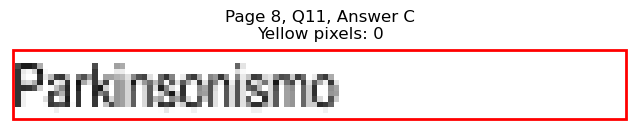

Page 8, Q11 - D: Detected box: x0=327.5, y0=708.0, x1=439.4, y1=720.6
Page 8, Q11, D: Yellow pixels: 0
Page 8, Q11, D: Total non-white pixels: 586
Page 8, Q11, D: Yellow percentage: 0.0%


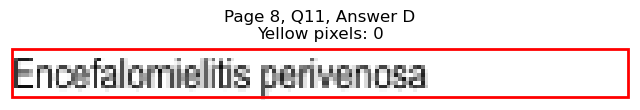


Page 8, Q11 - Selected Answer: B (based on yellow pixel count)




Page 8, Q12 - A: Detected box: x0=68.3, y0=745.9, x1=94.3, y1=758.6
Page 8, Q12, A: Yellow pixels: 917
Page 8, Q12, A: Total non-white pixels: 1078
Page 8, Q12, A: Yellow percentage: 85.1%


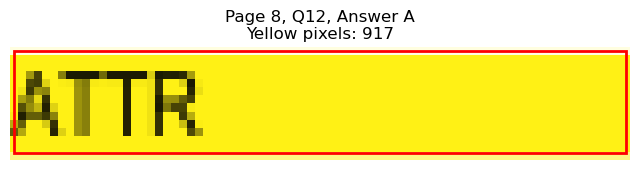

Page 8, Q12 - B: Detected box: x0=68.3, y0=758.5, x1=82.8, y1=771.2
Page 8, Q12, B: Yellow pixels: 65
Page 8, Q12, B: Total non-white pixels: 128
Page 8, Q12, B: Yellow percentage: 50.8%


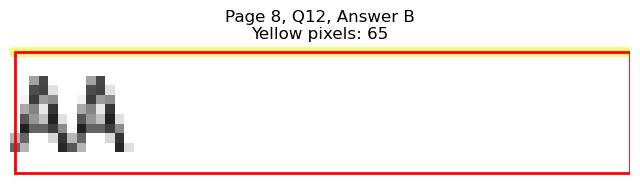

Page 8, Q12 - C: Detected box: x0=327.5, y0=745.9, x1=341.1, y1=758.6
Page 8, Q12, C: Yellow pixels: 0
Page 8, Q12, C: Total non-white pixels: 43
Page 8, Q12, C: Yellow percentage: 0.0%


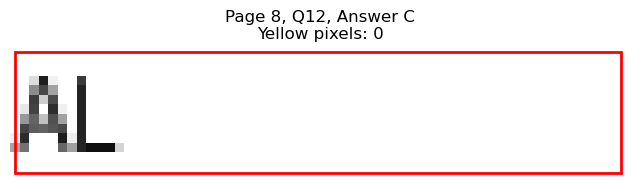

Page 8, Q12 - D: Detected box: x0=327.5, y0=758.5, x1=342.1, y1=771.2
Page 8, Q12, D: Yellow pixels: 0
Page 8, Q12, D: Total non-white pixels: 68
Page 8, Q12, D: Yellow percentage: 0.0%


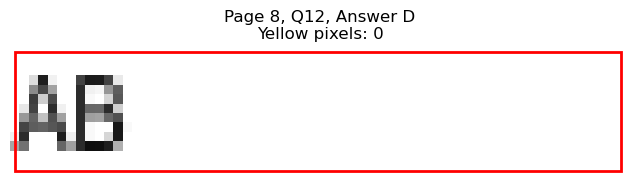


Page 8, Q12 - Selected Answer: A (based on yellow pixel count)





Page 9: Found 12 questions
Page 9, Q1 - A: Detected box: x0=68.3, y0=89.4, x1=107.9, y1=102.1
Page 9, Q1, A: Yellow pixels: 0
Page 9, Q1, A: Total non-white pixels: 133
Page 9, Q1, A: Yellow percentage: 0.0%


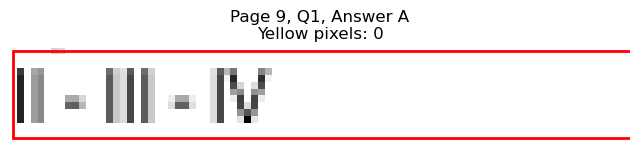

Page 9, Q1 - B: Detected box: x0=68.3, y0=102.0, x1=102.9, y1=114.7
Page 9, Q1, B: Yellow pixels: 0
Page 9, Q1, B: Total non-white pixels: 97
Page 9, Q1, B: Yellow percentage: 0.0%


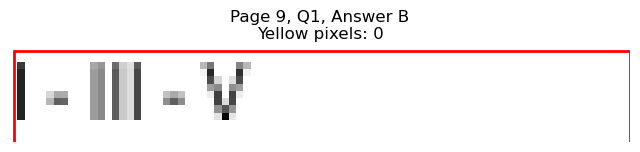

Page 9, Q1 - C: Detected box: x0=327.5, y0=89.4, x1=359.7, y1=102.1
Page 9, Q1, C: Yellow pixels: 1008
Page 9, Q1, C: Total non-white pixels: 1162
Page 9, Q1, C: Yellow percentage: 86.7%


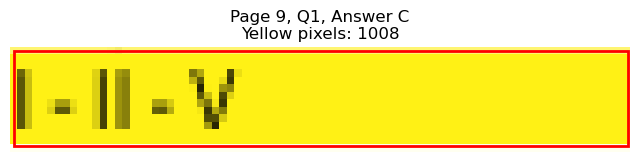

Page 9, Q1 - D: Detected box: x0=327.5, y0=102.0, x1=368.2, y1=114.7
Page 9, Q1, D: Yellow pixels: 0
Page 9, Q1, D: Total non-white pixels: 216
Page 9, Q1, D: Yellow percentage: 0.0%


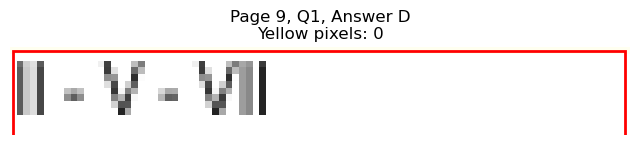


Page 9, Q1 - Selected Answer: C (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=68.3, y0=139.9, x1=152.5, y1=152.6
Page 9, Q2, A: Yellow pixels: 0
Page 9, Q2, A: Total non-white pixels: 451
Page 9, Q2, A: Yellow percentage: 0.0%


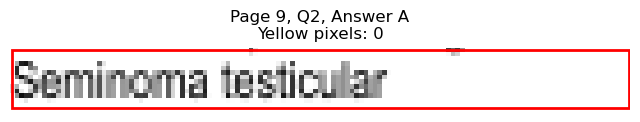

Page 9, Q2 - B: Detected box: x0=68.3, y0=152.5, x1=143.5, y1=165.2
Page 9, Q2, B: Yellow pixels: 0
Page 9, Q2, B: Total non-white pixels: 384
Page 9, Q2, B: Yellow percentage: 0.0%


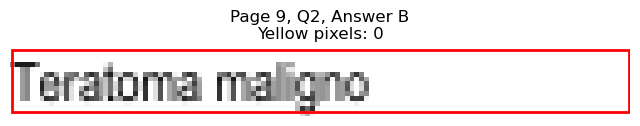

Page 9, Q2 - C: Detected box: x0=327.5, y0=139.9, x1=362.1, y1=152.6
Page 9, Q2, C: Yellow pixels: 994
Page 9, Q2, C: Total non-white pixels: 1204
Page 9, Q2, C: Yellow percentage: 82.6%


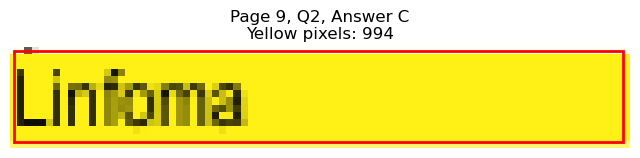

Page 9, Q2 - D: Detected box: x0=327.5, y0=152.5, x1=440.9, y1=165.2
Page 9, Q2, D: Yellow pixels: 164
Page 9, Q2, D: Total non-white pixels: 718
Page 9, Q2, D: Yellow percentage: 22.8%


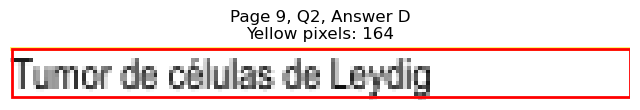


Page 9, Q2 - Selected Answer: C (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=68.3, y0=215.7, x1=171.1, y1=228.3
Page 9, Q3, A: Yellow pixels: 154
Page 9, Q3, A: Total non-white pixels: 696
Page 9, Q3, A: Yellow percentage: 22.1%


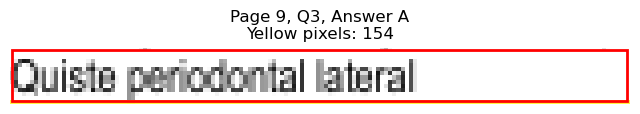

Page 9, Q3 - B: Detected box: x0=68.3, y0=228.3, x1=177.6, y1=240.9
Page 9, Q3, B: Yellow pixels: 1638
Page 9, Q3, B: Total non-white pixels: 2080
Page 9, Q3, B: Yellow percentage: 78.8%


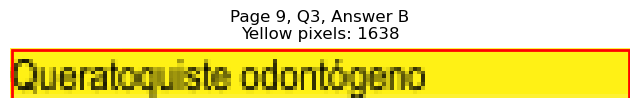

Page 9, Q3 - C: Detected box: x0=327.5, y0=215.7, x1=486.7, y1=228.3
Page 9, Q3, C: Yellow pixels: 0
Page 9, Q3, C: Total non-white pixels: 828
Page 9, Q3, C: Yellow percentage: 0.0%


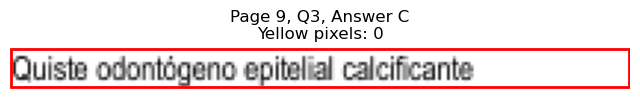

Page 9, Q3 - D: Detected box: x0=327.5, y0=228.3, x1=401.3, y1=240.9
Page 9, Q3, D: Yellow pixels: 0
Page 9, Q3, D: Total non-white pixels: 387
Page 9, Q3, D: Yellow percentage: 0.0%


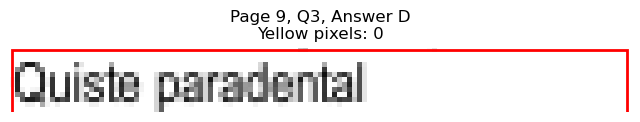


Page 9, Q3 - Selected Answer: B (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=68.3, y0=278.8, x1=158.1, y1=291.5
Page 9, Q4, A: Yellow pixels: 1494
Page 9, Q4, A: Total non-white pixels: 1974
Page 9, Q4, A: Yellow percentage: 75.7%


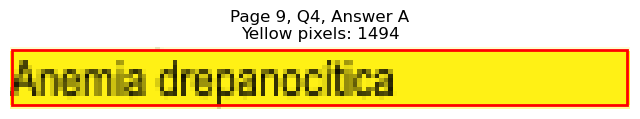

Page 9, Q4 - B: Detected box: x0=68.3, y0=291.4, x1=112.5, y1=304.1
Page 9, Q4, B: Yellow pixels: 95
Page 9, Q4, B: Total non-white pixels: 321
Page 9, Q4, B: Yellow percentage: 29.6%


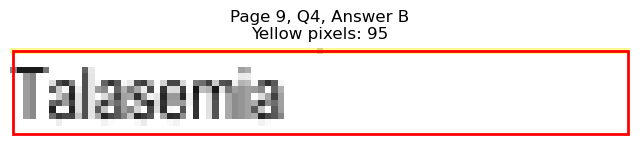

Page 9, Q4 - C: Detected box: x0=327.5, y0=278.8, x1=426.3, y1=291.5
Page 9, Q4, C: Yellow pixels: 0
Page 9, Q4, C: Total non-white pixels: 534
Page 9, Q4, C: Yellow percentage: 0.0%


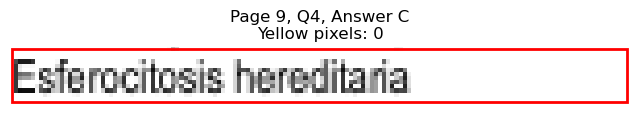

Page 9, Q4 - D: Detected box: x0=327.5, y0=291.4, x1=433.9, y1=304.1
Page 9, Q4, D: Yellow pixels: 0
Page 9, Q4, D: Total non-white pixels: 535
Page 9, Q4, D: Yellow percentage: 0.0%


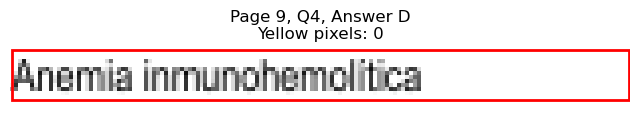


Page 9, Q4 - Selected Answer: A (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=68.3, y0=329.2, x1=174.1, y1=341.9
Page 9, Q5, A: Yellow pixels: 1618
Page 9, Q5, A: Total non-white pixels: 2041
Page 9, Q5, A: Yellow percentage: 79.3%


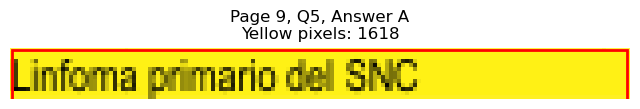

Page 9, Q5 - B: Detected box: x0=68.3, y0=341.9, x1=168.1, y1=354.6
Page 9, Q5, B: Yellow pixels: 149
Page 9, Q5, B: Total non-white pixels: 653
Page 9, Q5, B: Yellow percentage: 22.8%


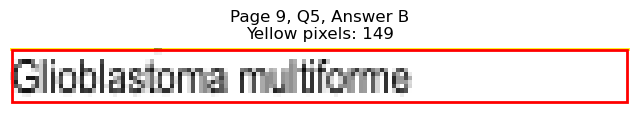

Page 9, Q5 - C: Detected box: x0=327.5, y0=329.2, x1=407.8, y1=341.9
Page 9, Q5, C: Yellow pixels: 0
Page 9, Q5, C: Total non-white pixels: 411
Page 9, Q5, C: Yellow percentage: 0.0%


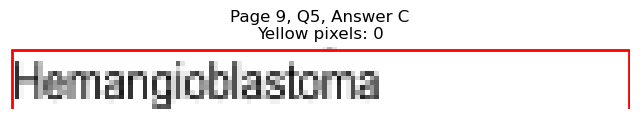

Page 9, Q5 - D: Detected box: x0=327.5, y0=341.9, x1=396.3, y1=354.6
Page 9, Q5, D: Yellow pixels: 0
Page 9, Q5, D: Total non-white pixels: 386
Page 9, Q5, D: Yellow percentage: 0.0%


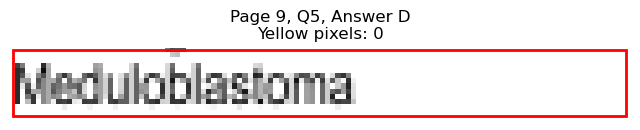


Page 9, Q5 - Selected Answer: A (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=68.3, y0=379.7, x1=116.9, y1=392.4
Page 9, Q6, A: Yellow pixels: 1003
Page 9, Q6, A: Total non-white pixels: 1386
Page 9, Q6, A: Yellow percentage: 72.4%


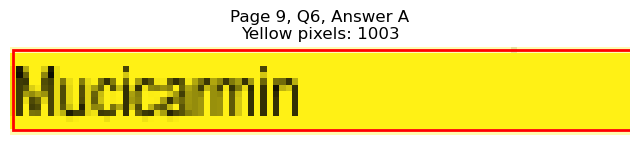

Page 9, Q6 - B: Detected box: x0=68.3, y0=392.3, x1=110.4, y1=405.0
Page 9, Q6, B: Yellow pixels: 0
Page 9, Q6, B: Total non-white pixels: 330
Page 9, Q6, B: Yellow percentage: 0.0%


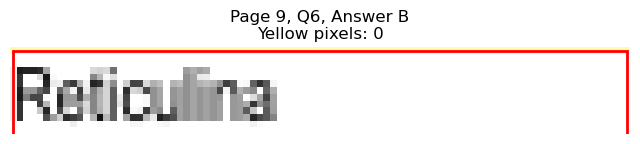

Page 9, Q6 - C: Detected box: x0=327.5, y0=379.7, x1=425.3, y1=392.4
Page 9, Q6, C: Yellow pixels: 0
Page 9, Q6, C: Total non-white pixels: 509
Page 9, Q6, C: Yellow percentage: 0.0%


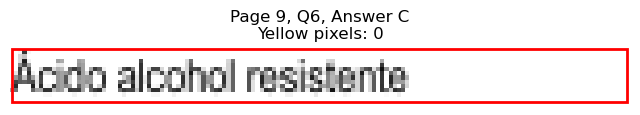

Page 9, Q6 - D: Detected box: x0=327.5, y0=392.3, x1=359.6, y1=405.0
Page 9, Q6, D: Yellow pixels: 0
Page 9, Q6, D: Total non-white pixels: 151
Page 9, Q6, D: Yellow percentage: 0.0%


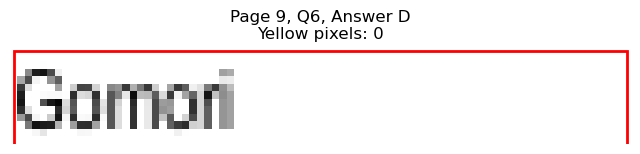


Page 9, Q6 - Selected Answer: A (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=68.3, y0=430.2, x1=105.4, y1=442.9
Page 9, Q7, A: Yellow pixels: 0
Page 9, Q7, A: Total non-white pixels: 164
Page 9, Q7, A: Yellow percentage: 0.0%


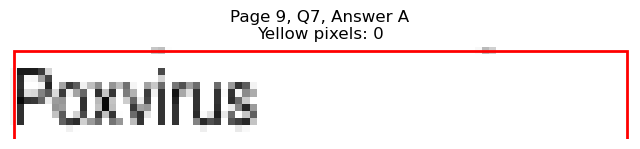

Page 9, Q7 - B: Detected box: x0=68.3, y0=442.8, x1=148.5, y1=455.5
Page 9, Q7, B: Yellow pixels: 0
Page 9, Q7, B: Total non-white pixels: 381
Page 9, Q7, B: Yellow percentage: 0.0%


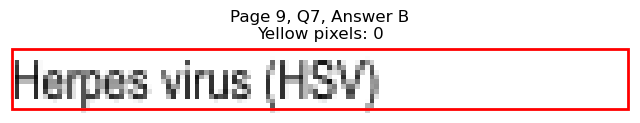

Page 9, Q7 - C: Detected box: x0=327.5, y0=430.2, x1=365.1, y1=442.9
Page 9, Q7, C: Yellow pixels: 0
Page 9, Q7, C: Total non-white pixels: 250
Page 9, Q7, C: Yellow percentage: 0.0%


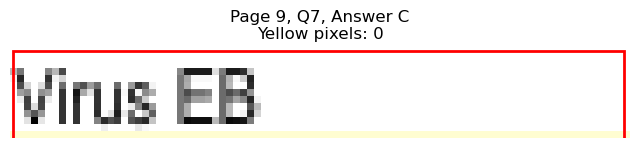

Page 9, Q7 - D: Detected box: x0=327.5, y0=442.8, x1=416.2, y1=455.5
Page 9, Q7, D: Yellow pixels: 1496
Page 9, Q7, D: Total non-white pixels: 1960
Page 9, Q7, D: Yellow percentage: 76.3%


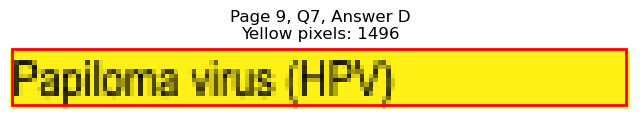


Page 9, Q7 - Selected Answer: D (based on yellow pixel count)




Page 9, Q8 - A: Detected box: x0=68.3, y0=480.8, x1=123.5, y1=493.4
Page 9, Q8, A: Yellow pixels: 0
Page 9, Q8, A: Total non-white pixels: 274
Page 9, Q8, A: Yellow percentage: 0.0%


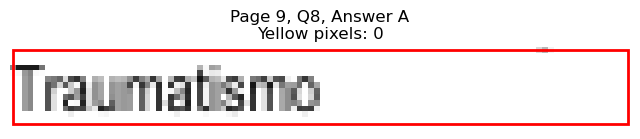

Page 9, Q8 - B: Detected box: x0=68.3, y0=493.4, x1=180.1, y1=506.0
Page 9, Q8, B: Yellow pixels: 0
Page 9, Q8, B: Total non-white pixels: 583
Page 9, Q8, B: Yellow percentage: 0.0%


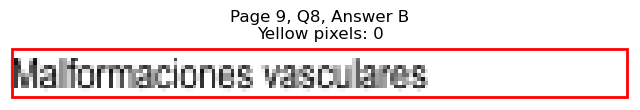

Page 9, Q8 - C: Detected box: x0=327.5, y0=480.8, x1=408.8, y1=493.4
Page 9, Q8, C: Yellow pixels: 132
Page 9, Q8, C: Total non-white pixels: 553
Page 9, Q8, C: Yellow percentage: 23.9%


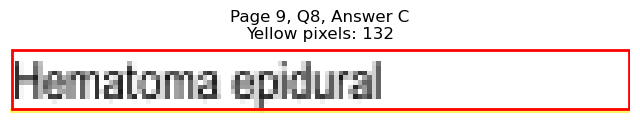

Page 9, Q8 - D: Detected box: x0=327.5, y0=493.4, x1=444.4, y1=506.0
Page 9, Q8, D: Yellow pixels: 1725
Page 9, Q8, D: Total non-white pixels: 2188
Page 9, Q8, D: Yellow percentage: 78.8%


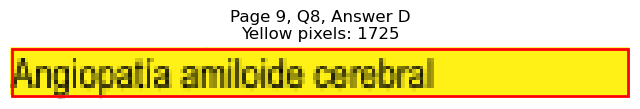


Page 9, Q8 - Selected Answer: D (based on yellow pixel count)




Page 9, Q9 - A: Detected box: x0=68.3, y0=556.5, x1=222.8, y1=569.2
Page 9, Q9, A: Yellow pixels: 0
Page 9, Q9, A: Total non-white pixels: 832
Page 9, Q9, A: Yellow percentage: 0.0%


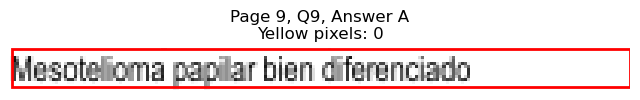

Page 9, Q9 - B: Detected box: x0=68.3, y0=569.1, x1=216.8, y1=581.8
Page 9, Q9, B: Yellow pixels: 0
Page 9, Q9, B: Total non-white pixels: 786
Page 9, Q9, B: Yellow percentage: 0.0%


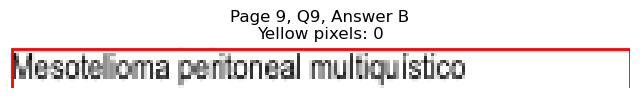

Page 9, Q9 - C: Detected box: x0=327.5, y0=556.5, x1=415.3, y1=569.2
Page 9, Q9, C: Yellow pixels: 139
Page 9, Q9, C: Total non-white pixels: 614
Page 9, Q9, C: Yellow percentage: 22.6%


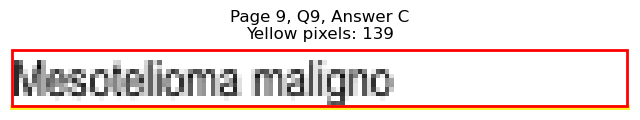

Page 9, Q9 - D: Detected box: x0=327.5, y0=569.1, x1=415.9, y1=581.8
Page 9, Q9, D: Yellow pixels: 1459
Page 9, Q9, D: Total non-white pixels: 1807
Page 9, Q9, D: Yellow percentage: 80.7%


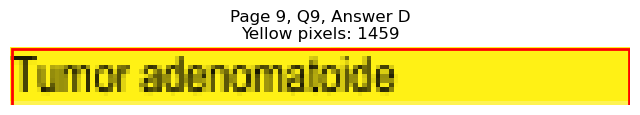


Page 9, Q9 - Selected Answer: D (based on yellow pixel count)




Page 9, Q10 - A: Detected box: x0=68.3, y0=632.2, x1=180.1, y1=644.9
Page 9, Q10, A: Yellow pixels: 0
Page 9, Q10, A: Total non-white pixels: 525
Page 9, Q10, A: Yellow percentage: 0.0%


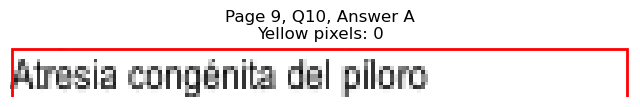

Page 9, Q10 - B: Detected box: x0=68.3, y0=644.9, x1=118.0, y1=657.5
Page 9, Q10, B: Yellow pixels: 0
Page 9, Q10, B: Total non-white pixels: 282
Page 9, Q10, B: Yellow percentage: 0.0%


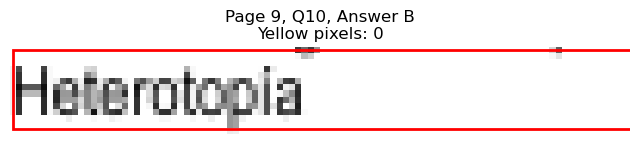

Page 9, Q10 - C: Detected box: x0=327.5, y0=632.2, x1=400.3, y1=644.9
Page 9, Q10, C: Yellow pixels: 1313
Page 9, Q10, C: Total non-white pixels: 1612
Page 9, Q10, C: Yellow percentage: 81.5%


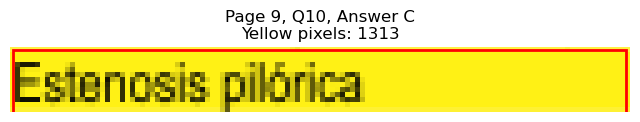

Page 9, Q10 - D: Detected box: x0=327.5, y0=644.9, x1=439.9, y1=657.5
Page 9, Q10, D: Yellow pixels: 0
Page 9, Q10, D: Total non-white pixels: 593
Page 9, Q10, D: Yellow percentage: 0.0%


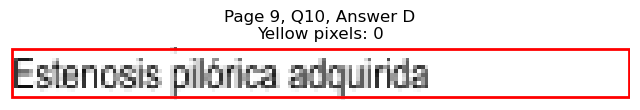


Page 9, Q10 - Selected Answer: C (based on yellow pixel count)




Page 9, Q11 - A: Detected box: x0=68.3, y0=682.7, x1=148.6, y1=695.3
Page 9, Q11, A: Yellow pixels: 0
Page 9, Q11, A: Total non-white pixels: 408
Page 9, Q11, A: Yellow percentage: 0.0%


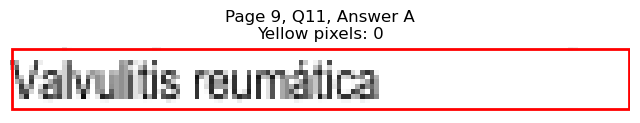

Page 9, Q11 - B: Detected box: x0=68.3, y0=695.4, x1=133.0, y1=708.0
Page 9, Q11, B: Yellow pixels: 1256
Page 9, Q11, B: Total non-white pixels: 1495
Page 9, Q11, B: Yellow percentage: 84.0%


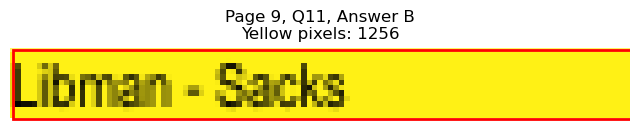

Page 9, Q11 - C: Detected box: x0=327.5, y0=682.7, x1=429.9, y1=695.3
Page 9, Q11, C: Yellow pixels: 0
Page 9, Q11, C: Total non-white pixels: 498
Page 9, Q11, C: Yellow percentage: 0.0%


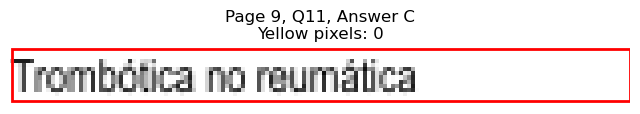

Page 9, Q11 - D: Detected box: x0=327.5, y0=695.4, x1=415.4, y1=708.0
Page 9, Q11, D: Yellow pixels: 0
Page 9, Q11, D: Total non-white pixels: 473
Page 9, Q11, D: Yellow percentage: 0.0%


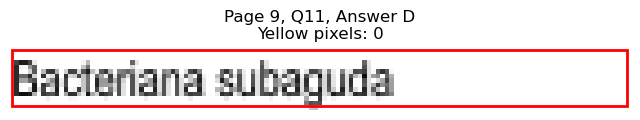


Page 9, Q11 - Selected Answer: B (based on yellow pixel count)




Page 9, Q12 - A: Detected box: x0=68.3, y0=733.2, x1=164.1, y1=745.8
Page 9, Q12, A: Yellow pixels: 0
Page 9, Q12, A: Total non-white pixels: 491
Page 9, Q12, A: Yellow percentage: 0.0%


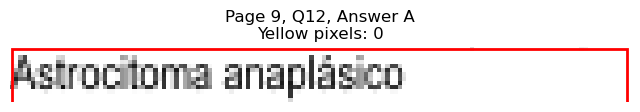

Page 9, Q12 - B: Detected box: x0=68.3, y0=341.9, x1=168.1, y1=354.6
Page 9, Q12, B: Yellow pixels: 149
Page 9, Q12, B: Total non-white pixels: 653
Page 9, Q12, B: Yellow percentage: 22.8%


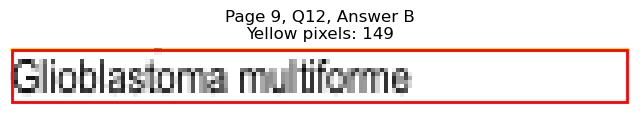

Page 9, Q12 - C: Detected box: x0=327.5, y0=733.2, x1=396.3, y1=745.8
Page 9, Q12, C: Yellow pixels: 1247
Page 9, Q12, C: Total non-white pixels: 1560
Page 9, Q12, C: Yellow percentage: 79.9%


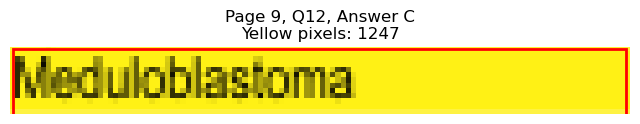

Page 9, Q12 - D: Detected box: x0=327.5, y0=745.8, x1=383.2, y1=758.4
Page 9, Q12, D: Yellow pixels: 107
Page 9, Q12, D: Total non-white pixels: 380
Page 9, Q12, D: Yellow percentage: 28.2%


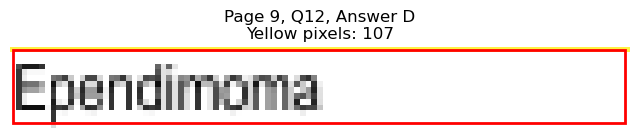


Page 9, Q12 - Selected Answer: C (based on yellow pixel count)





Page 10: Found 3 questions
Page 10, Q1 - A: Detected box: x0=68.3, y0=89.4, x1=116.9, y1=102.1
Page 10, Q1, A: Yellow pixels: 99
Page 10, Q1, A: Total non-white pixels: 332
Page 10, Q1, A: Yellow percentage: 29.8%


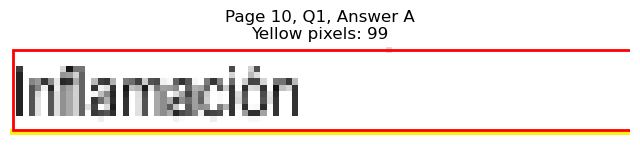

Page 10, Q1 - B: Detected box: x0=68.3, y0=102.0, x1=209.8, y1=114.7
Page 10, Q1, B: Yellow pixels: 1930
Page 10, Q1, B: Total non-white pixels: 2496
Page 10, Q1, B: Yellow percentage: 77.3%


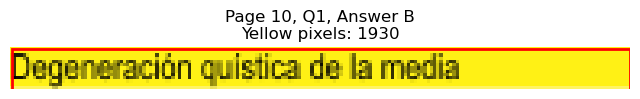

Page 10, Q1 - C: Detected box: x0=327.5, y0=89.4, x1=416.3, y1=102.1
Page 10, Q1, C: Yellow pixels: 0
Page 10, Q1, C: Total non-white pixels: 439
Page 10, Q1, C: Yellow percentage: 0.0%


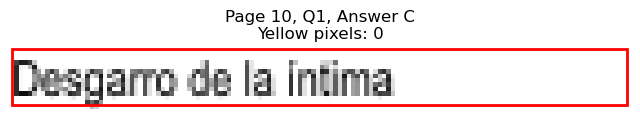

Page 10, Q1 - D: Detected box: x0=327.5, y0=102.0, x1=415.3, y1=114.7
Page 10, Q1, D: Yellow pixels: 0
Page 10, Q1, D: Total non-white pixels: 449
Page 10, Q1, D: Yellow percentage: 0.0%


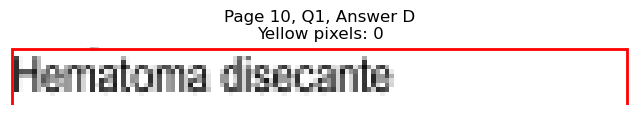


Page 10, Q1 - Selected Answer: B (based on yellow pixel count)




Page 10, Q2 - A: Detected box: x0=68.3, y0=139.9, x1=146.5, y1=152.6
Page 10, Q2, A: Yellow pixels: 129
Page 10, Q2, A: Total non-white pixels: 520
Page 10, Q2, A: Yellow percentage: 24.8%


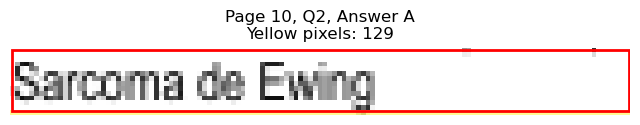

Page 10, Q2 - B: Detected box: x0=68.3, y0=152.5, x1=180.1, y1=165.2
Page 10, Q2, B: Yellow pixels: 1686
Page 10, Q2, B: Total non-white pixels: 2282
Page 10, Q2, B: Yellow percentage: 73.9%


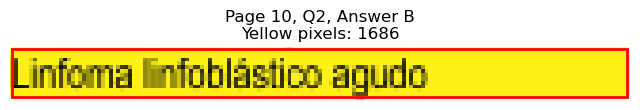

Page 10, Q2 - C: Detected box: x0=327.5, y0=139.9, x1=467.0, y1=152.6
Page 10, Q2, C: Yellow pixels: 0
Page 10, Q2, C: Total non-white pixels: 703
Page 10, Q2, C: Yellow percentage: 0.0%


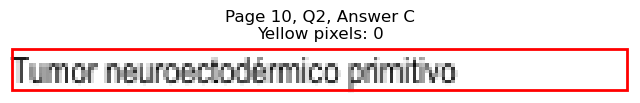

Page 10, Q2 - D: Detected box: x0=327.5, y0=152.5, x1=391.3, y1=165.2
Page 10, Q2, D: Yellow pixels: 0
Page 10, Q2, D: Total non-white pixels: 344
Page 10, Q2, D: Yellow percentage: 0.0%


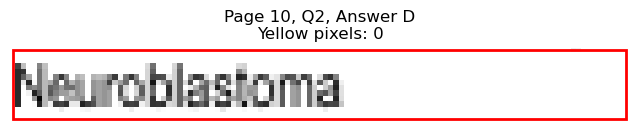


Page 10, Q2 - Selected Answer: B (based on yellow pixel count)




Page 10, Q3 - A: Detected box: x0=68.3, y0=190.3, x1=130.0, y1=203.0
Page 10, Q3, A: Yellow pixels: 0
Page 10, Q3, A: Total non-white pixels: 408
Page 10, Q3, A: Yellow percentage: 0.0%


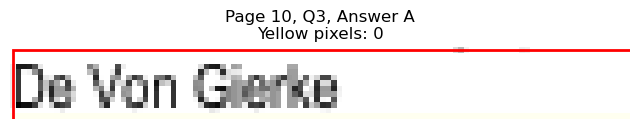

Page 10, Q3 - B: Detected box: x0=68.3, y0=202.9, x1=113.4, y1=215.6
Page 10, Q3, B: Yellow pixels: 1081
Page 10, Q3, B: Total non-white pixels: 1344
Page 10, Q3, B: Yellow percentage: 80.4%


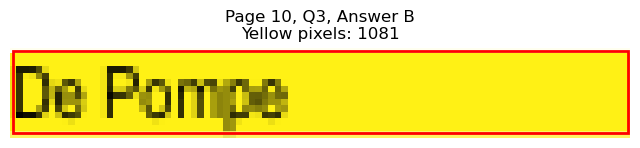

Page 10, Q3 - C: Detected box: x0=327.5, y0=190.3, x1=367.6, y1=203.0
Page 10, Q3, C: Yellow pixels: 0
Page 10, Q3, C: Total non-white pixels: 191
Page 10, Q3, C: Yellow percentage: 0.0%


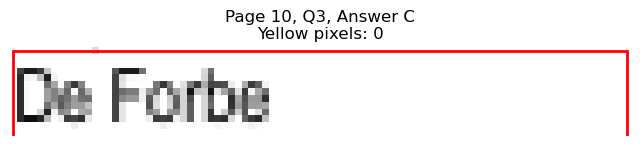

Page 10, Q3 - D: Detected box: x0=327.5, y0=202.9, x1=382.7, y1=215.6
Page 10, Q3, D: Yellow pixels: 0
Page 10, Q3, D: Total non-white pixels: 257
Page 10, Q3, D: Yellow percentage: 0.0%


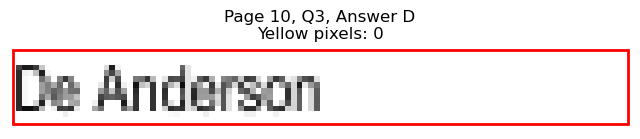


Page 10, Q3 - Selected Answer: B (based on yellow pixel count)






In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   El AP de biopsia gástrica informa agregados de...
1   Paciente de 60 años, con deficiencia de Vitami...
2   ¿Qué tipo de lepra se caracteriza por presenta...
3   Varón de 44 años portador de neumoconiosis, el...
4   Varón de 21 años con tumor localizado en muslo...
..                                                ...
95  ¿En qué tipo de endocarditis se pueden ver los...
96  ¿Cuál es el tumor encefálico que se puede dise...
97  ¿Cuál es el daño preexistente detectado histol...
98  ¿Cuáles son los tumores que se presentan con m...
99  ¿Qué enfermedad del grupo de las glucogenosis ...

[100 rows x 1 columns]

In [8]:
answers_df

option_A                           option_B  \
0   CD68 (+); AE1/AE3 (-); PAX-2 (-)   CD68 (+); AE1/AE3 (+); PAX-2 (-)   
1              Gastritis linfocítica                   Tumor carcinoide   
2                        Lepromatosa                Dismorfo intermedia   
3                        Por asbesto                          Silicosis   
4               Grasa parda residual                       Lipoma fetal   
..                               ...                                ...   
95              Valvulitis reumática                     Libman - Sacks   
96            Astrocitoma anaplásico            Glioblastoma multiforme   
97                       Inflamación  Degeneración quística de la media   
98                  Sarcoma de Ewing        Linfoma linfoblástico agudo   
99                     De Von Gierke                           De Pompe   

                            option_C                          option_D  
0   CD68 (+); AE1/AE3 (+); PAX-2 (+)  CD68 (-); AE1/AE3 (-); PAX-2 (+)  
1          Gastritis autoinmunitaria                Gastritis atrófica  
2               Dismorfo lepromatosa                      Tuberculoide  
3      De los trabajadores de carbón                        Beriliosis  
4                 Lipoma angiomatoso          Tumor lipomatoso atípico  
..                               ...                               ...  
95           Trombótica no reumática               Bacteriana subaguda  
96                    Meduloblastoma                        Ependimoma  
97             Desgarro de la íntima                Hematoma disecante  
98  Tumor neuroectodérmico primitivo                     Neuroblastoma  
99                          De Forbe                       De Anderson  

[100 rows x 4 columns]

In [9]:
correct_answers_df

correct_answer
0               A
1               C
2               D
3               B
4               B
..            ...
95              B
96              C
97              B
98              B
99              B

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "correct_answer"]
total_df

questions  \
0   El AP de biopsia gástrica informa agregados de...   
1   Paciente de 60 años, con deficiencia de Vitami...   
2   ¿Qué tipo de lepra se caracteriza por presenta...   
3   Varón de 44 años portador de neumoconiosis, el...   
4   Varón de 21 años con tumor localizado en muslo...   
..                                                ...   
95  ¿En qué tipo de endocarditis se pueden ver los...   
96  ¿Cuál es el tumor encefálico que se puede dise...   
97  ¿Cuál es el daño preexistente detectado histol...   
98  ¿Cuáles son los tumores que se presentan con m...   
99  ¿Qué enfermedad del grupo de las glucogenosis ...   

                            option_A                           option_B  \
0   CD68 (+); AE1/AE3 (-); PAX-2 (-)   CD68 (+); AE1/AE3 (+); PAX-2 (-)   
1              Gastritis linfocítica                   Tumor carcinoide   
2                        Lepromatosa                Dismorfo intermedia   
3                        Por asbesto                          Silicosis   
4               Grasa parda residual                       Lipoma fetal   
..                               ...                                ...   
95              Valvulitis reumática                     Libman - Sacks   
96            Astrocitoma anaplásico            Glioblastoma multiforme   
97                       Inflamación  Degeneración quística de la media   
98                  Sarcoma de Ewing        Linfoma linfoblástico agudo   
99                     De Von Gierke                           De Pompe   

                            option_C                          option_D  \
0   CD68 (+); AE1/AE3 (+); PAX-2 (+)  CD68 (-); AE1/AE3 (-); PAX-2 (+)   
1          Gastritis autoinmunitaria                Gastritis atrófica   
2               Dismorfo lepromatosa                      Tuberculoide   
3      De los trabajadores de carbón                        Beriliosis   
4                 Lipoma angiomatoso          Tumor lipomatoso atípico   
..                               ...                               ...   
95           Trombótica no reumática               Bacteriana subaguda   
96                    Meduloblastoma                        Ependimoma   
97             Desgarro de la íntima                Hematoma disecante   
98  Tumor neuroectodérmico primitivo                     Neuroblastoma   
99                          De Forbe                       De Anderson   

   correct_answer  
0               A  
1               C  
2               D  
3               B  
4               B  
..            ...  
95              B  
96              C  
97              B  
98              B  
99              B  

[100 rows x 6 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2023/ANATOMIA PATOLOGICA.csv
